In [1]:
import numpy as np
import copy
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, Sequential
from keras import regularizers
from keras import backend as K
import Data_prep as dp
from scipy.io import savemat, loadmat
from keras.losses import mse, binary_crossentropy
from keras.layers import Reshape, Lambda, Input, Dense, Flatten, Conv2D, Conv2DTranspose
from keras.layers import Activation, ZeroPadding2D, BatchNormalization, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
K.set_image_data_format('channels_last')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy.io
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from keras import backend
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from matplotlib import pyplot
from keras.constraints import Constraint
import tensorflow as tf

In [3]:
def normalize(data):
    
    max_=np.max(data, axis=0)
    min_=np.min(data, axis=0)
    mean_=np.mean(data,axis=0)
    std_=np.std(data,axis=0)
    
    return np.divide((data-mean_),(std_))

In [4]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.multiply(y_true, y_pred))

class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

def generator(latent_dim):

    #decoder network:
    l_decode=0.0
    #input/BC:
    latent_input = Input(shape=(latent_dim,), name='latent_decode') #input
    x = latent_input
    init = RandomNormal(stddev=0.02)
    #fully connected layer 1:
    x = Dense(1000, kernel_initializer=init, kernel_regularizer = regularizers.l1(l_decode))(x)
    x = BatchNormalization(axis = 1)(x)
    x = LeakyReLU(alpha=0.2)(x)

    #fully connected layer 2:
    x = Dense(5000, kernel_initializer=init, kernel_regularizer = regularizers.l1(l_decode))(x)
    x = BatchNormalization(axis = 1)(x)
    x = LeakyReLU(alpha=0.2)(x)

    #reshaping:
    x = Reshape((10, 125, 4))(x)

    #CNN/upsampling layer 1:
    x = Conv2DTranspose(4, (5, 5), strides = (1, 1), padding='same', kernel_initializer=init, kernel_regularizer = regularizers.l1(l_decode))(x)
    x = BatchNormalization(axis = 3)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2), interpolation = 'bilinear')(x)
    #x = AveragePooling2D((2, 2), padding='same')(x)
    x = Conv2DTranspose(4, (5, 5), strides = (1, 1), padding='same', kernel_initializer=init, kernel_regularizer = regularizers.l1(l_decode))(x)
    x = BatchNormalization(axis = 3)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2, 2), interpolation = 'bilinear')(x)
    #x = AveragePooling2D((2, 2), padding='same')(x)
    #output:
#     x = Conv2D(1, (9, 9), padding='same', strides = (4, 4), kernel_initializer=init)(x)
#     x = BatchNormalization(axis = 3)(x)
#     x = LeakyReLU(alpha=0.2)(x)
    outputs = Conv2DTranspose(1, (9, 9), padding='same', strides = (1, 1), kernel_initializer=init, activation = 'tanh', name='bathymetry')(x)
    #outputs = UpSampling2D((2, 2))(x)
    #set decoder model:
    decoder = Model([latent_input], outputs, name='decoder')
    return decoder 


In [5]:
def critic(in_shape=(40, 500, 1)):

    #decoder network:
    l_decode=0.0
    #input/BC:
    inputs = Input(shape=in_shape) #input
    const = ClipConstraint(100000)
    init = RandomNormal(stddev=0.1)
    y = inputs
    y = Conv2D(128, (5, 5), padding='same', strides=(2, 2))(y)
    y = BatchNormalization(axis = 3)(y)
    y = LeakyReLU(alpha=0.5)(y)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Dropout(0.25)(y)
    y = Conv2D(128, (5, 5), padding='same', strides=(2, 2))(y)
    y = BatchNormalization(axis = 3)(y)
    y = LeakyReLU(alpha=0.5)(y)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Dropout(0.25)(y)
    y = Conv2D(128, (5, 5), padding='same', strides=(2, 2))(y)
    y = BatchNormalization(axis = 3)(y)
    y = LeakyReLU(alpha=0.5)(y)
    y = MaxPooling2D((2, 2), padding='same')(y)
    y = Dropout(0.25)(y)
    y = Flatten()(y)
    y = Dense(1024)(y)
    y = BatchNormalization(axis = 1)(y)
    y = LeakyReLU(alpha=0.2)(y)
    y = Flatten()(y)
    y = Dense(512)(y)
    y = BatchNormalization(axis = 1)(y)
    y = LeakyReLU(alpha=0.2)(y)
    outputs = Dense(1, activation = 'sigmoid')(y)
    #y = BatchNormalization(axis = 1)(y)
    #outputs = LeakyReLU(alpha=0.2)(y)
    #set critic model:
    critic = Model([inputs], [outputs])
    opt = Adam(lr=0.0002, beta_1=0.5)
    critic.compile(loss='binary_crossentropy', optimizer=opt)
    return critic 


In [6]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model(gen_output)
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise], [gan_output])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [7]:
# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X = images[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    #x_input = tf.random.normal(latent_dim * n_samples)
    z_input = tf.random.normal([n_samples, latent_dim]) 
    return [z_input]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images], y

In [8]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128, n_steps = 4):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    d_loss1 = 0 
    d_loss2 = 0
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            real_iter = 1
            if (d_loss1 > 0):
                real_iter = 1
            fake_iter = 1
            if (d_loss2 > 0):
                real_iter = 1
            for k in range(real_iter):
                # get randomly selected 'real' samples
                X_real, y_real = generate_real_samples(dataset, n_batch)
                # update discriminator model weights
                d_loss1 = d_model.train_on_batch([X_real], y_real)
                # generate 'fake' examples
            for kk in range(real_iter):
                [X_fake], y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
                # update discriminator model weights
                d_loss2 = d_model.train_on_batch([X_fake], y_fake)
                # prepare points in latent space as input for the generator
                [z_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input], [y_gan])
            ####
            d_loss1 = d_model.test_on_batch([X_real], y_real)
            d_loss2 = d_model.test_on_batch([X_fake], y_fake)
            g_loss = gan_model.test_on_batch([z_input], [y_gan])
            ####
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

In [9]:
def train_c(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128, n_steps = 4):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    d_loss1 = 0 
    d_loss2 = 0
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            print(i + j)
            real_iter = 1
            if (d_loss1 > 0):
                real_iter = 1
            fake_iter = 1
            if (d_loss2 > 0):
                real_iter = 1
            for k in range(real_iter):
                # get randomly selected 'real' samples
                X_real, y_real = generate_real_samples(dataset, n_batch)
                # update discriminator model weights
                d_loss1 = d_model.train_on_batch([X_real], y_real)
            # generate 'fake' examples
            for kk in range(real_iter):
                [X_fake], y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
                # update discriminator model weights
                d_loss2 = d_model.train_on_batch([X_fake], y_fake)
            # prepare points in latent space as input for the generator
            [z_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            ####
            d_loss1 = d_model.test_on_batch([X_real], y_real)
            d_loss2 = d_model.test_on_batch([X_fake], y_fake)
            ####
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2))

In [10]:
def train_g(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128, n_steps = 4):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # prepare points in latent space as input for the generator
            [z_input] = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            # create inverted labels for the fake samples
            g_loss = gan_model.train_on_batch([z_input], [y_gan])
            ####
            g_loss = gan_model.test_on_batch([z_input], [y_gan])
            ####
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f' %(i+1, j+1, bat_per_epo, g_loss))

In [11]:
data = loadmat('Sav_BC_func_PCGA_1std_noise10_std4_zmax94_48_12_s0_5_6.mat')
vel = data['velocity_prof'] #velocities
z_f = data['z_f'] #free surface elevation
Q_b = data['Q_b'] #influx
Z = data['Z'] #bathymetry
vx, vy, _ = dp.xy_vel_sep(vel) #v_x/v_y separation
data_z = np.reshape(Z.T, (4500, 41, 501, 1))
data_z = data_z[:, :40, :500, :]
std_ = np.reshape(np.std(np.reshape(data_z, (4500, 20000)), axis = 0), (1,40,500,1))
mean_ = np.reshape(np.mean(np.reshape(data_z, (4500, 20000)), axis = 0), (1,40,500,1))
min_ = np.reshape(np.min(np.reshape(data_z, (4500, 20000)), axis = 0), (1,40,500,1))
max_ = np.reshape(np.max(np.reshape(data_z, (4500, 20000)), axis = 0), (1,40,500,1))
data_zn = ((data_z - min_) / (max_ - min_))
data_zn = (data_zn - 0.5) * 2

In [12]:
g_model = generator(50)
c_model = critic()
gan_model = define_gan(g_model, c_model)
#train(g_model, c_model, gan_model, data_zn, 50, n_epochs=100, n_batch=128)

In [13]:
epo = 100
for k in range(epo):
    #g_model = generator(50)
    num_sample = data_zn.shape[0]
    fake_samples = generate_fake_samples(g_model, 50, num_sample)[0][0]
    x_train = np.concatenate((fake_samples, data_zn))
    y_train = np.concatenate((np.zeros((num_sample, 1)), (np.ones((num_sample, 1)))))
    r_index = np.random.permutation(num_sample * 2) - 1
    x_train = x_train[r_index, :, :, :]
    y_train = y_train[r_index, :]
    n_epoch = 1
    for j in range(n_epoch):
        for i in range(282):
            c_model.train_on_batch(x_train[i * 16 : (i + 1) * 16], y_train[i * 16 : (i + 1) * 16])
            c_model.evaluate(x_train[i * 16 : (i + 1) * 16], y_train[i * 16 : (i + 1) * 16])
    train_g(g_model, c_model, gan_model, data_zn, 50, n_epochs=2, n_batch=128, n_steps = 10)

1/1 [==============================] - 0s 999us/step - loss: 3.4069


1/1 [==============================] - 0s 1ms/step - loss: 5.5432


1/1 [==============================] - 0s 1ms/step - loss: 7.6438
>1, 1/35, d1=13.676
>1, 2/35, d1=13.675
>1, 3/35, d1=13.675
>1, 4/35, d1=13.674
>1, 5/35, d1=13.673
>1, 6/35, d1=13.673
>1, 7/35, d1=13.672
>1, 8/35, d1=13.671
>1, 9/35, d1=13.670
>1, 10/35, d1=13.669
>1, 11/35, d1=13.668
>1, 12/35, d1=13.667
>1, 13/35, d1=13.667
>1, 14/35, d1=13.666
>1, 15/35, d1=13.665
>1, 16/35, d1=13.665
>1, 17/35, d1=13.664
>1, 18/35, d1=13.663
>1, 19/35, d1=13.663
>1, 20/35, d1=13.662
>1, 21/35, d1=13.661
>1, 22/35, d1=13.661
>1, 23/35, d1=13.660
>1, 24/35, d1=13.659
>1, 25/35, d1=13.658
>1, 26/35, d1=13.657
>1, 27/35, d1=13.656
>1, 28/35, d1=13.655
>1, 29/35, d1=13.654
>1, 30/35, d1=13.653
>1, 31/35, d1=13.652
>1, 32/35, d1=13.651
>1, 33/35, d1=13.649
>1, 34/35, d1=13.648
>1, 35/35, d1=13.647
>2, 1/35, d1=13.645
>2, 2/35, d1=13.643
>2, 3/35, d1=13.642
>2, 4/35, d1=13.640
>2, 5/35, d1=13.638
>2, 6/35, d1=13.636
>2, 7/35, d1=13.634
>2, 8/35, d1=13.632
>2, 9/35, d1=13.630
>2, 10/35, d1=13.628
>2, 11/

1/1 [==============================] - 0s 1ms/step - loss: 3.1373


1/1 [==============================] - 0s 1ms/step - loss: 0.6245
>1, 1/35, d1=15.016
>1, 2/35, d1=15.003
>1, 3/35, d1=14.991
>1, 4/35, d1=14.987
>1, 5/35, d1=14.972
>1, 6/35, d1=14.961
>1, 7/35, d1=14.956
>1, 8/35, d1=14.942
>1, 9/35, d1=14.930
>1, 10/35, d1=14.920
>1, 11/35, d1=14.910
>1, 12/35, d1=14.890
>1, 13/35, d1=14.886
>1, 14/35, d1=14.873
>1, 15/35, d1=14.856
>1, 16/35, d1=14.850
>1, 17/35, d1=14.828
>1, 18/35, d1=14.819
>1, 19/35, d1=14.804
>1, 20/35, d1=14.791
>1, 21/35, d1=14.782
>1, 22/35, d1=14.754
>1, 23/35, d1=14.747
>1, 24/35, d1=14.720
>1, 25/35, d1=14.705
>1, 26/35, d1=14.686
>1, 27/35, d1=14.682
>1, 28/35, d1=14.663
>1, 29/35, d1=14.632
>1, 30/35, d1=14.614
>1, 31/35, d1=14.607
>1, 32/35, d1=14.575
>1, 33/35, d1=14.565
>1, 34/35, d1=14.558
>1, 35/35, d1=14.516
>2, 1/35, d1=14.492
>2, 2/35, d1=14.476
>2, 3/35, d1=14.461
>2, 4/35, d1=14.440
>2, 5/35, d1=14.399
>2, 6/35, d1=14.385
>2, 7/35, d1=14.360
>2, 8/35, d1=14.335
>2, 9/35, d1=14.311
>2, 10/35, d1=14.293
>2, 11/

1/1 [==============================] - 0s 1ms/step - loss: 7.7500e-07


1/1 [==============================] - 0s 1ms/step - loss: 0.0055


1/1 [==============================] - 0s 914us/step - loss: 5.9463e-04
>1, 1/35, d1=10.843
>1, 2/35, d1=10.941
>1, 3/35, d1=10.689
>1, 4/35, d1=10.647
>1, 5/35, d1=10.482
>1, 6/35, d1=10.473
>1, 7/35, d1=10.214
>1, 8/35, d1=10.182
>1, 9/35, d1=10.132
>1, 10/35, d1=9.943
>1, 11/35, d1=9.922
>1, 12/35, d1=9.766
>1, 13/35, d1=9.599
>1, 14/35, d1=9.333
>1, 15/35, d1=9.306
>1, 16/35, d1=9.057
>1, 17/35, d1=9.058
>1, 18/35, d1=8.792
>1, 19/35, d1=8.825
>1, 20/35, d1=8.579
>1, 21/35, d1=8.475
>1, 22/35, d1=8.333
>1, 23/35, d1=8.281
>1, 24/35, d1=8.001
>1, 25/35, d1=8.037
>1, 26/35, d1=7.652
>1, 27/35, d1=7.330
>1, 28/35, d1=7.357
>1, 29/35, d1=7.213
>1, 30/35, d1=6.948
>1, 31/35, d1=6.902
>1, 32/35, d1=6.651
>1, 33/35, d1=6.557
>1, 34/35, d1=6.142
>1, 35/35, d1=6.133
>2, 1/35, d1=5.844
>2, 2/35, d1=5.706
>2, 3/35, d1=5.486
>2, 4/35, d1=5.445
>2, 5/35, d1=4.903
>2, 6/35, d1=4.976
>2, 7/35, d1=4.805
>2, 8/35, d1=4.627
>2, 9/35, d1=4.616
>2, 10/35, d1=4.266
>2, 11/35, d1=4.050
>2, 12/35, d1=3.6

1/1 [==============================] - 0s 1ms/step - loss: 2.8082e-07


1/1 [==============================] - 0s 1ms/step - loss: 8.3073e-06
>1, 1/35, d1=16.408
>1, 2/35, d1=16.385
>1, 3/35, d1=16.308
>1, 4/35, d1=16.219
>1, 5/35, d1=16.164
>1, 6/35, d1=16.081
>1, 7/35, d1=15.977
>1, 8/35, d1=15.868
>1, 9/35, d1=15.795
>1, 10/35, d1=15.761
>1, 11/35, d1=15.576
>1, 12/35, d1=15.551
>1, 13/35, d1=15.541
>1, 14/35, d1=15.347
>1, 15/35, d1=15.399
>1, 16/35, d1=15.218
>1, 17/35, d1=15.161
>1, 18/35, d1=15.024
>1, 19/35, d1=14.965
>1, 20/35, d1=14.859
>1, 21/35, d1=14.714
>1, 22/35, d1=14.638
>1, 23/35, d1=14.544
>1, 24/35, d1=14.515
>1, 25/35, d1=14.400
>1, 26/35, d1=14.323
>1, 27/35, d1=14.241
>1, 28/35, d1=14.186
>1, 29/35, d1=13.940
>1, 30/35, d1=13.892
>1, 31/35, d1=13.746


>1, 32/35, d1=13.743
>1, 33/35, d1=13.522
>1, 34/35, d1=13.441
>1, 35/35, d1=13.345
>2, 1/35, d1=13.377
>2, 2/35, d1=13.198
>2, 3/35, d1=12.902
>2, 4/35, d1=12.988
>2, 5/35, d1=12.992
>2, 6/35, d1=12.827
>2, 7/35, d1=12.764
>2, 8/35, d1=12.642
>2, 9/35, d1=12.287
>2, 10/35, d1=12.483
>2, 11/35, d1=12.222
>2, 12/35, d1=12.206
>2, 13/35, d1=12.041
>2, 14/35, d1=11.991
>2, 15/35, d1=11.774
>2, 16/35, d1=11.691
>2, 17/35, d1=11.610
>2, 18/35, d1=11.479
>2, 19/35, d1=11.446
>2, 20/35, d1=11.307
>2, 21/35, d1=11.167
>2, 22/35, d1=11.002
>2, 23/35, d1=11.052
>2, 24/35, d1=10.787
>2, 25/35, d1=10.750
>2, 26/35, d1=10.602
>2, 27/35, d1=10.239
>2, 28/35, d1=10.419
>2, 29/35, d1=10.295
>2, 30/35, d1=10.183
>2, 31/35, d1=10.032
>2, 32/35, d1=9.978
>2, 33/35, d1=9.804
>2, 34/35, d1=9.776
>2, 35/35, d1=9.480
1/1 [==============================] - 0s 1ms/step - loss: 2.3234e-06


1/1 [==============================] - 0s 1ms/step - loss: 2.9600e-05


1/1 [==============================] - 0s 1ms/step - loss: 1.0064e-04
>1, 1/35, d1=12.963
>1, 2/35, d1=1.179
>1, 3/35, d1=0.566
>1, 4/35, d1=0.116
>1, 5/35, d1=0.073
>1, 6/35, d1=0.066
>1, 7/35, d1=0.022
>1, 8/35, d1=0.035
>1, 9/35, d1=0.010
>1, 10/35, d1=0.003
>1, 11/35, d1=0.009
>1, 12/35, d1=0.025
>1, 13/35, d1=0.004
>1, 14/35, d1=0.002
>1, 15/35, d1=0.013
>1, 16/35, d1=0.009
>1, 17/35, d1=0.007
>1, 18/35, d1=0.005
>1, 19/35, d1=0.006
>1, 20/35, d1=0.009
>1, 21/35, d1=0.006
>1, 22/35, d1=0.003
>1, 23/35, d1=0.007
>1, 24/35, d1=0.003
>1, 25/35, d1=0.008
>1, 26/35, d1=0.008
>1, 27/35, d1=0.006
>1, 28/35, d1=0.005
>1, 29/35, d1=0.003
>1, 30/35, d1=0.001
>1, 31/35, d1=0.002
>1, 32/35, d1=0.002
>1, 33/35, d1=0.001
>1, 34/35, d1=0.002
>1, 35/35, d1=0.001
>2, 1/35, d1=0.007
>2, 2/35, d1=0.003
>2, 3/35, d1=0.001
>2, 4/35, d1=0.003
>2, 5/35, d1=0.006
>2, 6/35, d1=0.001
>2, 7/35, d1=0.003
>2, 8/35, d1=0.001
>2, 9/35, d1=0.002
>2, 10/35, d1=0.001
>2, 11/35, d1=0.001
>2, 12/35, d1=0.001
>2, 13/

1/1 [==============================] - 0s 938us/step - loss: 1.6193e-05


1/1 [==============================] - 0s 884us/step - loss: 2.5811e-05


1/1 [==============================] - 0s 2ms/step - loss: 1.3483e-04
>1, 1/35, d1=17.929
>1, 2/35, d1=15.291
>1, 3/35, d1=12.792
>1, 4/35, d1=10.170
>1, 5/35, d1=8.363
>1, 6/35, d1=7.123
>1, 7/35, d1=6.457
>1, 8/35, d1=5.839
>1, 9/35, d1=5.405
>1, 10/35, d1=4.579
>1, 11/35, d1=4.154
>1, 12/35, d1=3.973
>1, 13/35, d1=3.769
>1, 14/35, d1=3.245
>1, 15/35, d1=3.387
>1, 16/35, d1=3.309
>1, 17/35, d1=3.323
>1, 18/35, d1=2.747
>1, 19/35, d1=2.618
>1, 20/35, d1=2.326
>1, 21/35, d1=2.486
>1, 22/35, d1=2.391
>1, 23/35, d1=2.377
>1, 24/35, d1=2.075
>1, 25/35, d1=1.944
>1, 26/35, d1=1.561
>1, 27/35, d1=1.587
>1, 28/35, d1=1.482
>1, 29/35, d1=1.495
>1, 30/35, d1=1.450
>1, 31/35, d1=1.070
>1, 32/35, d1=1.146
>1, 33/35, d1=1.104
>1, 34/35, d1=0.730
>1, 35/35, d1=0.960
>2, 1/35, d1=0.929
>2, 2/35, d1=0.960
>2, 3/35, d1=0.758
>2, 4/35, d1=0.751
>2, 5/35, d1=0.676
>2, 6/35, d1=0.681
>2, 7/35, d1=0.540
>2, 8/35, d1=0.459
>2, 9/35, d1=0.436
>2, 10/35, d1=0.564
>2, 11/35, d1=0.637
>2, 12/35, d1=0.507
>2, 

1/1 [==============================] - 0s 1ms/step - loss: 0.0013


1/1 [==============================] - 0s 1ms/step - loss: 8.4956e-04
>1, 1/35, d1=11.180
>1, 2/35, d1=6.962
>1, 3/35, d1=2.492
>1, 4/35, d1=0.234
>1, 5/35, d1=0.108
>1, 6/35, d1=0.031
>1, 7/35, d1=0.018
>1, 8/35, d1=0.010
>1, 9/35, d1=0.034
>1, 10/35, d1=0.021
>1, 11/35, d1=0.017
>1, 12/35, d1=0.012
>1, 13/35, d1=0.014
>1, 14/35, d1=0.014
>1, 15/35, d1=0.039
>1, 16/35, d1=0.014
>1, 17/35, d1=0.013
>1, 18/35, d1=0.016
>1, 19/35, d1=0.040
>1, 20/35, d1=0.009
>1, 21/35, d1=0.008
>1, 22/35, d1=0.003
>1, 23/35, d1=0.009
>1, 24/35, d1=0.007
>1, 25/35, d1=0.015
>1, 26/35, d1=0.002
>1, 27/35, d1=0.005
>1, 28/35, d1=0.004
>1, 29/35, d1=0.009
>1, 30/35, d1=0.010
>1, 31/35, d1=0.010
>1, 32/35, d1=0.007
>1, 33/35, d1=0.014
>1, 34/35, d1=0.014
>1, 35/35, d1=0.030
>2, 1/35, d1=0.003
>2, 2/35, d1=0.006
>2, 3/35, d1=0.014
>2, 4/35, d1=0.010
>2, 5/35, d1=0.010
>2, 6/35, d1=0.005
>2, 7/35, d1=0.004
>2, 8/35, d1=0.006
>2, 9/35, d1=0.003
>2, 10/35, d1=0.003
>2, 11/35, d1=0.004
>2, 12/35, d1=0.002
>2, 13/

1/1 [==============================] - 0s 942us/step - loss: 0.0070


1/1 [==============================] - 0s 939us/step - loss: 0.0070


1/1 [==============================] - 0s 861us/step - loss: 0.0110
>1, 1/35, d1=6.221
>1, 2/35, d1=0.998
>1, 3/35, d1=0.389
>1, 4/35, d1=0.236
>1, 5/35, d1=0.135
>1, 6/35, d1=0.159
>1, 7/35, d1=0.113
>1, 8/35, d1=0.089
>1, 9/35, d1=0.108
>1, 10/35, d1=0.080
>1, 11/35, d1=0.085
>1, 12/35, d1=0.083
>1, 13/35, d1=0.077
>1, 14/35, d1=0.092
>1, 15/35, d1=0.080
>1, 16/35, d1=0.085
>1, 17/35, d1=0.091
>1, 18/35, d1=0.074
>1, 19/35, d1=0.071
>1, 20/35, d1=0.062
>1, 21/35, d1=0.089
>1, 22/35, d1=0.059
>1, 23/35, d1=0.085
>1, 24/35, d1=0.070
>1, 25/35, d1=0.082
>1, 26/35, d1=0.065
>1, 27/35, d1=0.066
>1, 28/35, d1=0.081
>1, 29/35, d1=0.062
>1, 30/35, d1=0.066
>1, 31/35, d1=0.082
>1, 32/35, d1=0.052
>1, 33/35, d1=0.058
>1, 34/35, d1=0.047
>1, 35/35, d1=0.048
>2, 1/35, d1=0.058
>2, 2/35, d1=0.053
>2, 3/35, d1=0.056
>2, 4/35, d1=0.056
>2, 5/35, d1=0.047
>2, 6/35, d1=0.045
>2, 7/35, d1=0.047
>2, 8/35, d1=0.047
>2, 9/35, d1=0.039
>2, 10/35, d1=0.041
>2, 11/35, d1=0.041
>2, 12/35, d1=0.039
>2, 13/35,

1/1 [==============================] - 0s 879us/step - loss: 0.0231


1/1 [==============================] - 0s 942us/step - loss: 0.0025
>1, 1/35, d1=3.233
>1, 2/35, d1=1.417
>1, 3/35, d1=0.751
>1, 4/35, d1=0.614
>1, 5/35, d1=0.303
>1, 6/35, d1=0.310
>1, 7/35, d1=0.252
>1, 8/35, d1=0.172
>1, 9/35, d1=0.192
>1, 10/35, d1=0.157
>1, 11/35, d1=0.172
>1, 12/35, d1=0.176
>1, 13/35, d1=0.152
>1, 14/35, d1=0.120
>1, 15/35, d1=0.112
>1, 16/35, d1=0.102
>1, 17/35, d1=0.124
>1, 18/35, d1=0.095
>1, 19/35, d1=0.102
>1, 20/35, d1=0.096
>1, 21/35, d1=0.075
>1, 22/35, d1=0.077
>1, 23/35, d1=0.080
>1, 24/35, d1=0.075
>1, 25/35, d1=0.064
>1, 26/35, d1=0.065
>1, 27/35, d1=0.060
>1, 28/35, d1=0.075
>1, 29/35, d1=0.059
>1, 30/35, d1=0.053
>1, 31/35, d1=0.058
>1, 32/35, d1=0.057
>1, 33/35, d1=0.059
>1, 34/35, d1=0.055
>1, 35/35, d1=0.036
>2, 1/35, d1=0.051
>2, 2/35, d1=0.044
>2, 3/35, d1=0.050
>2, 4/35, d1=0.037
>2, 5/35, d1=0.045
>2, 6/35, d1=0.034
>2, 7/35, d1=0.044
>2, 8/35, d1=0.036
>2, 9/35, d1=0.036
>2, 10/35, d1=0.031
>2, 11/35, d1=0.040
>2, 12/35, d1=0.029
>2, 13/35,

1/1 [==============================] - 0s 972us/step - loss: 2.6670


1/1 [==============================] - 0s 932us/step - loss: 3.4701


1/1 [==============================] - 0s 953us/step - loss: 0.0050
>1, 1/35, d1=10.487
>1, 2/35, d1=2.733
>1, 3/35, d1=0.037
>1, 4/35, d1=0.004
>1, 5/35, d1=0.001
>1, 6/35, d1=0.001
>1, 7/35, d1=0.000
>1, 8/35, d1=0.000
>1, 9/35, d1=0.001
>1, 10/35, d1=0.000
>1, 11/35, d1=0.001
>1, 12/35, d1=0.000
>1, 13/35, d1=0.001
>1, 14/35, d1=0.001
>1, 15/35, d1=0.000
>1, 16/35, d1=0.001
>1, 17/35, d1=0.000
>1, 18/35, d1=0.000
>1, 19/35, d1=0.000
>1, 20/35, d1=0.001
>1, 21/35, d1=0.000
>1, 22/35, d1=0.000
>1, 23/35, d1=0.000
>1, 24/35, d1=0.001
>1, 25/35, d1=0.000
>1, 26/35, d1=0.000
>1, 27/35, d1=0.001
>1, 28/35, d1=0.000
>1, 29/35, d1=0.001
>1, 30/35, d1=0.001
>1, 31/35, d1=0.001
>1, 32/35, d1=0.000
>1, 33/35, d1=0.000
>1, 34/35, d1=0.001
>1, 35/35, d1=0.001
>2, 1/35, d1=0.001
>2, 2/35, d1=0.000
>2, 3/35, d1=0.001
>2, 4/35, d1=0.001
>2, 5/35, d1=0.001
>2, 6/35, d1=0.000
>2, 7/35, d1=0.000
>2, 8/35, d1=0.000
>2, 9/35, d1=0.000
>2, 10/35, d1=0.000
>2, 11/35, d1=0.001
>2, 12/35, d1=0.000
>2, 13/35

1/1 [==============================] - 0s 891us/step - loss: 0.0292


1/1 [==============================] - 0s 1ms/step - loss: 0.1090
>1, 1/35, d1=0.330
>1, 2/35, d1=0.034
>1, 3/35, d1=0.015
>1, 4/35, d1=0.009
>1, 5/35, d1=0.007
>1, 6/35, d1=0.006
>1, 7/35, d1=0.005
>1, 8/35, d1=0.005
>1, 9/35, d1=0.008
>1, 10/35, d1=0.005
>1, 11/35, d1=0.005
>1, 12/35, d1=0.005
>1, 13/35, d1=0.006
>1, 14/35, d1=0.004
>1, 15/35, d1=0.005
>1, 16/35, d1=0.005
>1, 17/35, d1=0.004
>1, 18/35, d1=0.005
>1, 19/35, d1=0.005
>1, 20/35, d1=0.004
>1, 21/35, d1=0.004
>1, 22/35, d1=0.005
>1, 23/35, d1=0.004
>1, 24/35, d1=0.003
>1, 25/35, d1=0.005
>1, 26/35, d1=0.003
>1, 27/35, d1=0.005
>1, 28/35, d1=0.004
>1, 29/35, d1=0.004
>1, 30/35, d1=0.004
>1, 31/35, d1=0.004
>1, 32/35, d1=0.005
>1, 33/35, d1=0.004
>1, 34/35, d1=0.004
>1, 35/35, d1=0.003
>2, 1/35, d1=0.004
>2, 2/35, d1=0.005
>2, 3/35, d1=0.004
>2, 4/35, d1=0.004
>2, 5/35, d1=0.004
>2, 6/35, d1=0.004
>2, 7/35, d1=0.004
>2, 8/35, d1=0.004
>2, 9/35, d1=0.004
>2, 10/35, d1=0.004
>2, 11/35, d1=0.005
>2, 12/35, d1=0.003
>2, 13/35, d

1/1 [==============================] - 0s 1ms/step - loss: 0.2934


1/1 [==============================] - 0s 988us/step - loss: 0.0075


1/1 [==============================] - 0s 1ms/step - loss: 0.0079
>1, 1/35, d1=15.531
>1, 2/35, d1=11.524
>1, 3/35, d1=6.689
>1, 4/35, d1=3.233
>1, 5/35, d1=1.673
>1, 6/35, d1=1.041
>1, 7/35, d1=0.661
>1, 8/35, d1=0.633
>1, 9/35, d1=0.403
>1, 10/35, d1=0.428
>1, 11/35, d1=0.317
>1, 12/35, d1=0.336
>1, 13/35, d1=0.409
>1, 14/35, d1=0.395
>1, 15/35, d1=0.228
>1, 16/35, d1=0.330
>1, 17/35, d1=0.279
>1, 18/35, d1=0.275
>1, 19/35, d1=0.207
>1, 20/35, d1=0.153
>1, 21/35, d1=0.200
>1, 22/35, d1=0.186
>1, 23/35, d1=0.173
>1, 24/35, d1=0.151
>1, 25/35, d1=0.147
>1, 26/35, d1=0.141
>1, 27/35, d1=0.141
>1, 28/35, d1=0.109
>1, 29/35, d1=0.096
>1, 30/35, d1=0.102
>1, 31/35, d1=0.115
>1, 32/35, d1=0.089
>1, 33/35, d1=0.121
>1, 34/35, d1=0.098
>1, 35/35, d1=0.092
>2, 1/35, d1=0.068
>2, 2/35, d1=0.077
>2, 3/35, d1=0.072
>2, 4/35, d1=0.081
>2, 5/35, d1=0.074
>2, 6/35, d1=0.060
>2, 7/35, d1=0.075
>2, 8/35, d1=0.071
>2, 9/35, d1=0.049
>2, 10/35, d1=0.066
>2, 11/35, d1=0.057
>2, 12/35, d1=0.036
>2, 13/35,

1/1 [==============================] - 0s 831us/step - loss: 9.1146e-04


1/1 [==============================] - 0s 1ms/step - loss: 0.0013
>1, 1/35, d1=5.024
>1, 2/35, d1=1.172
>1, 3/35, d1=0.242
>1, 4/35, d1=0.111
>1, 5/35, d1=0.090
>1, 6/35, d1=0.060
>1, 7/35, d1=0.043
>1, 8/35, d1=0.048
>1, 9/35, d1=0.045
>1, 10/35, d1=0.047
>1, 11/35, d1=0.050
>1, 12/35, d1=0.073
>1, 13/35, d1=0.043
>1, 14/35, d1=0.053
>1, 15/35, d1=0.036
>1, 16/35, d1=0.035
>1, 17/35, d1=0.045
>1, 18/35, d1=0.043
>1, 19/35, d1=0.029
>1, 20/35, d1=0.033
>1, 21/35, d1=0.037
>1, 22/35, d1=0.033
>1, 23/35, d1=0.033
>1, 24/35, d1=0.021
>1, 25/35, d1=0.027
>1, 26/35, d1=0.024
>1, 27/35, d1=0.022
>1, 28/35, d1=0.026
>1, 29/35, d1=0.021
>1, 30/35, d1=0.023
>1, 31/35, d1=0.023
>1, 32/35, d1=0.023
>1, 33/35, d1=0.020
>1, 34/35, d1=0.017
>1, 35/35, d1=0.020
>2, 1/35, d1=0.019
>2, 2/35, d1=0.019
>2, 3/35, d1=0.018
>2, 4/35, d1=0.016
>2, 5/35, d1=0.015
>2, 6/35, d1=0.018
>2, 7/35, d1=0.015
>2, 8/35, d1=0.013
>2, 9/35, d1=0.016
>2, 10/35, d1=0.018
>2, 11/35, d1=0.014
>2, 12/35, d1=0.014
>2, 13/35, d

1/1 [==============================] - 0s 979us/step - loss: 1.8579e-04


1/1 [==============================] - 0s 1ms/step - loss: 3.4787e-04


1/1 [==============================] - 0s 867us/step - loss: 2.7577e-04
>1, 1/35, d1=7.908
>1, 2/35, d1=1.897
>1, 3/35, d1=0.082
>1, 4/35, d1=0.031
>1, 5/35, d1=0.015
>1, 6/35, d1=0.010
>1, 7/35, d1=0.015
>1, 8/35, d1=0.009
>1, 9/35, d1=0.007
>1, 10/35, d1=0.007
>1, 11/35, d1=0.006
>1, 12/35, d1=0.008
>1, 13/35, d1=0.006
>1, 14/35, d1=0.008
>1, 15/35, d1=0.008
>1, 16/35, d1=0.009
>1, 17/35, d1=0.005
>1, 18/35, d1=0.007
>1, 19/35, d1=0.007
>1, 20/35, d1=0.007
>1, 21/35, d1=0.005
>1, 22/35, d1=0.005
>1, 23/35, d1=0.005
>1, 24/35, d1=0.005
>1, 25/35, d1=0.007
>1, 26/35, d1=0.007
>1, 27/35, d1=0.006
>1, 28/35, d1=0.006
>1, 29/35, d1=0.007
>1, 30/35, d1=0.006
>1, 31/35, d1=0.004
>1, 32/35, d1=0.004
>1, 33/35, d1=0.006
>1, 34/35, d1=0.010
>1, 35/35, d1=0.005
>2, 1/35, d1=0.005
>2, 2/35, d1=0.005
>2, 3/35, d1=0.006
>2, 4/35, d1=0.005
>2, 5/35, d1=0.004
>2, 6/35, d1=0.004
>2, 7/35, d1=0.005
>2, 8/35, d1=0.006
>2, 9/35, d1=0.005
>2, 10/35, d1=0.005
>2, 11/35, d1=0.004
>2, 12/35, d1=0.005
>2, 13

1/1 [==============================] - 0s 863us/step - loss: 0.0021


1/1 [==============================] - 0s 1ms/step - loss: 0.0022
>1, 1/35, d1=13.600
>1, 2/35, d1=8.170
>1, 3/35, d1=1.290
>1, 4/35, d1=0.115
>1, 5/35, d1=0.134
>1, 6/35, d1=0.067
>1, 7/35, d1=0.059
>1, 8/35, d1=0.054
>1, 9/35, d1=0.118
>1, 10/35, d1=0.076
>1, 11/35, d1=0.069
>1, 12/35, d1=0.139
>1, 13/35, d1=0.063
>1, 14/35, d1=0.059
>1, 15/35, d1=0.090
>1, 16/35, d1=0.089
>1, 17/35, d1=0.065
>1, 18/35, d1=0.065
>1, 19/35, d1=0.103
>1, 20/35, d1=0.076
>1, 21/35, d1=0.150
>1, 22/35, d1=0.111
>1, 23/35, d1=0.081
>1, 24/35, d1=0.054
>1, 25/35, d1=0.050
>1, 26/35, d1=0.073
>1, 27/35, d1=0.046
>1, 28/35, d1=0.103
>1, 29/35, d1=0.129
>1, 30/35, d1=0.058
>1, 31/35, d1=0.071
>1, 32/35, d1=0.082
>1, 33/35, d1=0.093
>1, 34/35, d1=0.068
>1, 35/35, d1=0.044
>2, 1/35, d1=0.137
>2, 2/35, d1=0.076
>2, 3/35, d1=0.077
>2, 4/35, d1=0.063
>2, 5/35, d1=0.133
>2, 6/35, d1=0.033
>2, 7/35, d1=0.091
>2, 8/35, d1=0.098
>2, 9/35, d1=0.080
>2, 10/35, d1=0.119
>2, 11/35, d1=0.029
>2, 12/35, d1=0.049
>2, 13/35, 

1/1 [==============================] - 0s 835us/step - loss: 0.0018


1/1 [==============================] - 0s 899us/step - loss: 6.1107e-04


1/1 [==============================] - 0s 1ms/step - loss: 2.2687e-04
>1, 1/35, d1=6.956
>1, 2/35, d1=2.674
>1, 3/35, d1=1.126
>1, 4/35, d1=0.898
>1, 5/35, d1=0.557
>1, 6/35, d1=0.495
>1, 7/35, d1=0.363
>1, 8/35, d1=0.424
>1, 9/35, d1=0.350
>1, 10/35, d1=0.298
>1, 11/35, d1=0.347
>1, 12/35, d1=0.252
>1, 13/35, d1=0.193
>1, 14/35, d1=0.229
>1, 15/35, d1=0.178
>1, 16/35, d1=0.137
>1, 17/35, d1=0.191
>1, 18/35, d1=0.217
>1, 19/35, d1=0.153
>1, 20/35, d1=0.102
>1, 21/35, d1=0.166
>1, 22/35, d1=0.122
>1, 23/35, d1=0.164
>1, 24/35, d1=0.070
>1, 25/35, d1=0.106
>1, 26/35, d1=0.070
>1, 27/35, d1=0.058
>1, 28/35, d1=0.108
>1, 29/35, d1=0.071
>1, 30/35, d1=0.075
>1, 31/35, d1=0.058
>1, 32/35, d1=0.074
>1, 33/35, d1=0.063
>1, 34/35, d1=0.045
>1, 35/35, d1=0.038
>2, 1/35, d1=0.052
>2, 2/35, d1=0.030
>2, 3/35, d1=0.030
>2, 4/35, d1=0.049
>2, 5/35, d1=0.031
>2, 6/35, d1=0.035
>2, 7/35, d1=0.027
>2, 8/35, d1=0.026
>2, 9/35, d1=0.021
>2, 10/35, d1=0.027
>2, 11/35, d1=0.034
>2, 12/35, d1=0.018
>2, 13/3

1/1 [==============================] - 0s 937us/step - loss: 6.9564e-04


1/1 [==============================] - 0s 886us/step - loss: 6.2619e-04
>1, 1/35, d1=7.009
>1, 2/35, d1=2.657
>1, 3/35, d1=0.572
>1, 4/35, d1=0.272
>1, 5/35, d1=0.198
>1, 6/35, d1=0.166
>1, 7/35, d1=0.088
>1, 8/35, d1=0.093
>1, 9/35, d1=0.071
>1, 10/35, d1=0.056
>1, 11/35, d1=0.077
>1, 12/35, d1=0.147
>1, 13/35, d1=0.060
>1, 14/35, d1=0.074
>1, 15/35, d1=0.086
>1, 16/35, d1=0.049
>1, 17/35, d1=0.081
>1, 18/35, d1=0.083
>1, 19/35, d1=0.038
>1, 20/35, d1=0.030
>1, 21/35, d1=0.038
>1, 22/35, d1=0.030
>1, 23/35, d1=0.036
>1, 24/35, d1=0.041
>1, 25/35, d1=0.039
>1, 26/35, d1=0.038
>1, 27/35, d1=0.033
>1, 28/35, d1=0.043
>1, 29/35, d1=0.036
>1, 30/35, d1=0.026
>1, 31/35, d1=0.029
>1, 32/35, d1=0.049
>1, 33/35, d1=0.023
>1, 34/35, d1=0.020
>1, 35/35, d1=0.016
>2, 1/35, d1=0.015
>2, 2/35, d1=0.020
>2, 3/35, d1=0.016
>2, 4/35, d1=0.012
>2, 5/35, d1=0.031
>2, 6/35, d1=0.021
>2, 7/35, d1=0.021
>2, 8/35, d1=0.019
>2, 9/35, d1=0.024
>2, 10/35, d1=0.022
>2, 11/35, d1=0.015
>2, 12/35, d1=0.014
>2, 13

1/1 [==============================] - 0s 973us/step - loss: 0.1731


1/1 [==============================] - 0s 854us/step - loss: 3.8017e-04


1/1 [==============================] - 0s 980us/step - loss: 0.0119
>1, 1/35, d1=9.108
>1, 2/35, d1=7.593
>1, 3/35, d1=6.495
>1, 4/35, d1=5.452
>1, 5/35, d1=5.015
>1, 6/35, d1=4.405
>1, 7/35, d1=3.690
>1, 8/35, d1=3.339
>1, 9/35, d1=2.995
>1, 10/35, d1=2.648
>1, 11/35, d1=2.358
>1, 12/35, d1=2.240
>1, 13/35, d1=1.940
>1, 14/35, d1=2.017
>1, 15/35, d1=2.039
>1, 16/35, d1=1.857
>1, 17/35, d1=1.908
>1, 18/35, d1=1.521
>1, 19/35, d1=1.533
>1, 20/35, d1=1.351
>1, 21/35, d1=1.372
>1, 22/35, d1=1.081
>1, 23/35, d1=1.024
>1, 24/35, d1=0.919
>1, 25/35, d1=0.821
>1, 26/35, d1=0.926
>1, 27/35, d1=0.754
>1, 28/35, d1=0.862
>1, 29/35, d1=0.839
>1, 30/35, d1=0.470
>1, 31/35, d1=0.620
>1, 32/35, d1=0.534
>1, 33/35, d1=0.502
>1, 34/35, d1=0.494
>1, 35/35, d1=0.448
>2, 1/35, d1=0.525
>2, 2/35, d1=0.426
>2, 3/35, d1=0.433
>2, 4/35, d1=0.395
>2, 5/35, d1=0.359
>2, 6/35, d1=0.414
>2, 7/35, d1=0.296
>2, 8/35, d1=0.403
>2, 9/35, d1=0.289
>2, 10/35, d1=0.358
>2, 11/35, d1=0.247
>2, 12/35, d1=0.173
>2, 13/35,

1/1 [==============================] - 0s 1ms/step - loss: 0.1779


1/1 [==============================] - 0s 1ms/step - loss: 0.0032
>1, 1/35, d1=4.712
>1, 2/35, d1=1.554
>1, 3/35, d1=0.432
>1, 4/35, d1=0.194
>1, 5/35, d1=0.119
>1, 6/35, d1=0.091
>1, 7/35, d1=0.083
>1, 8/35, d1=0.066
>1, 9/35, d1=0.062
>1, 10/35, d1=0.097
>1, 11/35, d1=0.064
>1, 12/35, d1=0.044
>1, 13/35, d1=0.047
>1, 14/35, d1=0.064
>1, 15/35, d1=0.060
>1, 16/35, d1=0.045
>1, 17/35, d1=0.039
>1, 18/35, d1=0.048
>1, 19/35, d1=0.047
>1, 20/35, d1=0.050
>1, 21/35, d1=0.052
>1, 22/35, d1=0.030
>1, 23/35, d1=0.074
>1, 24/35, d1=0.068
>1, 25/35, d1=0.050
>1, 26/35, d1=0.045
>1, 27/35, d1=0.035
>1, 28/35, d1=0.048
>1, 29/35, d1=0.033
>1, 30/35, d1=0.031
>1, 31/35, d1=0.054
>1, 32/35, d1=0.040
>1, 33/35, d1=0.032
>1, 34/35, d1=0.035
>1, 35/35, d1=0.033
>2, 1/35, d1=0.041
>2, 2/35, d1=0.020
>2, 3/35, d1=0.039
>2, 4/35, d1=0.030
>2, 5/35, d1=0.029
>2, 6/35, d1=0.021
>2, 7/35, d1=0.037
>2, 8/35, d1=0.029
>2, 9/35, d1=0.026
>2, 10/35, d1=0.032
>2, 11/35, d1=0.025
>2, 12/35, d1=0.032
>2, 13/35, d

1/1 [==============================] - 0s 1ms/step - loss: 0.0276


1/1 [==============================] - 0s 932us/step - loss: 0.0190


1/1 [==============================] - 0s 948us/step - loss: 0.0493
>1, 1/35, d1=9.582
>1, 2/35, d1=6.220
>1, 3/35, d1=1.926
>1, 4/35, d1=0.537
>1, 5/35, d1=0.295
>1, 6/35, d1=0.221
>1, 7/35, d1=0.118
>1, 8/35, d1=0.138
>1, 9/35, d1=0.075
>1, 10/35, d1=0.102
>1, 11/35, d1=0.096
>1, 12/35, d1=0.108
>1, 13/35, d1=0.077
>1, 14/35, d1=0.125
>1, 15/35, d1=0.098
>1, 16/35, d1=0.112
>1, 17/35, d1=0.074
>1, 18/35, d1=0.112
>1, 19/35, d1=0.111
>1, 20/35, d1=0.109
>1, 21/35, d1=0.093
>1, 22/35, d1=0.093
>1, 23/35, d1=0.079
>1, 24/35, d1=0.101
>1, 25/35, d1=0.073
>1, 26/35, d1=0.096
>1, 27/35, d1=0.088
>1, 28/35, d1=0.074
>1, 29/35, d1=0.061
>1, 30/35, d1=0.054
>1, 31/35, d1=0.047
>1, 32/35, d1=0.072
>1, 33/35, d1=0.082
>1, 34/35, d1=0.064
>1, 35/35, d1=0.040
>2, 1/35, d1=0.104
>2, 2/35, d1=0.075
>2, 3/35, d1=0.044
>2, 4/35, d1=0.052
>2, 5/35, d1=0.069
>2, 6/35, d1=0.063
>2, 7/35, d1=0.063
>2, 8/35, d1=0.085
>2, 9/35, d1=0.065
>2, 10/35, d1=0.043
>2, 11/35, d1=0.050
>2, 12/35, d1=0.049
>2, 13/35,

1/1 [==============================] - 0s 946us/step - loss: 0.0281


1/1 [==============================] - 0s 1ms/step - loss: 0.0043
>1, 1/35, d1=4.857
>1, 2/35, d1=1.615
>1, 3/35, d1=0.600
>1, 4/35, d1=0.306
>1, 5/35, d1=0.154
>1, 6/35, d1=0.172
>1, 7/35, d1=0.148
>1, 8/35, d1=0.162
>1, 9/35, d1=0.115
>1, 10/35, d1=0.159
>1, 11/35, d1=0.111
>1, 12/35, d1=0.180
>1, 13/35, d1=0.108
>1, 14/35, d1=0.125
>1, 15/35, d1=0.112
>1, 16/35, d1=0.120
>1, 17/35, d1=0.133
>1, 18/35, d1=0.110
>1, 19/35, d1=0.164
>1, 20/35, d1=0.089
>1, 21/35, d1=0.095
>1, 22/35, d1=0.130
>1, 23/35, d1=0.079
>1, 24/35, d1=0.106
>1, 25/35, d1=0.117
>1, 26/35, d1=0.108
>1, 27/35, d1=0.068
>1, 28/35, d1=0.068
>1, 29/35, d1=0.056
>1, 30/35, d1=0.070
>1, 31/35, d1=0.069
>1, 32/35, d1=0.047
>1, 33/35, d1=0.083
>1, 34/35, d1=0.080
>1, 35/35, d1=0.075
>2, 1/35, d1=0.052
>2, 2/35, d1=0.083
>2, 3/35, d1=0.068
>2, 4/35, d1=0.051
>2, 5/35, d1=0.064
>2, 6/35, d1=0.078
>2, 7/35, d1=0.055
>2, 8/35, d1=0.074
>2, 9/35, d1=0.055
>2, 10/35, d1=0.060
>2, 11/35, d1=0.058
>2, 12/35, d1=0.034
>2, 13/35, d

1/1 [==============================] - 0s 900us/step - loss: 0.0029


1/1 [==============================] - 0s 1ms/step - loss: 0.3338


1/1 [==============================] - 0s 1ms/step - loss: 0.0677
>1, 1/35, d1=0.740
>1, 2/35, d1=0.088
>1, 3/35, d1=0.020
>1, 4/35, d1=0.008
>1, 5/35, d1=0.003
>1, 6/35, d1=0.011
>1, 7/35, d1=0.003
>1, 8/35, d1=0.003
>1, 9/35, d1=0.002
>1, 10/35, d1=0.003
>1, 11/35, d1=0.002
>1, 12/35, d1=0.002
>1, 13/35, d1=0.004
>1, 14/35, d1=0.001
>1, 15/35, d1=0.001
>1, 16/35, d1=0.002
>1, 17/35, d1=0.002
>1, 18/35, d1=0.002
>1, 19/35, d1=0.002
>1, 20/35, d1=0.001
>1, 21/35, d1=0.001
>1, 22/35, d1=0.001
>1, 23/35, d1=0.002
>1, 24/35, d1=0.001
>1, 25/35, d1=0.001
>1, 26/35, d1=0.003
>1, 27/35, d1=0.002
>1, 28/35, d1=0.001
>1, 29/35, d1=0.001
>1, 30/35, d1=0.002
>1, 31/35, d1=0.002
>1, 32/35, d1=0.003
>1, 33/35, d1=0.001
>1, 34/35, d1=0.002
>1, 35/35, d1=0.001
>2, 1/35, d1=0.001
>2, 2/35, d1=0.001
>2, 3/35, d1=0.002
>2, 4/35, d1=0.001
>2, 5/35, d1=0.001
>2, 6/35, d1=0.002
>2, 7/35, d1=0.003
>2, 8/35, d1=0.001
>2, 9/35, d1=0.002
>2, 10/35, d1=0.002
>2, 11/35, d1=0.001
>2, 12/35, d1=0.001
>2, 13/35, d

1/1 [==============================] - 0s 956us/step - loss: 0.6375


1/1 [==============================] - 0s 1ms/step - loss: 0.0113
>1, 1/35, d1=8.728
>1, 2/35, d1=4.839
>1, 3/35, d1=1.676
>1, 4/35, d1=0.562
>1, 5/35, d1=0.227
>1, 6/35, d1=0.147
>1, 7/35, d1=0.164
>1, 8/35, d1=0.081
>1, 9/35, d1=0.133
>1, 10/35, d1=0.073
>1, 11/35, d1=0.082
>1, 12/35, d1=0.030
>1, 13/35, d1=0.063
>1, 14/35, d1=0.073
>1, 15/35, d1=0.050
>1, 16/35, d1=0.097
>1, 17/35, d1=0.096
>1, 18/35, d1=0.074
>1, 19/35, d1=0.048
>1, 20/35, d1=0.068
>1, 21/35, d1=0.052
>1, 22/35, d1=0.048
>1, 23/35, d1=0.029
>1, 24/35, d1=0.026
>1, 25/35, d1=0.060
>1, 26/35, d1=0.027
>1, 27/35, d1=0.030
>1, 28/35, d1=0.024
>1, 29/35, d1=0.020
>1, 30/35, d1=0.032
>1, 31/35, d1=0.029
>1, 32/35, d1=0.022
>1, 33/35, d1=0.011
>1, 34/35, d1=0.040
>1, 35/35, d1=0.025
>2, 1/35, d1=0.022
>2, 2/35, d1=0.011
>2, 3/35, d1=0.015
>2, 4/35, d1=0.025
>2, 5/35, d1=0.025
>2, 6/35, d1=0.027
>2, 7/35, d1=0.016
>2, 8/35, d1=0.031
>2, 9/35, d1=0.035
>2, 10/35, d1=0.014
>2, 11/35, d1=0.024
>2, 12/35, d1=0.023
>2, 13/35, d

1/1 [==============================] - 0s 900us/step - loss: 0.0112


1/1 [==============================] - 0s 1ms/step - loss: 4.8133e-04


1/1 [==============================] - 0s 952us/step - loss: 4.6020e-04
>1, 1/35, d1=4.678
>1, 2/35, d1=1.744
>1, 3/35, d1=0.368
>1, 4/35, d1=0.179
>1, 5/35, d1=0.096
>1, 6/35, d1=0.112
>1, 7/35, d1=0.037
>1, 8/35, d1=0.037
>1, 9/35, d1=0.052
>1, 10/35, d1=0.022
>1, 11/35, d1=0.035
>1, 12/35, d1=0.029
>1, 13/35, d1=0.035
>1, 14/35, d1=0.034
>1, 15/35, d1=0.018
>1, 16/35, d1=0.016
>1, 17/35, d1=0.015
>1, 18/35, d1=0.023
>1, 19/35, d1=0.028
>1, 20/35, d1=0.015
>1, 21/35, d1=0.032
>1, 22/35, d1=0.013
>1, 23/35, d1=0.026
>1, 24/35, d1=0.017
>1, 25/35, d1=0.016
>1, 26/35, d1=0.017
>1, 27/35, d1=0.015
>1, 28/35, d1=0.028
>1, 29/35, d1=0.018
>1, 30/35, d1=0.014
>1, 31/35, d1=0.016
>1, 32/35, d1=0.014
>1, 33/35, d1=0.026
>1, 34/35, d1=0.031
>1, 35/35, d1=0.015
>2, 1/35, d1=0.013
>2, 2/35, d1=0.013
>2, 3/35, d1=0.017
>2, 4/35, d1=0.013
>2, 5/35, d1=0.014
>2, 6/35, d1=0.019
>2, 7/35, d1=0.018
>2, 8/35, d1=0.024
>2, 9/35, d1=0.010
>2, 10/35, d1=0.010
>2, 11/35, d1=0.014
>2, 12/35, d1=0.013
>2, 13

1/1 [==============================] - 0s 944us/step - loss: 0.0037


1/1 [==============================] - 0s 915us/step - loss: 0.0052
>1, 1/35, d1=5.988
>1, 2/35, d1=3.134
>1, 3/35, d1=1.282
>1, 4/35, d1=0.767
>1, 5/35, d1=0.549
>1, 6/35, d1=0.418
>1, 7/35, d1=0.277
>1, 8/35, d1=0.291
>1, 9/35, d1=0.236
>1, 10/35, d1=0.230
>1, 11/35, d1=0.174
>1, 12/35, d1=0.231
>1, 13/35, d1=0.142
>1, 14/35, d1=0.131
>1, 15/35, d1=0.153
>1, 16/35, d1=0.224
>1, 17/35, d1=0.170
>1, 18/35, d1=0.134
>1, 19/35, d1=0.163
>1, 20/35, d1=0.085
>1, 21/35, d1=0.145
>1, 22/35, d1=0.095
>1, 23/35, d1=0.113
>1, 24/35, d1=0.098
>1, 25/35, d1=0.145
>1, 26/35, d1=0.118
>1, 27/35, d1=0.162
>1, 28/35, d1=0.050
>1, 29/35, d1=0.080
>1, 30/35, d1=0.092
>1, 31/35, d1=0.116
>1, 32/35, d1=0.078
>1, 33/35, d1=0.100
>1, 34/35, d1=0.069
>1, 35/35, d1=0.068
>2, 1/35, d1=0.077
>2, 2/35, d1=0.073
>2, 3/35, d1=0.053
>2, 4/35, d1=0.087
>2, 5/35, d1=0.064
>2, 6/35, d1=0.064
>2, 7/35, d1=0.067
>2, 8/35, d1=0.063
>2, 9/35, d1=0.073
>2, 10/35, d1=0.060
>2, 11/35, d1=0.070
>2, 12/35, d1=0.071
>2, 13/35,

1/1 [==============================] - 0s 1ms/step - loss: 0.0230


1/1 [==============================] - 0s 947us/step - loss: 5.3062e-04


1/1 [==============================] - 0s 941us/step - loss: 0.0115
>1, 1/35, d1=9.759
>1, 2/35, d1=5.307
>1, 3/35, d1=3.677
>1, 4/35, d1=2.660
>1, 5/35, d1=1.784
>1, 6/35, d1=1.606
>1, 7/35, d1=1.543
>1, 8/35, d1=1.215
>1, 9/35, d1=1.161
>1, 10/35, d1=0.942
>1, 11/35, d1=1.051
>1, 12/35, d1=0.963
>1, 13/35, d1=1.102
>1, 14/35, d1=0.721
>1, 15/35, d1=0.868
>1, 16/35, d1=0.849
>1, 17/35, d1=0.681
>1, 18/35, d1=0.940
>1, 19/35, d1=0.767
>1, 20/35, d1=0.667
>1, 21/35, d1=0.662
>1, 22/35, d1=0.617
>1, 23/35, d1=0.725
>1, 24/35, d1=0.787
>1, 25/35, d1=0.837
>1, 26/35, d1=0.479
>1, 27/35, d1=0.652
>1, 28/35, d1=0.644
>1, 29/35, d1=0.472
>1, 30/35, d1=0.538
>1, 31/35, d1=0.478
>1, 32/35, d1=0.534
>1, 33/35, d1=0.521
>1, 34/35, d1=0.560
>1, 35/35, d1=0.399
>2, 1/35, d1=0.470
>2, 2/35, d1=0.418
>2, 3/35, d1=0.458
>2, 4/35, d1=0.364
>2, 5/35, d1=0.402
>2, 6/35, d1=0.359
>2, 7/35, d1=0.264
>2, 8/35, d1=0.315
>2, 9/35, d1=0.367
>2, 10/35, d1=0.278
>2, 11/35, d1=0.239
>2, 12/35, d1=0.497
>2, 13/35,

1/1 [==============================] - 0s 895us/step - loss: 0.0010


1/1 [==============================] - 0s 975us/step - loss: 7.8904e-04
>1, 1/35, d1=8.047
>1, 2/35, d1=3.040
>1, 3/35, d1=0.978
>1, 4/35, d1=0.480
>1, 5/35, d1=0.281
>1, 6/35, d1=0.395
>1, 7/35, d1=0.225
>1, 8/35, d1=0.238
>1, 9/35, d1=0.230
>1, 10/35, d1=0.218
>1, 11/35, d1=0.202
>1, 12/35, d1=0.256
>1, 13/35, d1=0.171
>1, 14/35, d1=0.192
>1, 15/35, d1=0.260
>1, 16/35, d1=0.175
>1, 17/35, d1=0.160
>1, 18/35, d1=0.203
>1, 19/35, d1=0.165
>1, 20/35, d1=0.142
>1, 21/35, d1=0.135
>1, 22/35, d1=0.119
>1, 23/35, d1=0.147
>1, 24/35, d1=0.094
>1, 25/35, d1=0.099
>1, 26/35, d1=0.074
>1, 27/35, d1=0.190
>1, 28/35, d1=0.066
>1, 29/35, d1=0.119
>1, 30/35, d1=0.112
>1, 31/35, d1=0.211
>1, 32/35, d1=0.103
>1, 33/35, d1=0.161
>1, 34/35, d1=0.105
>1, 35/35, d1=0.040
>2, 1/35, d1=0.056
>2, 2/35, d1=0.124
>2, 3/35, d1=0.098
>2, 4/35, d1=0.085
>2, 5/35, d1=0.103
>2, 6/35, d1=0.066
>2, 7/35, d1=0.095
>2, 8/35, d1=0.087
>2, 9/35, d1=0.106
>2, 10/35, d1=0.078
>2, 11/35, d1=0.070
>2, 12/35, d1=0.072
>2, 13

1/1 [==============================] - 0s 951us/step - loss: 0.0065


1/1 [==============================] - 0s 838us/step - loss: 0.0634


1/1 [==============================] - 0s 875us/step - loss: 0.0025
>1, 1/35, d1=1.433
>1, 2/35, d1=0.439
>1, 3/35, d1=0.129
>1, 4/35, d1=0.150
>1, 5/35, d1=0.092
>1, 6/35, d1=0.078
>1, 7/35, d1=0.094
>1, 8/35, d1=0.105
>1, 9/35, d1=0.074
>1, 10/35, d1=0.091
>1, 11/35, d1=0.058
>1, 12/35, d1=0.047
>1, 13/35, d1=0.047
>1, 14/35, d1=0.074
>1, 15/35, d1=0.056
>1, 16/35, d1=0.035
>1, 17/35, d1=0.059
>1, 18/35, d1=0.036
>1, 19/35, d1=0.035
>1, 20/35, d1=0.064
>1, 21/35, d1=0.044
>1, 22/35, d1=0.055
>1, 23/35, d1=0.059
>1, 24/35, d1=0.027
>1, 25/35, d1=0.025
>1, 26/35, d1=0.038
>1, 27/35, d1=0.021
>1, 28/35, d1=0.029
>1, 29/35, d1=0.037
>1, 30/35, d1=0.021
>1, 31/35, d1=0.044
>1, 32/35, d1=0.042
>1, 33/35, d1=0.019
>1, 34/35, d1=0.035
>1, 35/35, d1=0.025
>2, 1/35, d1=0.021
>2, 2/35, d1=0.022
>2, 3/35, d1=0.020
>2, 4/35, d1=0.021
>2, 5/35, d1=0.018
>2, 6/35, d1=0.018
>2, 7/35, d1=0.016
>2, 8/35, d1=0.029
>2, 9/35, d1=0.021
>2, 10/35, d1=0.013
>2, 11/35, d1=0.019
>2, 12/35, d1=0.010
>2, 13/35,

1/1 [==============================] - 0s 2ms/step - loss: 0.6661


1/1 [==============================] - 0s 1ms/step - loss: 0.0017
>1, 1/35, d1=9.358
>1, 2/35, d1=6.601
>1, 3/35, d1=4.588
>1, 4/35, d1=2.892
>1, 5/35, d1=2.132
>1, 6/35, d1=1.254
>1, 7/35, d1=0.993
>1, 8/35, d1=0.821
>1, 9/35, d1=0.666
>1, 10/35, d1=0.558
>1, 11/35, d1=0.509
>1, 12/35, d1=0.363
>1, 13/35, d1=0.419
>1, 14/35, d1=0.463
>1, 15/35, d1=0.334
>1, 16/35, d1=0.316
>1, 17/35, d1=0.296
>1, 18/35, d1=0.264
>1, 19/35, d1=0.340
>1, 20/35, d1=0.208
>1, 21/35, d1=0.244
>1, 22/35, d1=0.200
>1, 23/35, d1=0.180
>1, 24/35, d1=0.131
>1, 25/35, d1=0.126
>1, 26/35, d1=0.145
>1, 27/35, d1=0.187
>1, 28/35, d1=0.206
>1, 29/35, d1=0.145
>1, 30/35, d1=0.127
>1, 31/35, d1=0.107
>1, 32/35, d1=0.140
>1, 33/35, d1=0.110
>1, 34/35, d1=0.105
>1, 35/35, d1=0.088
>2, 1/35, d1=0.144
>2, 2/35, d1=0.087
>2, 3/35, d1=0.054
>2, 4/35, d1=0.069
>2, 5/35, d1=0.065
>2, 6/35, d1=0.110
>2, 7/35, d1=0.077
>2, 8/35, d1=0.093
>2, 9/35, d1=0.107
>2, 10/35, d1=0.087
>2, 11/35, d1=0.075
>2, 12/35, d1=0.076
>2, 13/35, d

1/1 [==============================] - 0s 1ms/step - loss: 0.0012


1/1 [==============================] - 0s 1ms/step - loss: 3.3132e-04


1/1 [==============================] - 0s 1ms/step - loss: 2.8591e-04
>1, 1/35, d1=2.866
>1, 2/35, d1=0.349
>1, 3/35, d1=0.115
>1, 4/35, d1=0.072
>1, 5/35, d1=0.034
>1, 6/35, d1=0.022
>1, 7/35, d1=0.041
>1, 8/35, d1=0.020
>1, 9/35, d1=0.023
>1, 10/35, d1=0.014
>1, 11/35, d1=0.018
>1, 12/35, d1=0.027
>1, 13/35, d1=0.014
>1, 14/35, d1=0.024
>1, 15/35, d1=0.015
>1, 16/35, d1=0.018
>1, 17/35, d1=0.012
>1, 18/35, d1=0.012
>1, 19/35, d1=0.011
>1, 20/35, d1=0.010
>1, 21/35, d1=0.017
>1, 22/35, d1=0.010
>1, 23/35, d1=0.014
>1, 24/35, d1=0.016
>1, 25/35, d1=0.017
>1, 26/35, d1=0.022
>1, 27/35, d1=0.009
>1, 28/35, d1=0.008
>1, 29/35, d1=0.008
>1, 30/35, d1=0.009
>1, 31/35, d1=0.011
>1, 32/35, d1=0.007
>1, 33/35, d1=0.016
>1, 34/35, d1=0.013
>1, 35/35, d1=0.012
>2, 1/35, d1=0.014
>2, 2/35, d1=0.009
>2, 3/35, d1=0.009
>2, 4/35, d1=0.011
>2, 5/35, d1=0.007
>2, 6/35, d1=0.012
>2, 7/35, d1=0.009
>2, 8/35, d1=0.007
>2, 9/35, d1=0.008
>2, 10/35, d1=0.007
>2, 11/35, d1=0.005
>2, 12/35, d1=0.005
>2, 13/3

1/1 [==============================] - 0s 973us/step - loss: 0.2414


1/1 [==============================] - 0s 1ms/step - loss: 0.2640
>1, 1/35, d1=7.995
>1, 2/35, d1=5.004
>1, 3/35, d1=3.679
>1, 4/35, d1=2.531
>1, 5/35, d1=1.951
>1, 6/35, d1=1.575
>1, 7/35, d1=1.217
>1, 8/35, d1=0.936
>1, 9/35, d1=0.964
>1, 10/35, d1=0.861
>1, 11/35, d1=0.672
>1, 12/35, d1=0.836
>1, 13/35, d1=0.861
>1, 14/35, d1=0.667
>1, 15/35, d1=0.574
>1, 16/35, d1=0.691
>1, 17/35, d1=0.610
>1, 18/35, d1=0.596
>1, 19/35, d1=0.409
>1, 20/35, d1=0.426
>1, 21/35, d1=0.506
>1, 22/35, d1=0.491
>1, 23/35, d1=0.319
>1, 24/35, d1=0.492
>1, 25/35, d1=0.404
>1, 26/35, d1=0.332
>1, 27/35, d1=0.328
>1, 28/35, d1=0.299
>1, 29/35, d1=0.249
>1, 30/35, d1=0.287
>1, 31/35, d1=0.271
>1, 32/35, d1=0.288
>1, 33/35, d1=0.362
>1, 34/35, d1=0.246
>1, 35/35, d1=0.306
>2, 1/35, d1=0.272
>2, 2/35, d1=0.259
>2, 3/35, d1=0.253
>2, 4/35, d1=0.235
>2, 5/35, d1=0.204
>2, 6/35, d1=0.146
>2, 7/35, d1=0.256
>2, 8/35, d1=0.146
>2, 9/35, d1=0.202
>2, 10/35, d1=0.234
>2, 11/35, d1=0.128
>2, 12/35, d1=0.134
>2, 13/35, d

1/1 [==============================] - 0s 1ms/step - loss: 0.0101


1/1 [==============================] - 0s 1ms/step - loss: 9.6696e-04


1/1 [==============================] - 0s 984us/step - loss: 2.2495
>1, 1/35, d1=11.871
>1, 2/35, d1=10.172
>1, 3/35, d1=6.838
>1, 4/35, d1=5.080
>1, 5/35, d1=4.509
>1, 6/35, d1=3.205
>1, 7/35, d1=3.135
>1, 8/35, d1=2.623
>1, 9/35, d1=2.189
>1, 10/35, d1=2.470
>1, 11/35, d1=2.310
>1, 12/35, d1=2.279
>1, 13/35, d1=2.056
>1, 14/35, d1=2.360
>1, 15/35, d1=1.856
>1, 16/35, d1=1.892
>1, 17/35, d1=1.882
>1, 18/35, d1=1.695
>1, 19/35, d1=2.045
>1, 20/35, d1=1.825
>1, 21/35, d1=1.820
>1, 22/35, d1=1.805
>1, 23/35, d1=1.796
>1, 24/35, d1=1.446
>1, 25/35, d1=1.484
>1, 26/35, d1=1.365
>1, 27/35, d1=1.465
>1, 28/35, d1=1.254
>1, 29/35, d1=1.292
>1, 30/35, d1=1.239
>1, 31/35, d1=1.289
>1, 32/35, d1=1.253
>1, 33/35, d1=1.013
>1, 34/35, d1=1.029
>1, 35/35, d1=0.970
>2, 1/35, d1=0.876
>2, 2/35, d1=1.146
>2, 3/35, d1=0.896
>2, 4/35, d1=0.872
>2, 5/35, d1=0.865
>2, 6/35, d1=0.902
>2, 7/35, d1=0.836
>2, 8/35, d1=0.730
>2, 9/35, d1=0.690
>2, 10/35, d1=0.663
>2, 11/35, d1=0.575
>2, 12/35, d1=0.547
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 5.4625e-04


1/1 [==============================] - 0s 1ms/step - loss: 6.9318e-04
>1, 1/35, d1=3.087
>1, 2/35, d1=0.787
>1, 3/35, d1=0.321
>1, 4/35, d1=0.200
>1, 5/35, d1=0.219
>1, 6/35, d1=0.278
>1, 7/35, d1=0.205
>1, 8/35, d1=0.270
>1, 9/35, d1=0.224
>1, 10/35, d1=0.241
>1, 11/35, d1=0.272
>1, 12/35, d1=0.296
>1, 13/35, d1=0.289
>1, 14/35, d1=0.263
>1, 15/35, d1=0.258
>1, 16/35, d1=0.253
>1, 17/35, d1=0.230
>1, 18/35, d1=0.238
>1, 19/35, d1=0.166
>1, 20/35, d1=0.113
>1, 21/35, d1=0.135
>1, 22/35, d1=0.179
>1, 23/35, d1=0.182
>1, 24/35, d1=0.176
>1, 25/35, d1=0.153
>1, 26/35, d1=0.162
>1, 27/35, d1=0.144
>1, 28/35, d1=0.118
>1, 29/35, d1=0.184
>1, 30/35, d1=0.118
>1, 31/35, d1=0.108
>1, 32/35, d1=0.124
>1, 33/35, d1=0.069
>1, 34/35, d1=0.070
>1, 35/35, d1=0.087
>2, 1/35, d1=0.109
>2, 2/35, d1=0.125
>2, 3/35, d1=0.112
>2, 4/35, d1=0.077
>2, 5/35, d1=0.114
>2, 6/35, d1=0.081
>2, 7/35, d1=0.060
>2, 8/35, d1=0.085
>2, 9/35, d1=0.049
>2, 10/35, d1=0.069
>2, 11/35, d1=0.063
>2, 12/35, d1=0.077
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 0.0105


1/1 [==============================] - 0s 960us/step - loss: 0.0044


1/1 [==============================] - 0s 1ms/step - loss: 0.0010
>1, 1/35, d1=7.245
>1, 2/35, d1=5.219
>1, 3/35, d1=3.126
>1, 4/35, d1=1.720
>1, 5/35, d1=0.837
>1, 6/35, d1=0.507
>1, 7/35, d1=0.418
>1, 8/35, d1=0.306
>1, 9/35, d1=0.201
>1, 10/35, d1=0.246
>1, 11/35, d1=0.203
>1, 12/35, d1=0.112
>1, 13/35, d1=0.110
>1, 14/35, d1=0.105
>1, 15/35, d1=0.136
>1, 16/35, d1=0.057
>1, 17/35, d1=0.089
>1, 18/35, d1=0.126
>1, 19/35, d1=0.078
>1, 20/35, d1=0.076
>1, 21/35, d1=0.095
>1, 22/35, d1=0.059
>1, 23/35, d1=0.080
>1, 24/35, d1=0.030
>1, 25/35, d1=0.050
>1, 26/35, d1=0.074
>1, 27/35, d1=0.038
>1, 28/35, d1=0.051
>1, 29/35, d1=0.061
>1, 30/35, d1=0.035
>1, 31/35, d1=0.034
>1, 32/35, d1=0.026
>1, 33/35, d1=0.035
>1, 34/35, d1=0.031
>1, 35/35, d1=0.017
>2, 1/35, d1=0.021
>2, 2/35, d1=0.025
>2, 3/35, d1=0.048
>2, 4/35, d1=0.032
>2, 5/35, d1=0.025
>2, 6/35, d1=0.017
>2, 7/35, d1=0.020
>2, 8/35, d1=0.021
>2, 9/35, d1=0.017
>2, 10/35, d1=0.016
>2, 11/35, d1=0.008
>2, 12/35, d1=0.009
>2, 13/35, d

1/1 [==============================] - 0s 873us/step - loss: 0.0012


1/1 [==============================] - 0s 1ms/step - loss: 3.9443e-04
>1, 1/35, d1=2.005
>1, 2/35, d1=0.281
>1, 3/35, d1=0.109
>1, 4/35, d1=0.053
>1, 5/35, d1=0.054
>1, 6/35, d1=0.027
>1, 7/35, d1=0.057
>1, 8/35, d1=0.047
>1, 9/35, d1=0.038
>1, 10/35, d1=0.026
>1, 11/35, d1=0.011
>1, 12/35, d1=0.015
>1, 13/35, d1=0.022
>1, 14/35, d1=0.014
>1, 15/35, d1=0.019
>1, 16/35, d1=0.015
>1, 17/35, d1=0.018
>1, 18/35, d1=0.024
>1, 19/35, d1=0.009
>1, 20/35, d1=0.026
>1, 21/35, d1=0.012
>1, 22/35, d1=0.008
>1, 23/35, d1=0.010
>1, 24/35, d1=0.019
>1, 25/35, d1=0.020
>1, 26/35, d1=0.009
>1, 27/35, d1=0.007
>1, 28/35, d1=0.007
>1, 29/35, d1=0.007
>1, 30/35, d1=0.009
>1, 31/35, d1=0.011
>1, 32/35, d1=0.008
>1, 33/35, d1=0.006
>1, 34/35, d1=0.005
>1, 35/35, d1=0.007
>2, 1/35, d1=0.008
>2, 2/35, d1=0.005
>2, 3/35, d1=0.008
>2, 4/35, d1=0.005
>2, 5/35, d1=0.017
>2, 6/35, d1=0.007
>2, 7/35, d1=0.008
>2, 8/35, d1=0.016
>2, 9/35, d1=0.005
>2, 10/35, d1=0.005
>2, 11/35, d1=0.014
>2, 12/35, d1=0.005
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 0.1805


1/1 [==============================] - 0s 1ms/step - loss: 0.0173


1/1 [==============================] - 0s 869us/step - loss: 0.9827
>1, 1/35, d1=18.054
>1, 2/35, d1=15.678
>1, 3/35, d1=12.558
>1, 4/35, d1=9.243
>1, 5/35, d1=6.124
>1, 6/35, d1=2.718
>1, 7/35, d1=1.914
>1, 8/35, d1=1.535
>1, 9/35, d1=1.228
>1, 10/35, d1=0.929
>1, 11/35, d1=1.074
>1, 12/35, d1=0.916
>1, 13/35, d1=0.803
>1, 14/35, d1=0.751
>1, 15/35, d1=0.532
>1, 16/35, d1=0.691
>1, 17/35, d1=0.643
>1, 18/35, d1=0.628
>1, 19/35, d1=0.454
>1, 20/35, d1=0.525
>1, 21/35, d1=0.477
>1, 22/35, d1=0.532
>1, 23/35, d1=0.531
>1, 24/35, d1=0.480
>1, 25/35, d1=0.356
>1, 26/35, d1=0.406
>1, 27/35, d1=0.290
>1, 28/35, d1=0.368
>1, 29/35, d1=0.367
>1, 30/35, d1=0.408
>1, 31/35, d1=0.343
>1, 32/35, d1=0.235
>1, 33/35, d1=0.361
>1, 34/35, d1=0.306
>1, 35/35, d1=0.231
>2, 1/35, d1=0.392
>2, 2/35, d1=0.317
>2, 3/35, d1=0.198
>2, 4/35, d1=0.140
>2, 5/35, d1=0.234
>2, 6/35, d1=0.234
>2, 7/35, d1=0.240
>2, 8/35, d1=0.241
>2, 9/35, d1=0.140
>2, 10/35, d1=0.119
>2, 11/35, d1=0.116
>2, 12/35, d1=0.209
>2, 13/

1/1 [==============================] - 0s 1ms/step - loss: 3.0443e-04


1/1 [==============================] - 0s 1ms/step - loss: 4.7586e-04
>1, 1/35, d1=5.401
>1, 2/35, d1=2.181
>1, 3/35, d1=0.486
>1, 4/35, d1=0.254
>1, 5/35, d1=0.153
>1, 6/35, d1=0.108
>1, 7/35, d1=0.097
>1, 8/35, d1=0.084
>1, 9/35, d1=0.054
>1, 10/35, d1=0.077
>1, 11/35, d1=0.057
>1, 12/35, d1=0.038
>1, 13/35, d1=0.050
>1, 14/35, d1=0.037
>1, 15/35, d1=0.047
>1, 16/35, d1=0.039
>1, 17/35, d1=0.039
>1, 18/35, d1=0.034
>1, 19/35, d1=0.029
>1, 20/35, d1=0.024
>1, 21/35, d1=0.028
>1, 22/35, d1=0.028
>1, 23/35, d1=0.033
>1, 24/35, d1=0.029
>1, 25/35, d1=0.026
>1, 26/35, d1=0.019
>1, 27/35, d1=0.020
>1, 28/35, d1=0.019
>1, 29/35, d1=0.025
>1, 30/35, d1=0.024
>1, 31/35, d1=0.018
>1, 32/35, d1=0.017
>1, 33/35, d1=0.018
>1, 34/35, d1=0.023
>1, 35/35, d1=0.018
>2, 1/35, d1=0.024
>2, 2/35, d1=0.018
>2, 3/35, d1=0.014
>2, 4/35, d1=0.016
>2, 5/35, d1=0.014
>2, 6/35, d1=0.018
>2, 7/35, d1=0.017
>2, 8/35, d1=0.013
>2, 9/35, d1=0.015
>2, 10/35, d1=0.023
>2, 11/35, d1=0.014
>2, 12/35, d1=0.013
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 0.0048


1/1 [==============================] - 0s 1ms/step - loss: 0.0038


1/1 [==============================] - 0s 1ms/step - loss: 0.0071
>1, 1/35, d1=12.775
>1, 2/35, d1=10.785
>1, 3/35, d1=9.074
>1, 4/35, d1=7.891
>1, 5/35, d1=6.229
>1, 6/35, d1=5.320
>1, 7/35, d1=4.874
>1, 8/35, d1=4.682
>1, 9/35, d1=4.016
>1, 10/35, d1=4.101
>1, 11/35, d1=3.848
>1, 12/35, d1=3.567
>1, 13/35, d1=3.390
>1, 14/35, d1=3.450
>1, 15/35, d1=3.119
>1, 16/35, d1=3.156
>1, 17/35, d1=2.861
>1, 18/35, d1=2.978
>1, 19/35, d1=2.727
>1, 20/35, d1=2.666
>1, 21/35, d1=2.790
>1, 22/35, d1=2.413
>1, 23/35, d1=2.413
>1, 24/35, d1=2.229
>1, 25/35, d1=2.127
>1, 26/35, d1=2.315
>1, 27/35, d1=1.964
>1, 28/35, d1=2.167
>1, 29/35, d1=1.971
>1, 30/35, d1=1.810
>1, 31/35, d1=2.048
>1, 32/35, d1=1.815
>1, 33/35, d1=1.836
>1, 34/35, d1=1.607
>1, 35/35, d1=1.989
>2, 1/35, d1=1.650
>2, 2/35, d1=1.655
>2, 3/35, d1=1.418
>2, 4/35, d1=1.548
>2, 5/35, d1=1.530
>2, 6/35, d1=1.622
>2, 7/35, d1=1.639
>2, 8/35, d1=1.236
>2, 9/35, d1=1.300
>2, 10/35, d1=1.206
>2, 11/35, d1=1.117
>2, 12/35, d1=1.074
>2, 13/35,

1/1 [==============================] - 0s 1ms/step - loss: 8.4724e-04


1/1 [==============================] - 0s 937us/step - loss: 2.8237e-04
>1, 1/35, d1=6.453
>1, 2/35, d1=4.730
>1, 3/35, d1=3.683
>1, 4/35, d1=3.082
>1, 5/35, d1=2.640
>1, 6/35, d1=2.425
>1, 7/35, d1=1.729
>1, 8/35, d1=1.743
>1, 9/35, d1=1.465
>1, 10/35, d1=1.390
>1, 11/35, d1=1.404
>1, 12/35, d1=1.321
>1, 13/35, d1=1.121
>1, 14/35, d1=1.019
>1, 15/35, d1=0.987
>1, 16/35, d1=1.131
>1, 17/35, d1=0.743
>1, 18/35, d1=0.905
>1, 19/35, d1=0.816
>1, 20/35, d1=0.671
>1, 21/35, d1=0.768
>1, 22/35, d1=0.678
>1, 23/35, d1=0.628
>1, 24/35, d1=0.599
>1, 25/35, d1=0.534
>1, 26/35, d1=0.580
>1, 27/35, d1=0.572
>1, 28/35, d1=0.594
>1, 29/35, d1=0.495
>1, 30/35, d1=0.495
>1, 31/35, d1=0.494
>1, 32/35, d1=0.545
>1, 33/35, d1=0.496
>1, 34/35, d1=0.368
>1, 35/35, d1=0.363
>2, 1/35, d1=0.391
>2, 2/35, d1=0.304
>2, 3/35, d1=0.310
>2, 4/35, d1=0.323
>2, 5/35, d1=0.272
>2, 6/35, d1=0.296
>2, 7/35, d1=0.248
>2, 8/35, d1=0.383
>2, 9/35, d1=0.187
>2, 10/35, d1=0.249
>2, 11/35, d1=0.230
>2, 12/35, d1=0.175
>2, 13

1/1 [==============================] - 0s 5ms/step - loss: 0.0237


1/1 [==============================] - 0s 995us/step - loss: 0.0295


1/1 [==============================] - 0s 1ms/step - loss: 0.0248
>1, 1/35, d1=3.650
>1, 2/35, d1=2.372
>1, 3/35, d1=1.708
>1, 4/35, d1=1.076
>1, 5/35, d1=0.636
>1, 6/35, d1=0.436
>1, 7/35, d1=0.374
>1, 8/35, d1=0.266
>1, 9/35, d1=0.242
>1, 10/35, d1=0.151
>1, 11/35, d1=0.124
>1, 12/35, d1=0.095
>1, 13/35, d1=0.104
>1, 14/35, d1=0.122
>1, 15/35, d1=0.070
>1, 16/35, d1=0.066
>1, 17/35, d1=0.079
>1, 18/35, d1=0.075
>1, 19/35, d1=0.039
>1, 20/35, d1=0.035
>1, 21/35, d1=0.055
>1, 22/35, d1=0.045
>1, 23/35, d1=0.053
>1, 24/35, d1=0.042
>1, 25/35, d1=0.049
>1, 26/35, d1=0.029
>1, 27/35, d1=0.038
>1, 28/35, d1=0.032
>1, 29/35, d1=0.028
>1, 30/35, d1=0.034
>1, 31/35, d1=0.047
>1, 32/35, d1=0.035
>1, 33/35, d1=0.034
>1, 34/35, d1=0.029
>1, 35/35, d1=0.018
>2, 1/35, d1=0.026
>2, 2/35, d1=0.033
>2, 3/35, d1=0.028
>2, 4/35, d1=0.020
>2, 5/35, d1=0.020
>2, 6/35, d1=0.028
>2, 7/35, d1=0.018
>2, 8/35, d1=0.019
>2, 9/35, d1=0.015
>2, 10/35, d1=0.019
>2, 11/35, d1=0.022
>2, 12/35, d1=0.040
>2, 13/35, d

1/1 [==============================] - 0s 1ms/step - loss: 6.4038e-04


1/1 [==============================] - 0s 1ms/step - loss: 0.0204
>1, 1/35, d1=12.031
>1, 2/35, d1=10.791
>1, 3/35, d1=8.917
>1, 4/35, d1=8.413
>1, 5/35, d1=7.724
>1, 6/35, d1=6.954
>1, 7/35, d1=5.545
>1, 8/35, d1=4.769
>1, 9/35, d1=4.674
>1, 10/35, d1=3.740
>1, 11/35, d1=3.330
>1, 12/35, d1=2.977
>1, 13/35, d1=2.484
>1, 14/35, d1=2.269
>1, 15/35, d1=2.474
>1, 16/35, d1=2.128
>1, 17/35, d1=1.771
>1, 18/35, d1=1.523
>1, 19/35, d1=1.500
>1, 20/35, d1=1.464
>1, 21/35, d1=1.379
>1, 22/35, d1=1.386
>1, 23/35, d1=1.030
>1, 24/35, d1=1.158
>1, 25/35, d1=0.893
>1, 26/35, d1=0.853
>1, 27/35, d1=0.810
>1, 28/35, d1=0.812
>1, 29/35, d1=0.756
>1, 30/35, d1=0.759
>1, 31/35, d1=0.713
>1, 32/35, d1=0.562
>1, 33/35, d1=0.745
>1, 34/35, d1=0.517
>1, 35/35, d1=0.604
>2, 1/35, d1=0.540
>2, 2/35, d1=0.433
>2, 3/35, d1=0.443
>2, 4/35, d1=0.461
>2, 5/35, d1=0.372
>2, 6/35, d1=0.298
>2, 7/35, d1=0.324
>2, 8/35, d1=0.352
>2, 9/35, d1=0.264
>2, 10/35, d1=0.207
>2, 11/35, d1=0.279
>2, 12/35, d1=0.264
>2, 13/35,

1/1 [==============================] - 0s 1ms/step - loss: 0.0034


1/1 [==============================] - 0s 1ms/step - loss: 2.4876e-04


1/1 [==============================] - 0s 952us/step - loss: 2.3173e-04
>1, 1/35, d1=8.002
>1, 2/35, d1=6.600
>1, 3/35, d1=5.105
>1, 4/35, d1=2.910
>1, 5/35, d1=1.893
>1, 6/35, d1=1.330
>1, 7/35, d1=1.031
>1, 8/35, d1=0.780
>1, 9/35, d1=0.674
>1, 10/35, d1=0.665
>1, 11/35, d1=0.524
>1, 12/35, d1=0.528
>1, 13/35, d1=0.552
>1, 14/35, d1=0.365
>1, 15/35, d1=0.315
>1, 16/35, d1=0.493
>1, 17/35, d1=0.419
>1, 18/35, d1=0.246
>1, 19/35, d1=0.332
>1, 20/35, d1=0.252
>1, 21/35, d1=0.364
>1, 22/35, d1=0.374
>1, 23/35, d1=0.193
>1, 24/35, d1=0.216
>1, 25/35, d1=0.157
>1, 26/35, d1=0.203
>1, 27/35, d1=0.244
>1, 28/35, d1=0.201
>1, 29/35, d1=0.181
>1, 30/35, d1=0.139
>1, 31/35, d1=0.120
>1, 32/35, d1=0.186
>1, 33/35, d1=0.165
>1, 34/35, d1=0.116
>1, 35/35, d1=0.141
>2, 1/35, d1=0.103
>2, 2/35, d1=0.133
>2, 3/35, d1=0.164
>2, 4/35, d1=0.104
>2, 5/35, d1=0.057
>2, 6/35, d1=0.085
>2, 7/35, d1=0.084
>2, 8/35, d1=0.067
>2, 9/35, d1=0.053
>2, 10/35, d1=0.097
>2, 11/35, d1=0.074
>2, 12/35, d1=0.048
>2, 13

1/1 [==============================] - 0s 1ms/step - loss: 5.7478e-04


1/1 [==============================] - 0s 1ms/step - loss: 1.9062e-04
>1, 1/35, d1=3.980
>1, 2/35, d1=1.643
>1, 3/35, d1=0.537
>1, 4/35, d1=0.241
>1, 5/35, d1=0.165
>1, 6/35, d1=0.187
>1, 7/35, d1=0.116
>1, 8/35, d1=0.111
>1, 9/35, d1=0.114
>1, 10/35, d1=0.084
>1, 11/35, d1=0.060
>1, 12/35, d1=0.063
>1, 13/35, d1=0.058
>1, 14/35, d1=0.061
>1, 15/35, d1=0.048
>1, 16/35, d1=0.056
>1, 17/35, d1=0.069
>1, 18/35, d1=0.075
>1, 19/35, d1=0.039
>1, 20/35, d1=0.082
>1, 21/35, d1=0.042
>1, 22/35, d1=0.041
>1, 23/35, d1=0.030
>1, 24/35, d1=0.027
>1, 25/35, d1=0.039
>1, 26/35, d1=0.040
>1, 27/35, d1=0.040
>1, 28/35, d1=0.042
>1, 29/35, d1=0.033
>1, 30/35, d1=0.031
>1, 31/35, d1=0.028
>1, 32/35, d1=0.027
>1, 33/35, d1=0.032
>1, 34/35, d1=0.032
>1, 35/35, d1=0.032
>2, 1/35, d1=0.035
>2, 2/35, d1=0.016
>2, 3/35, d1=0.029
>2, 4/35, d1=0.013
>2, 5/35, d1=0.051
>2, 6/35, d1=0.017
>2, 7/35, d1=0.017
>2, 8/35, d1=0.018
>2, 9/35, d1=0.011
>2, 10/35, d1=0.017
>2, 11/35, d1=0.013
>2, 12/35, d1=0.023
>2, 13/3

1/1 [==============================] - 0s 933us/step - loss: 0.0067


1/1 [==============================] - 0s 1ms/step - loss: 1.6411e-04


1/1 [==============================] - 0s 1ms/step - loss: 0.0178
>1, 1/35, d1=2.946
>1, 2/35, d1=2.125
>1, 3/35, d1=1.065
>1, 4/35, d1=0.816
>1, 5/35, d1=0.587
>1, 6/35, d1=0.511
>1, 7/35, d1=0.417
>1, 8/35, d1=0.452
>1, 9/35, d1=0.187
>1, 10/35, d1=0.327
>1, 11/35, d1=0.262
>1, 12/35, d1=0.248
>1, 13/35, d1=0.239
>1, 14/35, d1=0.169
>1, 15/35, d1=0.178
>1, 16/35, d1=0.162
>1, 17/35, d1=0.207
>1, 18/35, d1=0.142
>1, 19/35, d1=0.123
>1, 20/35, d1=0.107
>1, 21/35, d1=0.109
>1, 22/35, d1=0.102
>1, 23/35, d1=0.147
>1, 24/35, d1=0.076
>1, 25/35, d1=0.078
>1, 26/35, d1=0.100
>1, 27/35, d1=0.088
>1, 28/35, d1=0.081
>1, 29/35, d1=0.065
>1, 30/35, d1=0.085
>1, 31/35, d1=0.082
>1, 32/35, d1=0.044
>1, 33/35, d1=0.072
>1, 34/35, d1=0.042
>1, 35/35, d1=0.057
>2, 1/35, d1=0.048
>2, 2/35, d1=0.032
>2, 3/35, d1=0.044
>2, 4/35, d1=0.035
>2, 5/35, d1=0.052
>2, 6/35, d1=0.029
>2, 7/35, d1=0.035
>2, 8/35, d1=0.032
>2, 9/35, d1=0.036
>2, 10/35, d1=0.030
>2, 11/35, d1=0.026
>2, 12/35, d1=0.035
>2, 13/35, d

1/1 [==============================] - 0s 1ms/step - loss: 0.0508


1/1 [==============================] - 0s 881us/step - loss: 8.3172e-04
>1, 1/35, d1=3.921
>1, 2/35, d1=1.931
>1, 3/35, d1=1.679
>1, 4/35, d1=0.873
>1, 5/35, d1=0.551
>1, 6/35, d1=0.564
>1, 7/35, d1=0.383
>1, 8/35, d1=0.349
>1, 9/35, d1=0.341
>1, 10/35, d1=0.194
>1, 11/35, d1=0.231
>1, 12/35, d1=0.193
>1, 13/35, d1=0.127
>1, 14/35, d1=0.128
>1, 15/35, d1=0.123
>1, 16/35, d1=0.106
>1, 17/35, d1=0.127
>1, 18/35, d1=0.059
>1, 19/35, d1=0.157
>1, 20/35, d1=0.081
>1, 21/35, d1=0.091
>1, 22/35, d1=0.078
>1, 23/35, d1=0.052
>1, 24/35, d1=0.075
>1, 25/35, d1=0.070
>1, 26/35, d1=0.058
>1, 27/35, d1=0.043
>1, 28/35, d1=0.058
>1, 29/35, d1=0.045
>1, 30/35, d1=0.058
>1, 31/35, d1=0.040
>1, 32/35, d1=0.048
>1, 33/35, d1=0.043
>1, 34/35, d1=0.056
>1, 35/35, d1=0.024
>2, 1/35, d1=0.043
>2, 2/35, d1=0.028
>2, 3/35, d1=0.027
>2, 4/35, d1=0.059
>2, 5/35, d1=0.043
>2, 6/35, d1=0.037
>2, 7/35, d1=0.038
>2, 8/35, d1=0.031
>2, 9/35, d1=0.066
>2, 10/35, d1=0.038
>2, 11/35, d1=0.027
>2, 12/35, d1=0.016
>2, 13

1/1 [==============================] - 0s 1ms/step - loss: 0.0017


1/1 [==============================] - 0s 1ms/step - loss: 0.1129


1/1 [==============================] - 0s 1ms/step - loss: 0.1323
>1, 1/35, d1=0.812
>1, 2/35, d1=0.118
>1, 3/35, d1=0.019
>1, 4/35, d1=0.012
>1, 5/35, d1=0.006
>1, 6/35, d1=0.005
>1, 7/35, d1=0.004
>1, 8/35, d1=0.010
>1, 9/35, d1=0.007
>1, 10/35, d1=0.005
>1, 11/35, d1=0.005
>1, 12/35, d1=0.005
>1, 13/35, d1=0.005
>1, 14/35, d1=0.004
>1, 15/35, d1=0.004
>1, 16/35, d1=0.003
>1, 17/35, d1=0.004
>1, 18/35, d1=0.003
>1, 19/35, d1=0.003
>1, 20/35, d1=0.003
>1, 21/35, d1=0.004
>1, 22/35, d1=0.003
>1, 23/35, d1=0.003
>1, 24/35, d1=0.004
>1, 25/35, d1=0.003
>1, 26/35, d1=0.004
>1, 27/35, d1=0.002
>1, 28/35, d1=0.004
>1, 29/35, d1=0.003
>1, 30/35, d1=0.003
>1, 31/35, d1=0.003
>1, 32/35, d1=0.003
>1, 33/35, d1=0.003
>1, 34/35, d1=0.004
>1, 35/35, d1=0.003
>2, 1/35, d1=0.004
>2, 2/35, d1=0.002
>2, 3/35, d1=0.003
>2, 4/35, d1=0.002
>2, 5/35, d1=0.002
>2, 6/35, d1=0.002
>2, 7/35, d1=0.003
>2, 8/35, d1=0.002
>2, 9/35, d1=0.002
>2, 10/35, d1=0.004
>2, 11/35, d1=0.003
>2, 12/35, d1=0.002
>2, 13/35, d

1/1 [==============================] - 0s 1ms/step - loss: 0.0136


1/1 [==============================] - 0s 1ms/step - loss: 1.6527
>1, 1/35, d1=0.020
>1, 2/35, d1=0.024
>1, 3/35, d1=0.019
>1, 4/35, d1=0.017
>1, 5/35, d1=0.015
>1, 6/35, d1=0.012
>1, 7/35, d1=0.012
>1, 8/35, d1=0.010
>1, 9/35, d1=0.007
>1, 10/35, d1=0.008
>1, 11/35, d1=0.010
>1, 12/35, d1=0.008
>1, 13/35, d1=0.010
>1, 14/35, d1=0.010
>1, 15/35, d1=0.007
>1, 16/35, d1=0.008
>1, 17/35, d1=0.006
>1, 18/35, d1=0.008
>1, 19/35, d1=0.007
>1, 20/35, d1=0.005
>1, 21/35, d1=0.006
>1, 22/35, d1=0.007
>1, 23/35, d1=0.007
>1, 24/35, d1=0.005
>1, 25/35, d1=0.005
>1, 26/35, d1=0.006
>1, 27/35, d1=0.006
>1, 28/35, d1=0.005
>1, 29/35, d1=0.006
>1, 30/35, d1=0.004
>1, 31/35, d1=0.005
>1, 32/35, d1=0.005
>1, 33/35, d1=0.005
>1, 34/35, d1=0.005
>1, 35/35, d1=0.005
>2, 1/35, d1=0.004
>2, 2/35, d1=0.005
>2, 3/35, d1=0.004
>2, 4/35, d1=0.004
>2, 5/35, d1=0.004
>2, 6/35, d1=0.003
>2, 7/35, d1=0.004
>2, 8/35, d1=0.004
>2, 9/35, d1=0.004
>2, 10/35, d1=0.004
>2, 11/35, d1=0.004
>2, 12/35, d1=0.003
>2, 13/35, d

1/1 [==============================] - 0s 920us/step - loss: 1.4132e-04


1/1 [==============================] - 0s 1ms/step - loss: 0.0015


1/1 [==============================] - 0s 1ms/step - loss: 0.2423
>1, 1/35, d1=0.891
>1, 2/35, d1=0.305
>1, 3/35, d1=0.164
>1, 4/35, d1=0.105
>1, 5/35, d1=0.048
>1, 6/35, d1=0.023
>1, 7/35, d1=0.028
>1, 8/35, d1=0.019
>1, 9/35, d1=0.015
>1, 10/35, d1=0.016
>1, 11/35, d1=0.015
>1, 12/35, d1=0.013
>1, 13/35, d1=0.011
>1, 14/35, d1=0.011
>1, 15/35, d1=0.012
>1, 16/35, d1=0.015
>1, 17/35, d1=0.010
>1, 18/35, d1=0.008
>1, 19/35, d1=0.011
>1, 20/35, d1=0.010
>1, 21/35, d1=0.008
>1, 22/35, d1=0.008
>1, 23/35, d1=0.005
>1, 24/35, d1=0.006
>1, 25/35, d1=0.006
>1, 26/35, d1=0.005
>1, 27/35, d1=0.008
>1, 28/35, d1=0.006
>1, 29/35, d1=0.006
>1, 30/35, d1=0.007
>1, 31/35, d1=0.006
>1, 32/35, d1=0.004
>1, 33/35, d1=0.006
>1, 34/35, d1=0.006
>1, 35/35, d1=0.004
>2, 1/35, d1=0.004
>2, 2/35, d1=0.004
>2, 3/35, d1=0.007
>2, 4/35, d1=0.005
>2, 5/35, d1=0.004
>2, 6/35, d1=0.005
>2, 7/35, d1=0.004
>2, 8/35, d1=0.006
>2, 9/35, d1=0.004
>2, 10/35, d1=0.005
>2, 11/35, d1=0.004
>2, 12/35, d1=0.005
>2, 13/35, d

1/1 [==============================] - 0s 2ms/step - loss: 0.1348


1/1 [==============================] - 0s 1ms/step - loss: 0.0029
>1, 1/35, d1=3.205
>1, 2/35, d1=1.730
>1, 3/35, d1=1.111
>1, 4/35, d1=0.597
>1, 5/35, d1=0.594
>1, 6/35, d1=0.311
>1, 7/35, d1=0.369
>1, 8/35, d1=0.210
>1, 9/35, d1=0.190
>1, 10/35, d1=0.301
>1, 11/35, d1=0.198
>1, 12/35, d1=0.222
>1, 13/35, d1=0.161
>1, 14/35, d1=0.187
>1, 15/35, d1=0.148
>1, 16/35, d1=0.113
>1, 17/35, d1=0.112
>1, 18/35, d1=0.119
>1, 19/35, d1=0.122
>1, 20/35, d1=0.089
>1, 21/35, d1=0.146
>1, 22/35, d1=0.083
>1, 23/35, d1=0.083
>1, 24/35, d1=0.091
>1, 25/35, d1=0.085
>1, 26/35, d1=0.054
>1, 27/35, d1=0.132
>1, 28/35, d1=0.054
>1, 29/35, d1=0.052
>1, 30/35, d1=0.111
>1, 31/35, d1=0.047
>1, 32/35, d1=0.051
>1, 33/35, d1=0.055
>1, 34/35, d1=0.066
>1, 35/35, d1=0.051
>2, 1/35, d1=0.067
>2, 2/35, d1=0.036
>2, 3/35, d1=0.044
>2, 4/35, d1=0.038
>2, 5/35, d1=0.041
>2, 6/35, d1=0.066
>2, 7/35, d1=0.038
>2, 8/35, d1=0.042
>2, 9/35, d1=0.051
>2, 10/35, d1=0.042
>2, 11/35, d1=0.037
>2, 12/35, d1=0.032
>2, 13/35, d

1/1 [==============================] - 0s 1ms/step - loss: 4.2776e-04


1/1 [==============================] - 0s 951us/step - loss: 0.0038


1/1 [==============================] - 0s 1ms/step - loss: 0.0020
>1, 1/35, d1=3.256
>1, 2/35, d1=1.079
>1, 3/35, d1=0.603
>1, 4/35, d1=0.493
>1, 5/35, d1=0.404
>1, 6/35, d1=0.462
>1, 7/35, d1=0.296
>1, 8/35, d1=0.255
>1, 9/35, d1=0.279
>1, 10/35, d1=0.176
>1, 11/35, d1=0.198
>1, 12/35, d1=0.141
>1, 13/35, d1=0.164
>1, 14/35, d1=0.210
>1, 15/35, d1=0.106
>1, 16/35, d1=0.109
>1, 17/35, d1=0.104
>1, 18/35, d1=0.139
>1, 19/35, d1=0.133
>1, 20/35, d1=0.108
>1, 21/35, d1=0.113
>1, 22/35, d1=0.122
>1, 23/35, d1=0.120
>1, 24/35, d1=0.058
>1, 25/35, d1=0.078
>1, 26/35, d1=0.105
>1, 27/35, d1=0.099
>1, 28/35, d1=0.123
>1, 29/35, d1=0.060
>1, 30/35, d1=0.096
>1, 31/35, d1=0.082
>1, 32/35, d1=0.056
>1, 33/35, d1=0.057
>1, 34/35, d1=0.052
>1, 35/35, d1=0.051
>2, 1/35, d1=0.027
>2, 2/35, d1=0.052
>2, 3/35, d1=0.035
>2, 4/35, d1=0.039
>2, 5/35, d1=0.061
>2, 6/35, d1=0.051
>2, 7/35, d1=0.041
>2, 8/35, d1=0.038
>2, 9/35, d1=0.044
>2, 10/35, d1=0.059
>2, 11/35, d1=0.028
>2, 12/35, d1=0.042
>2, 13/35, d

1/1 [==============================] - 0s 1ms/step - loss: 0.0017


1/1 [==============================] - 0s 1ms/step - loss: 2.4019e-04
>1, 1/35, d1=7.408
>1, 2/35, d1=4.094
>1, 3/35, d1=1.809
>1, 4/35, d1=0.642
>1, 5/35, d1=0.277
>1, 6/35, d1=0.140
>1, 7/35, d1=0.058
>1, 8/35, d1=0.080
>1, 9/35, d1=0.081
>1, 10/35, d1=0.073
>1, 11/35, d1=0.042
>1, 12/35, d1=0.035
>1, 13/35, d1=0.060
>1, 14/35, d1=0.027
>1, 15/35, d1=0.048
>1, 16/35, d1=0.022
>1, 17/35, d1=0.028
>1, 18/35, d1=0.017
>1, 19/35, d1=0.036
>1, 20/35, d1=0.023
>1, 21/35, d1=0.021
>1, 22/35, d1=0.013
>1, 23/35, d1=0.030
>1, 24/35, d1=0.022
>1, 25/35, d1=0.024
>1, 26/35, d1=0.015
>1, 27/35, d1=0.013
>1, 28/35, d1=0.012
>1, 29/35, d1=0.012
>1, 30/35, d1=0.012
>1, 31/35, d1=0.012
>1, 32/35, d1=0.014
>1, 33/35, d1=0.010
>1, 34/35, d1=0.010
>1, 35/35, d1=0.010
>2, 1/35, d1=0.009
>2, 2/35, d1=0.009
>2, 3/35, d1=0.011
>2, 4/35, d1=0.012
>2, 5/35, d1=0.012
>2, 6/35, d1=0.008
>2, 7/35, d1=0.012
>2, 8/35, d1=0.008
>2, 9/35, d1=0.009
>2, 10/35, d1=0.016
>2, 11/35, d1=0.008
>2, 12/35, d1=0.008
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 0.0018


1/1 [==============================] - 0s 1ms/step - loss: 1.2408e-04


1/1 [==============================] - 0s 925us/step - loss: 0.0011
>1, 1/35, d1=1.422
>1, 2/35, d1=0.027
>1, 3/35, d1=0.027
>1, 4/35, d1=0.003
>1, 5/35, d1=0.002
>1, 6/35, d1=0.005
>1, 7/35, d1=0.001
>1, 8/35, d1=0.001
>1, 9/35, d1=0.001
>1, 10/35, d1=0.003
>1, 11/35, d1=0.001
>1, 12/35, d1=0.002
>1, 13/35, d1=0.001
>1, 14/35, d1=0.002
>1, 15/35, d1=0.001
>1, 16/35, d1=0.001
>1, 17/35, d1=0.001
>1, 18/35, d1=0.001
>1, 19/35, d1=0.001
>1, 20/35, d1=0.003
>1, 21/35, d1=0.001
>1, 22/35, d1=0.001
>1, 23/35, d1=0.001
>1, 24/35, d1=0.004
>1, 25/35, d1=0.001
>1, 26/35, d1=0.001
>1, 27/35, d1=0.001
>1, 28/35, d1=0.001
>1, 29/35, d1=0.001
>1, 30/35, d1=0.002
>1, 31/35, d1=0.001
>1, 32/35, d1=0.001
>1, 33/35, d1=0.001
>1, 34/35, d1=0.001
>1, 35/35, d1=0.001
>2, 1/35, d1=0.001
>2, 2/35, d1=0.000
>2, 3/35, d1=0.001
>2, 4/35, d1=0.000
>2, 5/35, d1=0.001
>2, 6/35, d1=0.001
>2, 7/35, d1=0.001
>2, 8/35, d1=0.001
>2, 9/35, d1=0.001
>2, 10/35, d1=0.000
>2, 11/35, d1=0.002
>2, 12/35, d1=0.001
>2, 13/35,

1/1 [==============================] - 0s 981us/step - loss: 0.0118


1/1 [==============================] - 0s 1ms/step - loss: 4.9357e-04
>1, 1/35, d1=8.339
>1, 2/35, d1=5.520
>1, 3/35, d1=3.365
>1, 4/35, d1=2.035
>1, 5/35, d1=1.644
>1, 6/35, d1=1.235
>1, 7/35, d1=1.328
>1, 8/35, d1=1.094
>1, 9/35, d1=1.095
>1, 10/35, d1=0.726
>1, 11/35, d1=0.772
>1, 12/35, d1=0.818
>1, 13/35, d1=0.664
>1, 14/35, d1=0.781
>1, 15/35, d1=0.605
>1, 16/35, d1=0.535
>1, 17/35, d1=0.571
>1, 18/35, d1=0.591
>1, 19/35, d1=0.738
>1, 20/35, d1=0.460
>1, 21/35, d1=0.703
>1, 22/35, d1=0.592
>1, 23/35, d1=0.554
>1, 24/35, d1=0.478
>1, 25/35, d1=0.476
>1, 26/35, d1=0.422
>1, 27/35, d1=0.466
>1, 28/35, d1=0.406
>1, 29/35, d1=0.366
>1, 30/35, d1=0.314
>1, 31/35, d1=0.445
>1, 32/35, d1=0.286
>1, 33/35, d1=0.239
>1, 34/35, d1=0.255
>1, 35/35, d1=0.298
>2, 1/35, d1=0.316
>2, 2/35, d1=0.346
>2, 3/35, d1=0.254
>2, 4/35, d1=0.277
>2, 5/35, d1=0.224
>2, 6/35, d1=0.323
>2, 7/35, d1=0.150
>2, 8/35, d1=0.200
>2, 9/35, d1=0.239
>2, 10/35, d1=0.255
>2, 11/35, d1=0.202
>2, 12/35, d1=0.151
>2, 13/3

1/1 [==============================] - 0s 2ms/step - loss: 6.5764e-05


1/1 [==============================] - 0s 1ms/step - loss: 7.0472e-05


1/1 [==============================] - 0s 1ms/step - loss: 9.3448e-05
>1, 1/35, d1=6.147
>1, 2/35, d1=2.271
>1, 3/35, d1=0.351
>1, 4/35, d1=0.137
>1, 5/35, d1=0.047
>1, 6/35, d1=0.052
>1, 7/35, d1=0.039
>1, 8/35, d1=0.035
>1, 9/35, d1=0.042
>1, 10/35, d1=0.014
>1, 11/35, d1=0.060
>1, 12/35, d1=0.012
>1, 13/35, d1=0.030
>1, 14/35, d1=0.017
>1, 15/35, d1=0.014
>1, 16/35, d1=0.015
>1, 17/35, d1=0.015
>1, 18/35, d1=0.035
>1, 19/35, d1=0.015
>1, 20/35, d1=0.009
>1, 21/35, d1=0.026
>1, 22/35, d1=0.029
>1, 23/35, d1=0.017
>1, 24/35, d1=0.017
>1, 25/35, d1=0.006
>1, 26/35, d1=0.016
>1, 27/35, d1=0.007
>1, 28/35, d1=0.023
>1, 29/35, d1=0.011
>1, 30/35, d1=0.008
>1, 31/35, d1=0.015
>1, 32/35, d1=0.010
>1, 33/35, d1=0.017
>1, 34/35, d1=0.010
>1, 35/35, d1=0.013
>2, 1/35, d1=0.008
>2, 2/35, d1=0.015
>2, 3/35, d1=0.011
>2, 4/35, d1=0.007
>2, 5/35, d1=0.034
>2, 6/35, d1=0.007
>2, 7/35, d1=0.007
>2, 8/35, d1=0.002
>2, 9/35, d1=0.008
>2, 10/35, d1=0.003
>2, 11/35, d1=0.027
>2, 12/35, d1=0.002
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 5.1577e-04


1/1 [==============================] - 0s 944us/step - loss: 1.4012e-04
>1, 1/35, d1=6.157
>1, 2/35, d1=3.475
>1, 3/35, d1=1.162
>1, 4/35, d1=0.527
>1, 5/35, d1=0.416
>1, 6/35, d1=0.211
>1, 7/35, d1=0.178
>1, 8/35, d1=0.189
>1, 9/35, d1=0.127
>1, 10/35, d1=0.160
>1, 11/35, d1=0.141
>1, 12/35, d1=0.142
>1, 13/35, d1=0.102
>1, 14/35, d1=0.066
>1, 15/35, d1=0.087
>1, 16/35, d1=0.123
>1, 17/35, d1=0.089
>1, 18/35, d1=0.064
>1, 19/35, d1=0.069
>1, 20/35, d1=0.053
>1, 21/35, d1=0.068
>1, 22/35, d1=0.049
>1, 23/35, d1=0.083
>1, 24/35, d1=0.099
>1, 25/35, d1=0.086
>1, 26/35, d1=0.048
>1, 27/35, d1=0.036
>1, 28/35, d1=0.030
>1, 29/35, d1=0.044
>1, 30/35, d1=0.066
>1, 31/35, d1=0.037
>1, 32/35, d1=0.033
>1, 33/35, d1=0.050
>1, 34/35, d1=0.035
>1, 35/35, d1=0.031
>2, 1/35, d1=0.050
>2, 2/35, d1=0.038
>2, 3/35, d1=0.020
>2, 4/35, d1=0.022
>2, 5/35, d1=0.031
>2, 6/35, d1=0.020
>2, 7/35, d1=0.036
>2, 8/35, d1=0.026
>2, 9/35, d1=0.016
>2, 10/35, d1=0.019
>2, 11/35, d1=0.010
>2, 12/35, d1=0.020
>2, 13

1/1 [==============================] - 0s 1ms/step - loss: 0.0104


1/1 [==============================] - 0s 1ms/step - loss: 6.7094e-04


1/1 [==============================] - 0s 1ms/step - loss: 0.0035
>1, 1/35, d1=10.391
>1, 2/35, d1=5.658
>1, 3/35, d1=3.681
>1, 4/35, d1=1.969
>1, 5/35, d1=1.573
>1, 6/35, d1=1.040
>1, 7/35, d1=1.064
>1, 8/35, d1=0.801
>1, 9/35, d1=0.791
>1, 10/35, d1=0.596
>1, 11/35, d1=0.700
>1, 12/35, d1=0.657
>1, 13/35, d1=0.684
>1, 14/35, d1=0.514
>1, 15/35, d1=0.427
>1, 16/35, d1=0.511
>1, 17/35, d1=0.662
>1, 18/35, d1=0.581
>1, 19/35, d1=0.395
>1, 20/35, d1=0.387
>1, 21/35, d1=0.495
>1, 22/35, d1=0.416
>1, 23/35, d1=0.446
>1, 24/35, d1=0.377
>1, 25/35, d1=0.410
>1, 26/35, d1=0.344
>1, 27/35, d1=0.426
>1, 28/35, d1=0.354
>1, 29/35, d1=0.303
>1, 30/35, d1=0.216
>1, 31/35, d1=0.269
>1, 32/35, d1=0.282
>1, 33/35, d1=0.171
>1, 34/35, d1=0.256
>1, 35/35, d1=0.217
>2, 1/35, d1=0.206
>2, 2/35, d1=0.346
>2, 3/35, d1=0.212
>2, 4/35, d1=0.253
>2, 5/35, d1=0.258
>2, 6/35, d1=0.245
>2, 7/35, d1=0.219
>2, 8/35, d1=0.141
>2, 9/35, d1=0.227
>2, 10/35, d1=0.195
>2, 11/35, d1=0.148
>2, 12/35, d1=0.124
>2, 13/35, 

1/1 [==============================] - 0s 944us/step - loss: 0.0044


1/1 [==============================] - 0s 879us/step - loss: 0.0021
>1, 1/35, d1=12.135
>1, 2/35, d1=9.087
>1, 3/35, d1=5.487
>1, 4/35, d1=2.565
>1, 5/35, d1=1.125
>1, 6/35, d1=0.639
>1, 7/35, d1=0.428
>1, 8/35, d1=0.264
>1, 9/35, d1=0.142
>1, 10/35, d1=0.105
>1, 11/35, d1=0.148
>1, 12/35, d1=0.127
>1, 13/35, d1=0.115
>1, 14/35, d1=0.163
>1, 15/35, d1=0.099
>1, 16/35, d1=0.138
>1, 17/35, d1=0.130
>1, 18/35, d1=0.119
>1, 19/35, d1=0.074
>1, 20/35, d1=0.086
>1, 21/35, d1=0.047
>1, 22/35, d1=0.165
>1, 23/35, d1=0.072
>1, 24/35, d1=0.047
>1, 25/35, d1=0.053
>1, 26/35, d1=0.071
>1, 27/35, d1=0.055
>1, 28/35, d1=0.070
>1, 29/35, d1=0.052
>1, 30/35, d1=0.039
>1, 31/35, d1=0.062
>1, 32/35, d1=0.067
>1, 33/35, d1=0.021
>1, 34/35, d1=0.034
>1, 35/35, d1=0.040
>2, 1/35, d1=0.024
>2, 2/35, d1=0.023
>2, 3/35, d1=0.018
>2, 4/35, d1=0.019
>2, 5/35, d1=0.015
>2, 6/35, d1=0.016
>2, 7/35, d1=0.013
>2, 8/35, d1=0.019
>2, 9/35, d1=0.020
>2, 10/35, d1=0.014
>2, 11/35, d1=0.013
>2, 12/35, d1=0.020
>2, 13/35

1/1 [==============================] - 0s 861us/step - loss: 8.8462e-04


1/1 [==============================] - 0s 1ms/step - loss: 2.6546e-04


1/1 [==============================] - 0s 1ms/step - loss: 2.1650e-04
>1, 1/35, d1=3.304
>1, 2/35, d1=0.876
>1, 3/35, d1=0.271
>1, 4/35, d1=0.175
>1, 5/35, d1=0.184
>1, 6/35, d1=0.065
>1, 7/35, d1=0.054
>1, 8/35, d1=0.065
>1, 9/35, d1=0.060
>1, 10/35, d1=0.054
>1, 11/35, d1=0.073
>1, 12/35, d1=0.073
>1, 13/35, d1=0.032
>1, 14/35, d1=0.035
>1, 15/35, d1=0.025
>1, 16/35, d1=0.018
>1, 17/35, d1=0.028
>1, 18/35, d1=0.023
>1, 19/35, d1=0.023
>1, 20/35, d1=0.060
>1, 21/35, d1=0.041
>1, 22/35, d1=0.022
>1, 23/35, d1=0.017
>1, 24/35, d1=0.021
>1, 25/35, d1=0.016
>1, 26/35, d1=0.017
>1, 27/35, d1=0.009
>1, 28/35, d1=0.012
>1, 29/35, d1=0.016
>1, 30/35, d1=0.011
>1, 31/35, d1=0.012
>1, 32/35, d1=0.010
>1, 33/35, d1=0.010
>1, 34/35, d1=0.014
>1, 35/35, d1=0.011
>2, 1/35, d1=0.009
>2, 2/35, d1=0.016
>2, 3/35, d1=0.017
>2, 4/35, d1=0.020
>2, 5/35, d1=0.009
>2, 6/35, d1=0.022
>2, 7/35, d1=0.010
>2, 8/35, d1=0.007
>2, 9/35, d1=0.008
>2, 10/35, d1=0.007
>2, 11/35, d1=0.006
>2, 12/35, d1=0.007
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 4.6142e-05


1/1 [==============================] - 0s 967us/step - loss: 2.1391e-04
>1, 1/35, d1=8.523
>1, 2/35, d1=4.503
>1, 3/35, d1=1.834
>1, 4/35, d1=0.717
>1, 5/35, d1=0.481
>1, 6/35, d1=0.255
>1, 7/35, d1=0.379
>1, 8/35, d1=0.240
>1, 9/35, d1=0.179
>1, 10/35, d1=0.198
>1, 11/35, d1=0.225
>1, 12/35, d1=0.137
>1, 13/35, d1=0.149
>1, 14/35, d1=0.162
>1, 15/35, d1=0.155
>1, 16/35, d1=0.125
>1, 17/35, d1=0.066
>1, 18/35, d1=0.088
>1, 19/35, d1=0.100
>1, 20/35, d1=0.146
>1, 21/35, d1=0.101
>1, 22/35, d1=0.074
>1, 23/35, d1=0.097
>1, 24/35, d1=0.048
>1, 25/35, d1=0.067
>1, 26/35, d1=0.068
>1, 27/35, d1=0.072
>1, 28/35, d1=0.071
>1, 29/35, d1=0.033
>1, 30/35, d1=0.031
>1, 31/35, d1=0.022
>1, 32/35, d1=0.035
>1, 33/35, d1=0.073
>1, 34/35, d1=0.022
>1, 35/35, d1=0.017
>2, 1/35, d1=0.034
>2, 2/35, d1=0.051
>2, 3/35, d1=0.033
>2, 4/35, d1=0.034
>2, 5/35, d1=0.015
>2, 6/35, d1=0.016
>2, 7/35, d1=0.016
>2, 8/35, d1=0.009
>2, 9/35, d1=0.014
>2, 10/35, d1=0.013
>2, 11/35, d1=0.009
>2, 12/35, d1=0.008
>2, 13

>2, 23/35, d1=0.004
>2, 24/35, d1=0.020
>2, 25/35, d1=0.003
>2, 26/35, d1=0.006
>2, 27/35, d1=0.008
>2, 28/35, d1=0.011
>2, 29/35, d1=0.002
>2, 30/35, d1=0.006
>2, 31/35, d1=0.005
>2, 32/35, d1=0.019
>2, 33/35, d1=0.003
>2, 34/35, d1=0.002
>2, 35/35, d1=0.004
1/1 [==============================] - 0s 1ms/step - loss: 0.0010


1/1 [==============================] - 0s 1ms/step - loss: 2.1604e-04


1/1 [==============================] - 0s 2ms/step - loss: 1.2382e-04
>1, 1/35, d1=3.667
>1, 2/35, d1=0.782
>1, 3/35, d1=0.223
>1, 4/35, d1=0.175
>1, 5/35, d1=0.143
>1, 6/35, d1=0.124
>1, 7/35, d1=0.076
>1, 8/35, d1=0.050
>1, 9/35, d1=0.069
>1, 10/35, d1=0.061
>1, 11/35, d1=0.049
>1, 12/35, d1=0.040
>1, 13/35, d1=0.058
>1, 14/35, d1=0.052
>1, 15/35, d1=0.035
>1, 16/35, d1=0.018
>1, 17/35, d1=0.033
>1, 18/35, d1=0.020
>1, 19/35, d1=0.016
>1, 20/35, d1=0.016
>1, 21/35, d1=0.025
>1, 22/35, d1=0.032
>1, 23/35, d1=0.030
>1, 24/35, d1=0.024
>1, 25/35, d1=0.024
>1, 26/35, d1=0.011
>1, 27/35, d1=0.013
>1, 28/35, d1=0.008
>1, 29/35, d1=0.015
>1, 30/35, d1=0.010
>1, 31/35, d1=0.021
>1, 32/35, d1=0.025
>1, 33/35, d1=0.015
>1, 34/35, d1=0.006
>1, 35/35, d1=0.008
>2, 1/35, d1=0.007
>2, 2/35, d1=0.009
>2, 3/35, d1=0.013
>2, 4/35, d1=0.017
>2, 5/35, d1=0.005
>2, 6/35, d1=0.008
>2, 7/35, d1=0.022
>2, 8/35, d1=0.012
>2, 9/35, d1=0.007
>2, 10/35, d1=0.005
>2, 11/35, d1=0.006
>2, 12/35, d1=0.006
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 6.6674e-04


1/1 [==============================] - 0s 1ms/step - loss: 1.3903e-04
>1, 1/35, d1=7.055
>1, 2/35, d1=4.358
>1, 3/35, d1=1.818
>1, 4/35, d1=0.799
>1, 5/35, d1=0.409
>1, 6/35, d1=0.385
>1, 7/35, d1=0.177
>1, 8/35, d1=0.143
>1, 9/35, d1=0.140
>1, 10/35, d1=0.117
>1, 11/35, d1=0.076
>1, 12/35, d1=0.078
>1, 13/35, d1=0.073
>1, 14/35, d1=0.057
>1, 15/35, d1=0.056
>1, 16/35, d1=0.073
>1, 17/35, d1=0.053
>1, 18/35, d1=0.066
>1, 19/35, d1=0.059
>1, 20/35, d1=0.051
>1, 21/35, d1=0.042
>1, 22/35, d1=0.033
>1, 23/35, d1=0.050
>1, 24/35, d1=0.046
>1, 25/35, d1=0.022
>1, 26/35, d1=0.030
>1, 27/35, d1=0.042
>1, 28/35, d1=0.022
>1, 29/35, d1=0.018
>1, 30/35, d1=0.018
>1, 31/35, d1=0.015
>1, 32/35, d1=0.023
>1, 33/35, d1=0.014
>1, 34/35, d1=0.021
>1, 35/35, d1=0.019
>2, 1/35, d1=0.021
>2, 2/35, d1=0.015
>2, 3/35, d1=0.013
>2, 4/35, d1=0.013
>2, 5/35, d1=0.017
>2, 6/35, d1=0.013
>2, 7/35, d1=0.015
>2, 8/35, d1=0.013
>2, 9/35, d1=0.023
>2, 10/35, d1=0.010
>2, 11/35, d1=0.008
>2, 12/35, d1=0.013
>2, 13/3

>2, 15/35, d1=0.012
>2, 16/35, d1=0.016
>2, 17/35, d1=0.007
>2, 18/35, d1=0.013
>2, 19/35, d1=0.010
>2, 20/35, d1=0.009
>2, 21/35, d1=0.007
>2, 22/35, d1=0.009
>2, 23/35, d1=0.006
>2, 24/35, d1=0.032
>2, 25/35, d1=0.007
>2, 26/35, d1=0.007
>2, 27/35, d1=0.006
>2, 28/35, d1=0.005
>2, 29/35, d1=0.008
>2, 30/35, d1=0.005
>2, 31/35, d1=0.009
>2, 32/35, d1=0.004
>2, 33/35, d1=0.005
>2, 34/35, d1=0.010
>2, 35/35, d1=0.008
1/1 [==============================] - 0s 1ms/step - loss: 0.0172


1/1 [==============================] - 0s 1ms/step - loss: 2.9641e-04


1/1 [==============================] - 0s 1ms/step - loss: 0.0040
>1, 1/35, d1=0.443
>1, 2/35, d1=0.072
>1, 3/35, d1=0.049
>1, 4/35, d1=0.037
>1, 5/35, d1=0.029
>1, 6/35, d1=0.024
>1, 7/35, d1=0.025
>1, 8/35, d1=0.025
>1, 9/35, d1=0.027
>1, 10/35, d1=0.017
>1, 11/35, d1=0.025
>1, 12/35, d1=0.027
>1, 13/35, d1=0.022
>1, 14/35, d1=0.018
>1, 15/35, d1=0.016
>1, 16/35, d1=0.014
>1, 17/35, d1=0.019
>1, 18/35, d1=0.013
>1, 19/35, d1=0.017
>1, 20/35, d1=0.011
>1, 21/35, d1=0.015
>1, 22/35, d1=0.010
>1, 23/35, d1=0.017
>1, 24/35, d1=0.007
>1, 25/35, d1=0.012
>1, 26/35, d1=0.006
>1, 27/35, d1=0.014
>1, 28/35, d1=0.008
>1, 29/35, d1=0.009
>1, 30/35, d1=0.008
>1, 31/35, d1=0.005
>1, 32/35, d1=0.006
>1, 33/35, d1=0.005
>1, 34/35, d1=0.010
>1, 35/35, d1=0.005
>2, 1/35, d1=0.006
>2, 2/35, d1=0.009
>2, 3/35, d1=0.005
>2, 4/35, d1=0.007
>2, 5/35, d1=0.004
>2, 6/35, d1=0.006
>2, 7/35, d1=0.005
>2, 8/35, d1=0.012
>2, 9/35, d1=0.006
>2, 10/35, d1=0.007
>2, 11/35, d1=0.002
>2, 12/35, d1=0.005
>2, 13/35, d

1/1 [==============================] - 0s 996us/step - loss: 5.0800e-04


1/1 [==============================] - 0s 1ms/step - loss: 1.6692e-04
>1, 1/35, d1=9.400
>1, 2/35, d1=6.011
>1, 3/35, d1=4.269
>1, 4/35, d1=3.750
>1, 5/35, d1=3.000
>1, 6/35, d1=2.726
>1, 7/35, d1=2.111
>1, 8/35, d1=1.978
>1, 9/35, d1=1.569
>1, 10/35, d1=1.249
>1, 11/35, d1=1.262
>1, 12/35, d1=1.103
>1, 13/35, d1=1.014
>1, 14/35, d1=0.998
>1, 15/35, d1=0.764
>1, 16/35, d1=0.527
>1, 17/35, d1=0.639
>1, 18/35, d1=0.504
>1, 19/35, d1=0.525
>1, 20/35, d1=0.503


>1, 21/35, d1=0.405
>1, 22/35, d1=0.369
>1, 23/35, d1=0.327
>1, 24/35, d1=0.303
>1, 25/35, d1=0.294
>1, 26/35, d1=0.254
>1, 27/35, d1=0.310
>1, 28/35, d1=0.241
>1, 29/35, d1=0.182
>1, 30/35, d1=0.231
>1, 31/35, d1=0.156
>1, 32/35, d1=0.182
>1, 33/35, d1=0.211
>1, 34/35, d1=0.176
>1, 35/35, d1=0.098
>2, 1/35, d1=0.162
>2, 2/35, d1=0.148
>2, 3/35, d1=0.088
>2, 4/35, d1=0.096
>2, 5/35, d1=0.087
>2, 6/35, d1=0.073
>2, 7/35, d1=0.124
>2, 8/35, d1=0.072
>2, 9/35, d1=0.071
>2, 10/35, d1=0.059
>2, 11/35, d1=0.043
>2, 12/35, d1=0.049
>2, 13/35, d1=0.059
>2, 14/35, d1=0.082
>2, 15/35, d1=0.058
>2, 16/35, d1=0.051
>2, 17/35, d1=0.033
>2, 18/35, d1=0.037
>2, 19/35, d1=0.032
>2, 20/35, d1=0.029
>2, 21/35, d1=0.024
>2, 22/35, d1=0.038
>2, 23/35, d1=0.022
>2, 24/35, d1=0.024
>2, 25/35, d1=0.040
>2, 26/35, d1=0.050
>2, 27/35, d1=0.023
>2, 28/35, d1=0.038
>2, 29/35, d1=0.023
>2, 30/35, d1=0.016
>2, 31/35, d1=0.016
>2, 32/35, d1=0.015
>2, 33/35, d1=0.010
>2, 34/35, d1=0.030
>2, 35/35, d1=0.013
1/1 [====

1/1 [==============================] - 0s 987us/step - loss: 2.4928e-04


1/1 [==============================] - 0s 1ms/step - loss: 1.8984e-04
>1, 1/35, d1=6.806
>1, 2/35, d1=4.816
>1, 3/35, d1=3.780
>1, 4/35, d1=2.044
>1, 5/35, d1=1.533
>1, 6/35, d1=0.982
>1, 7/35, d1=0.746
>1, 8/35, d1=0.717
>1, 9/35, d1=0.590
>1, 10/35, d1=0.442
>1, 11/35, d1=0.424
>1, 12/35, d1=0.394
>1, 13/35, d1=0.391
>1, 14/35, d1=0.325
>1, 15/35, d1=0.299
>1, 16/35, d1=0.284
>1, 17/35, d1=0.234
>1, 18/35, d1=0.208
>1, 19/35, d1=0.316
>1, 20/35, d1=0.187
>1, 21/35, d1=0.157
>1, 22/35, d1=0.157
>1, 23/35, d1=0.176
>1, 24/35, d1=0.228
>1, 25/35, d1=0.117
>1, 26/35, d1=0.145
>1, 27/35, d1=0.193
>1, 28/35, d1=0.088
>1, 29/35, d1=0.161
>1, 30/35, d1=0.095
>1, 31/35, d1=0.078
>1, 32/35, d1=0.093
>1, 33/35, d1=0.084
>1, 34/35, d1=0.068
>1, 35/35, d1=0.099
>2, 1/35, d1=0.076
>2, 2/35, d1=0.057
>2, 3/35, d1=0.059
>2, 4/35, d1=0.048
>2, 5/35, d1=0.055
>2, 6/35, d1=0.066
>2, 7/35, d1=0.054
>2, 8/35, d1=0.072
>2, 9/35, d1=0.034
>2, 10/35, d1=0.028
>2, 11/35, d1=0.022
>2, 12/35, d1=0.021
>2, 13/3

1/1 [==============================] - 0s 871us/step - loss: 0.0025


1/1 [==============================] - 0s 941us/step - loss: 0.0402


1/1 [==============================] - 0s 2ms/step - loss: 0.0528
>1, 1/35, d1=1.530
>1, 2/35, d1=0.753
>1, 3/35, d1=0.351
>1, 4/35, d1=0.331
>1, 5/35, d1=0.239
>1, 6/35, d1=0.135
>1, 7/35, d1=0.147
>1, 8/35, d1=0.152
>1, 9/35, d1=0.112
>1, 10/35, d1=0.082
>1, 11/35, d1=0.087
>1, 12/35, d1=0.104
>1, 13/35, d1=0.056
>1, 14/35, d1=0.074
>1, 15/35, d1=0.089
>1, 16/35, d1=0.060
>1, 17/35, d1=0.067
>1, 18/35, d1=0.099
>1, 19/35, d1=0.030
>1, 20/35, d1=0.029
>1, 21/35, d1=0.036
>1, 22/35, d1=0.027
>1, 23/35, d1=0.021
>1, 24/35, d1=0.019
>1, 25/35, d1=0.020
>1, 26/35, d1=0.016
>1, 27/35, d1=0.023
>1, 28/35, d1=0.012
>1, 29/35, d1=0.016
>1, 30/35, d1=0.012
>1, 31/35, d1=0.015
>1, 32/35, d1=0.012
>1, 33/35, d1=0.018
>1, 34/35, d1=0.013
>1, 35/35, d1=0.022
>2, 1/35, d1=0.009
>2, 2/35, d1=0.006
>2, 3/35, d1=0.007
>2, 4/35, d1=0.007
>2, 5/35, d1=0.008
>2, 6/35, d1=0.007
>2, 7/35, d1=0.011
>2, 8/35, d1=0.006
>2, 9/35, d1=0.008
>2, 10/35, d1=0.007
>2, 11/35, d1=0.006
>2, 12/35, d1=0.006
>2, 13/35, d

1/1 [==============================] - 0s 931us/step - loss: 4.4508e-05


1/1 [==============================] - 0s 1ms/step - loss: 1.7639e-04
>1, 1/35, d1=9.787
>1, 2/35, d1=7.070
>1, 3/35, d1=5.787
>1, 4/35, d1=5.367
>1, 5/35, d1=4.785
>1, 6/35, d1=4.027
>1, 7/35, d1=4.087
>1, 8/35, d1=3.493
>1, 9/35, d1=2.902
>1, 10/35, d1=2.860
>1, 11/35, d1=2.892
>1, 12/35, d1=2.504
>1, 13/35, d1=2.494
>1, 14/35, d1=1.994
>1, 15/35, d1=2.197
>1, 16/35, d1=1.762
>1, 17/35, d1=2.035
>1, 18/35, d1=1.708
>1, 19/35, d1=1.731
>1, 20/35, d1=1.416
>1, 21/35, d1=1.465
>1, 22/35, d1=1.163
>1, 23/35, d1=1.315
>1, 24/35, d1=1.391
>1, 25/35, d1=1.059
>1, 26/35, d1=0.942
>1, 27/35, d1=1.076
>1, 28/35, d1=0.966
>1, 29/35, d1=0.862
>1, 30/35, d1=0.746
>1, 31/35, d1=0.828
>1, 32/35, d1=0.710
>1, 33/35, d1=0.727
>1, 34/35, d1=0.513
>1, 35/35, d1=0.523
>2, 1/35, d1=0.507
>2, 2/35, d1=0.386
>2, 3/35, d1=0.443
>2, 4/35, d1=0.368
>2, 5/35, d1=0.429
>2, 6/35, d1=0.421
>2, 7/35, d1=0.349
>2, 8/35, d1=0.387
>2, 9/35, d1=0.292
>2, 10/35, d1=0.301
>2, 11/35, d1=0.362
>2, 12/35, d1=0.354
>2, 13/3

1/1 [==============================] - 0s 7ms/step - loss: 4.5290e-04


1/1 [==============================] - 0s 1ms/step - loss: 0.1154


1/1 [==============================] - 0s 1ms/step - loss: 9.7549e-04
>1, 1/35, d1=4.598
>1, 2/35, d1=3.125
>1, 3/35, d1=2.650
>1, 4/35, d1=2.230
>1, 5/35, d1=1.649
>1, 6/35, d1=1.336
>1, 7/35, d1=1.033
>1, 8/35, d1=0.906
>1, 9/35, d1=0.679
>1, 10/35, d1=0.669
>1, 11/35, d1=0.587
>1, 12/35, d1=0.556
>1, 13/35, d1=0.505
>1, 14/35, d1=0.483
>1, 15/35, d1=0.422
>1, 16/35, d1=0.379
>1, 17/35, d1=0.480
>1, 18/35, d1=0.413
>1, 19/35, d1=0.255
>1, 20/35, d1=0.321
>1, 21/35, d1=0.290
>1, 22/35, d1=0.272
>1, 23/35, d1=0.200
>1, 24/35, d1=0.272
>1, 25/35, d1=0.237
>1, 26/35, d1=0.291
>1, 27/35, d1=0.215
>1, 28/35, d1=0.159
>1, 29/35, d1=0.134
>1, 30/35, d1=0.200
>1, 31/35, d1=0.120
>1, 32/35, d1=0.149
>1, 33/35, d1=0.113
>1, 34/35, d1=0.136
>1, 35/35, d1=0.109
>2, 1/35, d1=0.101
>2, 2/35, d1=0.060
>2, 3/35, d1=0.067
>2, 4/35, d1=0.074
>2, 5/35, d1=0.088
>2, 6/35, d1=0.089
>2, 7/35, d1=0.063
>2, 8/35, d1=0.064
>2, 9/35, d1=0.102
>2, 10/35, d1=0.066
>2, 11/35, d1=0.079
>2, 12/35, d1=0.060
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 7.0949e-04


1/1 [==============================] - 0s 1ms/step - loss: 2.1335e-04
>1, 1/35, d1=9.259
>1, 2/35, d1=6.867
>1, 3/35, d1=4.610
>1, 4/35, d1=3.300
>1, 5/35, d1=2.812
>1, 6/35, d1=2.064
>1, 7/35, d1=2.004
>1, 8/35, d1=1.807
>1, 9/35, d1=1.414
>1, 10/35, d1=1.484
>1, 11/35, d1=0.992
>1, 12/35, d1=0.995
>1, 13/35, d1=0.878
>1, 14/35, d1=0.755
>1, 15/35, d1=0.747
>1, 16/35, d1=0.591
>1, 17/35, d1=0.613
>1, 18/35, d1=0.505
>1, 19/35, d1=0.467
>1, 20/35, d1=0.406
>1, 21/35, d1=0.427
>1, 22/35, d1=0.353
>1, 23/35, d1=0.395
>1, 24/35, d1=0.333
>1, 25/35, d1=0.287
>1, 26/35, d1=0.334
>1, 27/35, d1=0.283
>1, 28/35, d1=0.242
>1, 29/35, d1=0.195
>1, 30/35, d1=0.172
>1, 31/35, d1=0.199
>1, 32/35, d1=0.218
>1, 33/35, d1=0.172
>1, 34/35, d1=0.137
>1, 35/35, d1=0.112
>2, 1/35, d1=0.148
>2, 2/35, d1=0.114
>2, 3/35, d1=0.116
>2, 4/35, d1=0.095
>2, 5/35, d1=0.132
>2, 6/35, d1=0.092
>2, 7/35, d1=0.058
>2, 8/35, d1=0.079
>2, 9/35, d1=0.109
>2, 10/35, d1=0.095
>2, 11/35, d1=0.064
>2, 12/35, d1=0.049
>2, 13/3

1/1 [==============================] - 0s 891us/step - loss: 7.1221e-04


1/1 [==============================] - 0s 2ms/step - loss: 2.5400e-05


1/1 [==============================] - 0s 1ms/step - loss: 2.3477e-04
>1, 1/35, d1=5.828
>1, 2/35, d1=1.624
>1, 3/35, d1=0.506
>1, 4/35, d1=0.230
>1, 5/35, d1=0.142
>1, 6/35, d1=0.104
>1, 7/35, d1=0.074
>1, 8/35, d1=0.088
>1, 9/35, d1=0.057
>1, 10/35, d1=0.036
>1, 11/35, d1=0.041
>1, 12/35, d1=0.026
>1, 13/35, d1=0.031
>1, 14/35, d1=0.027
>1, 15/35, d1=0.029
>1, 16/35, d1=0.026
>1, 17/35, d1=0.015
>1, 18/35, d1=0.027
>1, 19/35, d1=0.016
>1, 20/35, d1=0.021
>1, 21/35, d1=0.018
>1, 22/35, d1=0.027
>1, 23/35, d1=0.015
>1, 24/35, d1=0.022
>1, 25/35, d1=0.010
>1, 26/35, d1=0.017
>1, 27/35, d1=0.016
>1, 28/35, d1=0.014
>1, 29/35, d1=0.012
>1, 30/35, d1=0.008
>1, 31/35, d1=0.007
>1, 32/35, d1=0.008
>1, 33/35, d1=0.010
>1, 34/35, d1=0.015
>1, 35/35, d1=0.005
>2, 1/35, d1=0.009
>2, 2/35, d1=0.005
>2, 3/35, d1=0.006
>2, 4/35, d1=0.011
>2, 5/35, d1=0.006
>2, 6/35, d1=0.007
>2, 7/35, d1=0.005
>2, 8/35, d1=0.010
>2, 9/35, d1=0.005
>2, 10/35, d1=0.006
>2, 11/35, d1=0.007
>2, 12/35, d1=0.009
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 2.2230e-05


1/1 [==============================] - 0s 892us/step - loss: 4.9500e-04
>1, 1/35, d1=9.336
>1, 2/35, d1=4.971
>1, 3/35, d1=2.558
>1, 4/35, d1=1.388
>1, 5/35, d1=0.904
>1, 6/35, d1=0.787
>1, 7/35, d1=0.392
>1, 8/35, d1=0.279
>1, 9/35, d1=0.274
>1, 10/35, d1=0.167
>1, 11/35, d1=0.207
>1, 12/35, d1=0.262
>1, 13/35, d1=0.187
>1, 14/35, d1=0.129
>1, 15/35, d1=0.144
>1, 16/35, d1=0.173
>1, 17/35, d1=0.111
>1, 18/35, d1=0.075
>1, 19/35, d1=0.115
>1, 20/35, d1=0.099
>1, 21/35, d1=0.061
>1, 22/35, d1=0.114
>1, 23/35, d1=0.103
>1, 24/35, d1=0.112
>1, 25/35, d1=0.079
>1, 26/35, d1=0.087
>1, 27/35, d1=0.064
>1, 28/35, d1=0.059
>1, 29/35, d1=0.073
>1, 30/35, d1=0.047
>1, 31/35, d1=0.061
>1, 32/35, d1=0.059
>1, 33/35, d1=0.060
>1, 34/35, d1=0.056
>1, 35/35, d1=0.052
>2, 1/35, d1=0.028
>2, 2/35, d1=0.050
>2, 3/35, d1=0.050
>2, 4/35, d1=0.037
>2, 5/35, d1=0.023
>2, 6/35, d1=0.031
>2, 7/35, d1=0.035
>2, 8/35, d1=0.036
>2, 9/35, d1=0.042
>2, 10/35, d1=0.028
>2, 11/35, d1=0.041
>2, 12/35, d1=0.028
>2, 13

1/1 [==============================] - 0s 1ms/step - loss: 5.3498e-04


1/1 [==============================] - 0s 1ms/step - loss: 0.0041


1/1 [==============================] - 0s 1ms/step - loss: 4.0072e-04
>1, 1/35, d1=4.434
>1, 2/35, d1=1.325
>1, 3/35, d1=0.407
>1, 4/35, d1=0.167
>1, 5/35, d1=0.098
>1, 6/35, d1=0.097
>1, 7/35, d1=0.050
>1, 8/35, d1=0.037
>1, 9/35, d1=0.036
>1, 10/35, d1=0.035
>1, 11/35, d1=0.032
>1, 12/35, d1=0.039
>1, 13/35, d1=0.039
>1, 14/35, d1=0.018
>1, 15/35, d1=0.020
>1, 16/35, d1=0.018
>1, 17/35, d1=0.028
>1, 18/35, d1=0.012
>1, 19/35, d1=0.013
>1, 20/35, d1=0.008
>1, 21/35, d1=0.013
>1, 22/35, d1=0.010
>1, 23/35, d1=0.010
>1, 24/35, d1=0.013
>1, 25/35, d1=0.007
>1, 26/35, d1=0.012
>1, 27/35, d1=0.008
>1, 28/35, d1=0.013
>1, 29/35, d1=0.009
>1, 30/35, d1=0.007
>1, 31/35, d1=0.009
>1, 32/35, d1=0.011
>1, 33/35, d1=0.006
>1, 34/35, d1=0.014
>1, 35/35, d1=0.005
>2, 1/35, d1=0.007
>2, 2/35, d1=0.007
>2, 3/35, d1=0.007
>2, 4/35, d1=0.007
>2, 5/35, d1=0.008
>2, 6/35, d1=0.005
>2, 7/35, d1=0.008
>2, 8/35, d1=0.006
>2, 9/35, d1=0.005
>2, 10/35, d1=0.005
>2, 11/35, d1=0.006
>2, 12/35, d1=0.006
>2, 13/3

1/1 [==============================] - 0s 996us/step - loss: 0.0011


1/1 [==============================] - 0s 874us/step - loss: 0.0024
>1, 1/35, d1=9.773
>1, 2/35, d1=5.783
>1, 3/35, d1=3.274
>1, 4/35, d1=1.962
>1, 5/35, d1=1.312
>1, 6/35, d1=0.777
>1, 7/35, d1=0.812
>1, 8/35, d1=0.528
>1, 9/35, d1=0.590
>1, 10/35, d1=0.378
>1, 11/35, d1=0.353
>1, 12/35, d1=0.420
>1, 13/35, d1=0.304
>1, 14/35, d1=0.228
>1, 15/35, d1=0.234
>1, 16/35, d1=0.272
>1, 17/35, d1=0.200
>1, 18/35, d1=0.180
>1, 19/35, d1=0.198
>1, 20/35, d1=0.201
>1, 21/35, d1=0.188
>1, 22/35, d1=0.101
>1, 23/35, d1=0.130
>1, 24/35, d1=0.138
>1, 25/35, d1=0.101
>1, 26/35, d1=0.093
>1, 27/35, d1=0.109
>1, 28/35, d1=0.088
>1, 29/35, d1=0.110
>1, 30/35, d1=0.105
>1, 31/35, d1=0.095
>1, 32/35, d1=0.094
>1, 33/35, d1=0.077
>1, 34/35, d1=0.058
>1, 35/35, d1=0.089
>2, 1/35, d1=0.063
>2, 2/35, d1=0.049
>2, 3/35, d1=0.070
>2, 4/35, d1=0.061
>2, 5/35, d1=0.035
>2, 6/35, d1=0.053
>2, 7/35, d1=0.067
>2, 8/35, d1=0.055
>2, 9/35, d1=0.025
>2, 10/35, d1=0.047
>2, 11/35, d1=0.035
>2, 12/35, d1=0.032
>2, 13/35,

1/1 [==============================] - 0s 1ms/step - loss: 0.4300


1/1 [==============================] - 0s 990us/step - loss: 0.0017


1/1 [==============================] - 0s 1ms/step - loss: 2.9546e-04
>1, 1/35, d1=3.823
>1, 2/35, d1=1.304
>1, 3/35, d1=0.304
>1, 4/35, d1=0.100
>1, 5/35, d1=0.048
>1, 6/35, d1=0.048
>1, 7/35, d1=0.021
>1, 8/35, d1=0.027
>1, 9/35, d1=0.012
>1, 10/35, d1=0.015
>1, 11/35, d1=0.015
>1, 12/35, d1=0.029
>1, 13/35, d1=0.008
>1, 14/35, d1=0.015
>1, 15/35, d1=0.013
>1, 16/35, d1=0.013
>1, 17/35, d1=0.010
>1, 18/35, d1=0.007
>1, 19/35, d1=0.010
>1, 20/35, d1=0.008
>1, 21/35, d1=0.007
>1, 22/35, d1=0.008
>1, 23/35, d1=0.007
>1, 24/35, d1=0.006
>1, 25/35, d1=0.005
>1, 26/35, d1=0.005
>1, 27/35, d1=0.004
>1, 28/35, d1=0.007
>1, 29/35, d1=0.011
>1, 30/35, d1=0.005
>1, 31/35, d1=0.005
>1, 32/35, d1=0.007
>1, 33/35, d1=0.004
>1, 34/35, d1=0.003
>1, 35/35, d1=0.003
>2, 1/35, d1=0.003
>2, 2/35, d1=0.004
>2, 3/35, d1=0.004
>2, 4/35, d1=0.009
>2, 5/35, d1=0.003
>2, 6/35, d1=0.002
>2, 7/35, d1=0.004
>2, 8/35, d1=0.003
>2, 9/35, d1=0.004
>2, 10/35, d1=0.003
>2, 11/35, d1=0.004
>2, 12/35, d1=0.004
>2, 13/3

1/1 [==============================] - 0s 2ms/step - loss: 0.0095


1/1 [==============================] - 0s 1ms/step - loss: 0.0158
>1, 1/35, d1=3.635
>1, 2/35, d1=2.289
>1, 3/35, d1=1.476
>1, 4/35, d1=0.917
>1, 5/35, d1=0.870
>1, 6/35, d1=0.678
>1, 7/35, d1=0.628
>1, 8/35, d1=0.400
>1, 9/35, d1=0.549
>1, 10/35, d1=0.419
>1, 11/35, d1=0.347
>1, 12/35, d1=0.215
>1, 13/35, d1=0.397
>1, 14/35, d1=0.435
>1, 15/35, d1=0.320
>1, 16/35, d1=0.228
>1, 17/35, d1=0.387
>1, 18/35, d1=0.201
>1, 19/35, d1=0.215
>1, 20/35, d1=0.268
>1, 21/35, d1=0.262
>1, 22/35, d1=0.321
>1, 23/35, d1=0.203
>1, 24/35, d1=0.300
>1, 25/35, d1=0.145
>1, 26/35, d1=0.192
>1, 27/35, d1=0.213
>1, 28/35, d1=0.131
>1, 29/35, d1=0.239
>1, 30/35, d1=0.144
>1, 31/35, d1=0.153
>1, 32/35, d1=0.154
>1, 33/35, d1=0.137
>1, 34/35, d1=0.178
>1, 35/35, d1=0.120
>2, 1/35, d1=0.211
>2, 2/35, d1=0.150
>2, 3/35, d1=0.136
>2, 4/35, d1=0.108
>2, 5/35, d1=0.089
>2, 6/35, d1=0.095
>2, 7/35, d1=0.095
>2, 8/35, d1=0.077
>2, 9/35, d1=0.093
>2, 10/35, d1=0.081
>2, 11/35, d1=0.120
>2, 12/35, d1=0.089
>2, 13/35, d

1/1 [==============================] - 0s 963us/step - loss: 0.0018


1/1 [==============================] - 0s 1ms/step - loss: 3.6718e-05


1/1 [==============================] - 0s 1ms/step - loss: 0.1180
>1, 1/35, d1=1.290
>1, 2/35, d1=0.326
>1, 3/35, d1=0.109
>1, 4/35, d1=0.051
>1, 5/35, d1=0.062
>1, 6/35, d1=0.100
>1, 7/35, d1=0.082
>1, 8/35, d1=0.070
>1, 9/35, d1=0.026
>1, 10/35, d1=0.038
>1, 11/35, d1=0.045
>1, 12/35, d1=0.046
>1, 13/35, d1=0.024
>1, 14/35, d1=0.053
>1, 15/35, d1=0.039
>1, 16/35, d1=0.043
>1, 17/35, d1=0.042
>1, 18/35, d1=0.022
>1, 19/35, d1=0.044
>1, 20/35, d1=0.021
>1, 21/35, d1=0.041
>1, 22/35, d1=0.013
>1, 23/35, d1=0.018
>1, 24/35, d1=0.031
>1, 25/35, d1=0.013
>1, 26/35, d1=0.011
>1, 27/35, d1=0.012
>1, 28/35, d1=0.028
>1, 29/35, d1=0.007
>1, 30/35, d1=0.015
>1, 31/35, d1=0.011
>1, 32/35, d1=0.008
>1, 33/35, d1=0.012
>1, 34/35, d1=0.014
>1, 35/35, d1=0.023
>2, 1/35, d1=0.011
>2, 2/35, d1=0.008
>2, 3/35, d1=0.012
>2, 4/35, d1=0.011
>2, 5/35, d1=0.009
>2, 6/35, d1=0.007
>2, 7/35, d1=0.007
>2, 8/35, d1=0.005
>2, 9/35, d1=0.011
>2, 10/35, d1=0.021
>2, 11/35, d1=0.010
>2, 12/35, d1=0.008
>2, 13/35, d

1/1 [==============================] - 0s 4ms/step - loss: 0.0046


1/1 [==============================] - 0s 1ms/step - loss: 0.5500
>1, 1/35, d1=18.946
>1, 2/35, d1=17.452
>1, 3/35, d1=16.539
>1, 4/35, d1=16.275
>1, 5/35, d1=14.973
>1, 6/35, d1=14.488
>1, 7/35, d1=14.102
>1, 8/35, d1=13.143
>1, 9/35, d1=12.103
>1, 10/35, d1=11.331
>1, 11/35, d1=10.385
>1, 12/35, d1=8.739
>1, 13/35, d1=8.341
>1, 14/35, d1=8.004
>1, 15/35, d1=6.752
>1, 16/35, d1=6.052
>1, 17/35, d1=5.515
>1, 18/35, d1=5.560
>1, 19/35, d1=4.264
>1, 20/35, d1=4.383
>1, 21/35, d1=3.880
>1, 22/35, d1=3.718
>1, 23/35, d1=3.598
>1, 24/35, d1=2.957
>1, 25/35, d1=2.782
>1, 26/35, d1=2.599
>1, 27/35, d1=2.545
>1, 28/35, d1=2.514
>1, 29/35, d1=2.187
>1, 30/35, d1=2.075
>1, 31/35, d1=1.682
>1, 32/35, d1=1.801
>1, 33/35, d1=1.616
>1, 34/35, d1=1.551
>1, 35/35, d1=1.248
>2, 1/35, d1=1.263
>2, 2/35, d1=1.194
>2, 3/35, d1=1.377
>2, 4/35, d1=1.104
>2, 5/35, d1=1.096
>2, 6/35, d1=1.079
>2, 7/35, d1=1.019
>2, 8/35, d1=0.856
>2, 9/35, d1=0.728
>2, 10/35, d1=0.863
>2, 11/35, d1=0.746
>2, 12/35, d1=0.480
>

>2, 28/35, d1=0.218
>2, 29/35, d1=0.188
>2, 30/35, d1=0.157
>2, 31/35, d1=0.147
>2, 32/35, d1=0.192
>2, 33/35, d1=0.157
>2, 34/35, d1=0.099
>2, 35/35, d1=0.124
1/1 [==============================] - 0s 938us/step - loss: 0.0017


1/1 [==============================] - 0s 1ms/step - loss: 5.7281e-04


1/1 [==============================] - 0s 858us/step - loss: 7.8731e-05
>1, 1/35, d1=8.805
>1, 2/35, d1=6.712
>1, 3/35, d1=4.949
>1, 4/35, d1=3.587
>1, 5/35, d1=2.528
>1, 6/35, d1=1.826
>1, 7/35, d1=1.370
>1, 8/35, d1=0.942
>1, 9/35, d1=0.843
>1, 10/35, d1=0.765
>1, 11/35, d1=0.709
>1, 12/35, d1=0.629
>1, 13/35, d1=0.524
>1, 14/35, d1=0.471
>1, 15/35, d1=0.402
>1, 16/35, d1=0.486
>1, 17/35, d1=0.376
>1, 18/35, d1=0.289
>1, 19/35, d1=0.241
>1, 20/35, d1=0.293
>1, 21/35, d1=0.336
>1, 22/35, d1=0.253
>1, 23/35, d1=0.326
>1, 24/35, d1=0.264
>1, 25/35, d1=0.190
>1, 26/35, d1=0.182
>1, 27/35, d1=0.121
>1, 28/35, d1=0.220
>1, 29/35, d1=0.144
>1, 30/35, d1=0.149
>1, 31/35, d1=0.140
>1, 32/35, d1=0.143
>1, 33/35, d1=0.129
>1, 34/35, d1=0.104
>1, 35/35, d1=0.080
>2, 1/35, d1=0.099
>2, 2/35, d1=0.078
>2, 3/35, d1=0.075
>2, 4/35, d1=0.094
>2, 5/35, d1=0.092
>2, 6/35, d1=0.077
>2, 7/35, d1=0.082
>2, 8/35, d1=0.066
>2, 9/35, d1=0.042
>2, 10/35, d1=0.053
>2, 11/35, d1=0.112
>2, 12/35, d1=0.098
>2, 13

1/1 [==============================] - 0s 954us/step - loss: 4.0037e-04


1/1 [==============================] - 0s 976us/step - loss: 8.0556e-05
>1, 1/35, d1=4.610
>1, 2/35, d1=2.404
>1, 3/35, d1=1.261
>1, 4/35, d1=0.762
>1, 5/35, d1=0.713
>1, 6/35, d1=0.485
>1, 7/35, d1=0.398
>1, 8/35, d1=0.238
>1, 9/35, d1=0.242
>1, 10/35, d1=0.159
>1, 11/35, d1=0.214
>1, 12/35, d1=0.241
>1, 13/35, d1=0.193
>1, 14/35, d1=0.157
>1, 15/35, d1=0.202
>1, 16/35, d1=0.182
>1, 17/35, d1=0.186
>1, 18/35, d1=0.202
>1, 19/35, d1=0.114
>1, 20/35, d1=0.140
>1, 21/35, d1=0.182
>1, 22/35, d1=0.097
>1, 23/35, d1=0.086


>1, 24/35, d1=0.100
>1, 25/35, d1=0.178
>1, 26/35, d1=0.093
>1, 27/35, d1=0.110
>1, 28/35, d1=0.122
>1, 29/35, d1=0.164
>1, 30/35, d1=0.096
>1, 31/35, d1=0.109
>1, 32/35, d1=0.089
>1, 33/35, d1=0.066
>1, 34/35, d1=0.067
>1, 35/35, d1=0.033
>2, 1/35, d1=0.066
>2, 2/35, d1=0.061
>2, 3/35, d1=0.052
>2, 4/35, d1=0.067
>2, 5/35, d1=0.089
>2, 6/35, d1=0.086
>2, 7/35, d1=0.061
>2, 8/35, d1=0.052
>2, 9/35, d1=0.049
>2, 10/35, d1=0.060
>2, 11/35, d1=0.015
>2, 12/35, d1=0.041
>2, 13/35, d1=0.016
>2, 14/35, d1=0.042
>2, 15/35, d1=0.027
>2, 16/35, d1=0.033
>2, 17/35, d1=0.019
>2, 18/35, d1=0.042
>2, 19/35, d1=0.034
>2, 20/35, d1=0.039
>2, 21/35, d1=0.031
>2, 22/35, d1=0.033
>2, 23/35, d1=0.055
>2, 24/35, d1=0.041
>2, 25/35, d1=0.012
>2, 26/35, d1=0.050
>2, 27/35, d1=0.028
>2, 28/35, d1=0.024
>2, 29/35, d1=0.034
>2, 30/35, d1=0.031
>2, 31/35, d1=0.020
>2, 32/35, d1=0.033
>2, 33/35, d1=0.045
>2, 34/35, d1=0.023
>2, 35/35, d1=0.031
1/1 [==============================] - 0s 1ms/step - loss: 4.5642e-04

1/1 [==============================] - 0s 1ms/step - loss: 5.5988e-05


1/1 [==============================] - 0s 915us/step - loss: 3.6741e-04
>1, 1/35, d1=9.931
>1, 2/35, d1=5.028
>1, 3/35, d1=2.573
>1, 4/35, d1=1.234
>1, 5/35, d1=0.706
>1, 6/35, d1=0.670
>1, 7/35, d1=0.591
>1, 8/35, d1=0.361
>1, 9/35, d1=0.305
>1, 10/35, d1=0.398
>1, 11/35, d1=0.319
>1, 12/35, d1=0.239
>1, 13/35, d1=0.212
>1, 14/35, d1=0.243
>1, 15/35, d1=0.209
>1, 16/35, d1=0.185
>1, 17/35, d1=0.178
>1, 18/35, d1=0.140
>1, 19/35, d1=0.180
>1, 20/35, d1=0.166
>1, 21/35, d1=0.117
>1, 22/35, d1=0.108
>1, 23/35, d1=0.128
>1, 24/35, d1=0.110
>1, 25/35, d1=0.072
>1, 26/35, d1=0.120
>1, 27/35, d1=0.079
>1, 28/35, d1=0.088
>1, 29/35, d1=0.071
>1, 30/35, d1=0.072
>1, 31/35, d1=0.095
>1, 32/35, d1=0.049
>1, 33/35, d1=0.058
>1, 34/35, d1=0.057
>1, 35/35, d1=0.057
>2, 1/35, d1=0.053
>2, 2/35, d1=0.042
>2, 3/35, d1=0.021
>2, 4/35, d1=0.050
>2, 5/35, d1=0.034
>2, 6/35, d1=0.035
>2, 7/35, d1=0.041
>2, 8/35, d1=0.042
>2, 9/35, d1=0.053
>2, 10/35, d1=0.026
>2, 11/35, d1=0.037
>2, 12/35, d1=0.023
>2, 13

1/1 [==============================] - 0s 981us/step - loss: 0.0046


1/1 [==============================] - 0s 1ms/step - loss: 0.0031
>1, 1/35, d1=0.885
>1, 2/35, d1=0.267
>1, 3/35, d1=0.129
>1, 4/35, d1=0.067
>1, 5/35, d1=0.055
>1, 6/35, d1=0.044


>1, 7/35, d1=0.037
>1, 8/35, d1=0.045
>1, 9/35, d1=0.032
>1, 10/35, d1=0.040
>1, 11/35, d1=0.031
>1, 12/35, d1=0.016
>1, 13/35, d1=0.031
>1, 14/35, d1=0.026
>1, 15/35, d1=0.030
>1, 16/35, d1=0.033
>1, 17/35, d1=0.015
>1, 18/35, d1=0.014
>1, 19/35, d1=0.019
>1, 20/35, d1=0.016
>1, 21/35, d1=0.022
>1, 22/35, d1=0.012
>1, 23/35, d1=0.022
>1, 24/35, d1=0.011
>1, 25/35, d1=0.015
>1, 26/35, d1=0.023
>1, 27/35, d1=0.014
>1, 28/35, d1=0.014
>1, 29/35, d1=0.021
>1, 30/35, d1=0.010
>1, 31/35, d1=0.031
>1, 32/35, d1=0.010
>1, 33/35, d1=0.009
>1, 34/35, d1=0.005
>1, 35/35, d1=0.024
>2, 1/35, d1=0.008
>2, 2/35, d1=0.004
>2, 3/35, d1=0.006
>2, 4/35, d1=0.013
>2, 5/35, d1=0.007
>2, 6/35, d1=0.005
>2, 7/35, d1=0.009
>2, 8/35, d1=0.005
>2, 9/35, d1=0.005
>2, 10/35, d1=0.009
>2, 11/35, d1=0.006
>2, 12/35, d1=0.004
>2, 13/35, d1=0.004
>2, 14/35, d1=0.005
>2, 15/35, d1=0.005
>2, 16/35, d1=0.007
>2, 17/35, d1=0.006
>2, 18/35, d1=0.002
>2, 19/35, d1=0.004
>2, 20/35, d1=0.004
>2, 21/35, d1=0.002
>2, 22/35, d

1/1 [==============================] - 0s 1ms/step - loss: 4.8442e-04


1/1 [==============================] - 0s 1ms/step - loss: 0.0016
>1, 1/35, d1=13.496
>1, 2/35, d1=10.396
>1, 3/35, d1=8.251
>1, 4/35, d1=6.053
>1, 5/35, d1=5.845
>1, 6/35, d1=5.134
>1, 7/35, d1=4.831
>1, 8/35, d1=4.530
>1, 9/35, d1=4.189
>1, 10/35, d1=4.094
>1, 11/35, d1=3.076
>1, 12/35, d1=2.756
>1, 13/35, d1=2.669
>1, 14/35, d1=2.407
>1, 15/35, d1=1.996
>1, 16/35, d1=1.867
>1, 17/35, d1=1.839
>1, 18/35, d1=1.815
>1, 19/35, d1=1.912
>1, 20/35, d1=1.636
>1, 21/35, d1=1.630
>1, 22/35, d1=1.449
>1, 23/35, d1=1.080
>1, 24/35, d1=1.252
>1, 25/35, d1=1.494
>1, 26/35, d1=0.861
>1, 27/35, d1=1.292
>1, 28/35, d1=1.019
>1, 29/35, d1=0.854
>1, 30/35, d1=0.849
>1, 31/35, d1=0.777
>1, 32/35, d1=0.968
>1, 33/35, d1=0.663
>1, 34/35, d1=0.722
>1, 35/35, d1=0.772
>2, 1/35, d1=0.568
>2, 2/35, d1=0.714
>2, 3/35, d1=0.613
>2, 4/35, d1=0.494
>2, 5/35, d1=0.408
>2, 6/35, d1=0.570
>2, 7/35, d1=0.375
>2, 8/35, d1=0.404
>2, 9/35, d1=0.381
>2, 10/35, d1=0.411
>2, 11/35, d1=0.270
>2, 12/35, d1=0.369
>2, 13/35,

1/1 [==============================] - 0s 1ms/step - loss: 0.0053


1/1 [==============================] - 0s 1ms/step - loss: 9.0293e-04


1/1 [==============================] - 0s 1ms/step - loss: 6.5827e-04
>1, 1/35, d1=12.209
>1, 2/35, d1=10.326
>1, 3/35, d1=8.357
>1, 4/35, d1=6.737
>1, 5/35, d1=5.683
>1, 6/35, d1=4.790
>1, 7/35, d1=4.809
>1, 8/35, d1=3.895
>1, 9/35, d1=3.502
>1, 10/35, d1=2.878
>1, 11/35, d1=2.732
>1, 12/35, d1=2.266
>1, 13/35, d1=2.214
>1, 14/35, d1=2.010
>1, 15/35, d1=1.748
>1, 16/35, d1=1.693
>1, 17/35, d1=1.539
>1, 18/35, d1=1.506
>1, 19/35, d1=1.265
>1, 20/35, d1=1.172
>1, 21/35, d1=1.278
>1, 22/35, d1=1.121
>1, 23/35, d1=0.817
>1, 24/35, d1=0.846
>1, 25/35, d1=0.811
>1, 26/35, d1=0.681
>1, 27/35, d1=0.715
>1, 28/35, d1=0.591
>1, 29/35, d1=0.655
>1, 30/35, d1=0.597
>1, 31/35, d1=0.577
>1, 32/35, d1=0.594
>1, 33/35, d1=0.398
>1, 34/35, d1=0.469
>1, 35/35, d1=0.390
>2, 1/35, d1=0.409
>2, 2/35, d1=0.349
>2, 3/35, d1=0.387
>2, 4/35, d1=0.420
>2, 5/35, d1=0.323
>2, 6/35, d1=0.323
>2, 7/35, d1=0.264
>2, 8/35, d1=0.233
>2, 9/35, d1=0.357
>2, 10/35, d1=0.199
>2, 11/35, d1=0.227
>2, 12/35, d1=0.240
>2, 13

1/1 [==============================] - 0s 1ms/step - loss: 2.8343e-04


1/1 [==============================] - 0s 1ms/step - loss: 2.1925e-04
>1, 1/35, d1=4.250
>1, 2/35, d1=1.401
>1, 3/35, d1=0.587
>1, 4/35, d1=0.408
>1, 5/35, d1=0.140
>1, 6/35, d1=0.126
>1, 7/35, d1=0.204
>1, 8/35, d1=0.110
>1, 9/35, d1=0.097
>1, 10/35, d1=0.135
>1, 11/35, d1=0.032
>1, 12/35, d1=0.067
>1, 13/35, d1=0.080
>1, 14/35, d1=0.083
>1, 15/35, d1=0.089
>1, 16/35, d1=0.095
>1, 17/35, d1=0.073
>1, 18/35, d1=0.039
>1, 19/35, d1=0.042
>1, 20/35, d1=0.037
>1, 21/35, d1=0.043
>1, 22/35, d1=0.049
>1, 23/35, d1=0.033
>1, 24/35, d1=0.037
>1, 25/35, d1=0.046
>1, 26/35, d1=0.039
>1, 27/35, d1=0.028
>1, 28/35, d1=0.024
>1, 29/35, d1=0.032
>1, 30/35, d1=0.016
>1, 31/35, d1=0.038
>1, 32/35, d1=0.025
>1, 33/35, d1=0.022
>1, 34/35, d1=0.016
>1, 35/35, d1=0.015
>2, 1/35, d1=0.023
>2, 2/35, d1=0.030
>2, 3/35, d1=0.010
>2, 4/35, d1=0.036
>2, 5/35, d1=0.019
>2, 6/35, d1=0.019
>2, 7/35, d1=0.016
>2, 8/35, d1=0.014
>2, 9/35, d1=0.007
>2, 10/35, d1=0.007
>2, 11/35, d1=0.009
>2, 12/35, d1=0.011
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 1.1765


1/1 [==============================] - 0s 946us/step - loss: 1.1239e-04


1/1 [==============================] - 0s 1ms/step - loss: 4.1224e-04
>1, 1/35, d1=7.845
>1, 2/35, d1=4.442
>1, 3/35, d1=2.451
>1, 4/35, d1=1.462
>1, 5/35, d1=1.260
>1, 6/35, d1=0.736
>1, 7/35, d1=0.581
>1, 8/35, d1=0.564
>1, 9/35, d1=0.391
>1, 10/35, d1=0.367
>1, 11/35, d1=0.334
>1, 12/35, d1=0.228
>1, 13/35, d1=0.341
>1, 14/35, d1=0.194
>1, 15/35, d1=0.280
>1, 16/35, d1=0.231
>1, 17/35, d1=0.238
>1, 18/35, d1=0.154
>1, 19/35, d1=0.149
>1, 20/35, d1=0.136
>1, 21/35, d1=0.111
>1, 22/35, d1=0.156
>1, 23/35, d1=0.100
>1, 24/35, d1=0.118
>1, 25/35, d1=0.074
>1, 26/35, d1=0.149
>1, 27/35, d1=0.067
>1, 28/35, d1=0.070
>1, 29/35, d1=0.043
>1, 30/35, d1=0.035
>1, 31/35, d1=0.060
>1, 32/35, d1=0.061
>1, 33/35, d1=0.046
>1, 34/35, d1=0.059
>1, 35/35, d1=0.052
>2, 1/35, d1=0.044
>2, 2/35, d1=0.038
>2, 3/35, d1=0.044
>2, 4/35, d1=0.033
>2, 5/35, d1=0.025
>2, 6/35, d1=0.022
>2, 7/35, d1=0.039
>2, 8/35, d1=0.011
>2, 9/35, d1=0.013
>2, 10/35, d1=0.016
>2, 11/35, d1=0.021
>2, 12/35, d1=0.019
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 1.1505e-04


1/1 [==============================] - 0s 865us/step - loss: 6.3765e-05
>1, 1/35, d1=3.316
>1, 2/35, d1=0.804
>1, 3/35, d1=0.233
>1, 4/35, d1=0.059
>1, 5/35, d1=0.077
>1, 6/35, d1=0.117
>1, 7/35, d1=0.049
>1, 8/35, d1=0.063
>1, 9/35, d1=0.057
>1, 10/35, d1=0.053
>1, 11/35, d1=0.038
>1, 12/35, d1=0.053
>1, 13/35, d1=0.047
>1, 14/35, d1=0.053
>1, 15/35, d1=0.063
>1, 16/35, d1=0.036
>1, 17/35, d1=0.057
>1, 18/35, d1=0.031
>1, 19/35, d1=0.050
>1, 20/35, d1=0.022
>1, 21/35, d1=0.045
>1, 22/35, d1=0.024
>1, 23/35, d1=0.016
>1, 24/35, d1=0.013
>1, 25/35, d1=0.016
>1, 26/35, d1=0.028
>1, 27/35, d1=0.045
>1, 28/35, d1=0.024
>1, 29/35, d1=0.019
>1, 30/35, d1=0.031
>1, 31/35, d1=0.013
>1, 32/35, d1=0.015
>1, 33/35, d1=0.010
>1, 34/35, d1=0.025
>1, 35/35, d1=0.045
>2, 1/35, d1=0.012
>2, 2/35, d1=0.013
>2, 3/35, d1=0.027
>2, 4/35, d1=0.012
>2, 5/35, d1=0.013
>2, 6/35, d1=0.026
>2, 7/35, d1=0.009
>2, 8/35, d1=0.018
>2, 9/35, d1=0.012
>2, 10/35, d1=0.016
>2, 11/35, d1=0.006
>2, 12/35, d1=0.011
>2, 13

1/1 [==============================] - 0s 1ms/step - loss: 0.0104


1/1 [==============================] - 0s 1ms/step - loss: 5.1577e-04


1/1 [==============================] - 0s 1ms/step - loss: 2.4708e-04
>1, 1/35, d1=8.034
>1, 2/35, d1=5.889
>1, 3/35, d1=3.997
>1, 4/35, d1=2.763
>1, 5/35, d1=1.981
>1, 6/35, d1=1.494
>1, 7/35, d1=1.046
>1, 8/35, d1=0.754
>1, 9/35, d1=0.652
>1, 10/35, d1=0.320
>1, 11/35, d1=0.412
>1, 12/35, d1=0.305
>1, 13/35, d1=0.265
>1, 14/35, d1=0.211
>1, 15/35, d1=0.183
>1, 16/35, d1=0.143
>1, 17/35, d1=0.101
>1, 18/35, d1=0.141
>1, 19/35, d1=0.115
>1, 20/35, d1=0.115
>1, 21/35, d1=0.091
>1, 22/35, d1=0.050
>1, 23/35, d1=0.061
>1, 24/35, d1=0.048
>1, 25/35, d1=0.045
>1, 26/35, d1=0.057
>1, 27/35, d1=0.039
>1, 28/35, d1=0.050
>1, 29/35, d1=0.037
>1, 30/35, d1=0.041
>1, 31/35, d1=0.026
>1, 32/35, d1=0.030
>1, 33/35, d1=0.031
>1, 34/35, d1=0.027
>1, 35/35, d1=0.040
>2, 1/35, d1=0.027
>2, 2/35, d1=0.032
>2, 3/35, d1=0.022
>2, 4/35, d1=0.019
>2, 5/35, d1=0.015
>2, 6/35, d1=0.015
>2, 7/35, d1=0.016
>2, 8/35, d1=0.018
>2, 9/35, d1=0.015
>2, 10/35, d1=0.018
>2, 11/35, d1=0.022
>2, 12/35, d1=0.017
>2, 13/3

1/1 [==============================] - 0s 866us/step - loss: 4.1035e-04


1/1 [==============================] - 0s 1ms/step - loss: 1.0182e-04
>1, 1/35, d1=5.218
>1, 2/35, d1=2.069
>1, 3/35, d1=1.015
>1, 4/35, d1=0.298
>1, 5/35, d1=0.192
>1, 6/35, d1=0.190
>1, 7/35, d1=0.139
>1, 8/35, d1=0.103
>1, 9/35, d1=0.110
>1, 10/35, d1=0.061
>1, 11/35, d1=0.085
>1, 12/35, d1=0.077
>1, 13/35, d1=0.055
>1, 14/35, d1=0.054
>1, 15/35, d1=0.051
>1, 16/35, d1=0.053
>1, 17/35, d1=0.059
>1, 18/35, d1=0.080
>1, 19/35, d1=0.056
>1, 20/35, d1=0.048
>1, 21/35, d1=0.050
>1, 22/35, d1=0.038
>1, 23/35, d1=0.032
>1, 24/35, d1=0.037
>1, 25/35, d1=0.038
>1, 26/35, d1=0.032
>1, 27/35, d1=0.033
>1, 28/35, d1=0.027
>1, 29/35, d1=0.019
>1, 30/35, d1=0.045
>1, 31/35, d1=0.035
>1, 32/35, d1=0.028
>1, 33/35, d1=0.016
>1, 34/35, d1=0.019
>1, 35/35, d1=0.026
>2, 1/35, d1=0.032
>2, 2/35, d1=0.027
>2, 3/35, d1=0.015
>2, 4/35, d1=0.014
>2, 5/35, d1=0.018
>2, 6/35, d1=0.017
>2, 7/35, d1=0.025
>2, 8/35, d1=0.018
>2, 9/35, d1=0.021
>2, 10/35, d1=0.011
>2, 11/35, d1=0.012
>2, 12/35, d1=0.019
>2, 13/3

1/1 [==============================] - 0s 941us/step - loss: 8.3345e-04


1/1 [==============================] - 0s 1ms/step - loss: 7.3176e-04


1/1 [==============================] - 0s 982us/step - loss: 4.1548e-05
>1, 1/35, d1=10.013
>1, 2/35, d1=7.176
>1, 3/35, d1=5.071
>1, 4/35, d1=3.817
>1, 5/35, d1=2.913
>1, 6/35, d1=2.214
>1, 7/35, d1=1.855
>1, 8/35, d1=1.656
>1, 9/35, d1=1.492
>1, 10/35, d1=1.065
>1, 11/35, d1=0.867
>1, 12/35, d1=1.015
>1, 13/35, d1=0.705
>1, 14/35, d1=0.739
>1, 15/35, d1=0.665
>1, 16/35, d1=0.430
>1, 17/35, d1=0.421
>1, 18/35, d1=0.377
>1, 19/35, d1=0.440
>1, 20/35, d1=0.425
>1, 21/35, d1=0.361
>1, 22/35, d1=0.425
>1, 23/35, d1=0.356
>1, 24/35, d1=0.252
>1, 25/35, d1=0.283
>1, 26/35, d1=0.221
>1, 27/35, d1=0.250
>1, 28/35, d1=0.280
>1, 29/35, d1=0.143
>1, 30/35, d1=0.233
>1, 31/35, d1=0.197
>1, 32/35, d1=0.116
>1, 33/35, d1=0.112
>1, 34/35, d1=0.122
>1, 35/35, d1=0.154
>2, 1/35, d1=0.176
>2, 2/35, d1=0.108
>2, 3/35, d1=0.111
>2, 4/35, d1=0.120
>2, 5/35, d1=0.084
>2, 6/35, d1=0.082
>2, 7/35, d1=0.050
>2, 8/35, d1=0.074
>2, 9/35, d1=0.091
>2, 10/35, d1=0.066
>2, 11/35, d1=0.051
>2, 12/35, d1=0.066
>2, 1

1/1 [==============================] - 0s 973us/step - loss: 6.2907e-05


1/1 [==============================] - 0s 1ms/step - loss: 4.9690e-05
>1, 1/35, d1=6.190
>1, 2/35, d1=3.169
>1, 3/35, d1=1.648
>1, 4/35, d1=0.930
>1, 5/35, d1=0.578
>1, 6/35, d1=0.516
>1, 7/35, d1=0.342
>1, 8/35, d1=0.342
>1, 9/35, d1=0.301
>1, 10/35, d1=0.325
>1, 11/35, d1=0.265
>1, 12/35, d1=0.242
>1, 13/35, d1=0.167
>1, 14/35, d1=0.190
>1, 15/35, d1=0.235
>1, 16/35, d1=0.127
>1, 17/35, d1=0.151
>1, 18/35, d1=0.203
>1, 19/35, d1=0.142
>1, 20/35, d1=0.141
>1, 21/35, d1=0.111
>1, 22/35, d1=0.108
>1, 23/35, d1=0.107
>1, 24/35, d1=0.144
>1, 25/35, d1=0.117
>1, 26/35, d1=0.114
>1, 27/35, d1=0.096
>1, 28/35, d1=0.122
>1, 29/35, d1=0.073
>1, 30/35, d1=0.098
>1, 31/35, d1=0.100
>1, 32/35, d1=0.058
>1, 33/35, d1=0.051
>1, 34/35, d1=0.086
>1, 35/35, d1=0.044
>2, 1/35, d1=0.047
>2, 2/35, d1=0.067
>2, 3/35, d1=0.044
>2, 4/35, d1=0.057
>2, 5/35, d1=0.050
>2, 6/35, d1=0.038
>2, 7/35, d1=0.036
>2, 8/35, d1=0.039
>2, 9/35, d1=0.026
>2, 10/35, d1=0.025
>2, 11/35, d1=0.035
>2, 12/35, d1=0.041
>2, 13/3

1/1 [==============================] - 0s 859us/step - loss: 0.0990


1/1 [==============================] - 0s 865us/step - loss: 5.2069e-04


1/1 [==============================] - 0s 1ms/step - loss: 2.0088e-04
>1, 1/35, d1=9.064
>1, 2/35, d1=5.567
>1, 3/35, d1=3.709
>1, 4/35, d1=2.234
>1, 5/35, d1=1.768
>1, 6/35, d1=1.178
>1, 7/35, d1=0.623
>1, 8/35, d1=0.730
>1, 9/35, d1=0.352
>1, 10/35, d1=0.333
>1, 11/35, d1=0.293
>1, 12/35, d1=0.240
>1, 13/35, d1=0.281
>1, 14/35, d1=0.189
>1, 15/35, d1=0.216
>1, 16/35, d1=0.191
>1, 17/35, d1=0.120
>1, 18/35, d1=0.137
>1, 19/35, d1=0.109
>1, 20/35, d1=0.160
>1, 21/35, d1=0.144
>1, 22/35, d1=0.140
>1, 23/35, d1=0.068
>1, 24/35, d1=0.102
>1, 25/35, d1=0.088
>1, 26/35, d1=0.072
>1, 27/35, d1=0.064
>1, 28/35, d1=0.077
>1, 29/35, d1=0.053
>1, 30/35, d1=0.048
>1, 31/35, d1=0.044
>1, 32/35, d1=0.046
>1, 33/35, d1=0.033
>1, 34/35, d1=0.034
>1, 35/35, d1=0.038
>2, 1/35, d1=0.033
>2, 2/35, d1=0.016
>2, 3/35, d1=0.042
>2, 4/35, d1=0.033
>2, 5/35, d1=0.025
>2, 6/35, d1=0.024
>2, 7/35, d1=0.022
>2, 8/35, d1=0.013
>2, 9/35, d1=0.024
>2, 10/35, d1=0.023
>2, 11/35, d1=0.011
>2, 12/35, d1=0.033
>2, 13/3

1/1 [==============================] - 0s 998us/step - loss: 8.8314e-04


1/1 [==============================] - 0s 870us/step - loss: 1.2453e-04
>1, 1/35, d1=1.982
>1, 2/35, d1=0.305
>1, 3/35, d1=0.154
>1, 4/35, d1=0.079
>1, 5/35, d1=0.051
>1, 6/35, d1=0.063
>1, 7/35, d1=0.067
>1, 8/35, d1=0.030
>1, 9/35, d1=0.044
>1, 10/35, d1=0.024
>1, 11/35, d1=0.029
>1, 12/35, d1=0.036
>1, 13/35, d1=0.022
>1, 14/35, d1=0.032
>1, 15/35, d1=0.019
>1, 16/35, d1=0.042
>1, 17/35, d1=0.024
>1, 18/35, d1=0.046
>1, 19/35, d1=0.018
>1, 20/35, d1=0.013
>1, 21/35, d1=0.028
>1, 22/35, d1=0.024
>1, 23/35, d1=0.023
>1, 24/35, d1=0.016
>1, 25/35, d1=0.043
>1, 26/35, d1=0.018
>1, 27/35, d1=0.020
>1, 28/35, d1=0.029
>1, 29/35, d1=0.014
>1, 30/35, d1=0.011
>1, 31/35, d1=0.027
>1, 32/35, d1=0.018
>1, 33/35, d1=0.020
>1, 34/35, d1=0.010
>1, 35/35, d1=0.008
>2, 1/35, d1=0.015
>2, 2/35, d1=0.017
>2, 3/35, d1=0.022
>2, 4/35, d1=0.018
>2, 5/35, d1=0.007
>2, 6/35, d1=0.006
>2, 7/35, d1=0.015
>2, 8/35, d1=0.011
>2, 9/35, d1=0.004
>2, 10/35, d1=0.013
>2, 11/35, d1=0.010
>2, 12/35, d1=0.006
>2, 13

1/1 [==============================] - 0s 991us/step - loss: 0.1242


1/1 [==============================] - 0s 1ms/step - loss: 0.0344


1/1 [==============================] - 0s 1ms/step - loss: 4.1595e-04
>1, 1/35, d1=5.226
>1, 2/35, d1=2.540
>1, 3/35, d1=1.535
>1, 4/35, d1=0.987
>1, 5/35, d1=0.501
>1, 6/35, d1=0.434
>1, 7/35, d1=0.468
>1, 8/35, d1=0.374
>1, 9/35, d1=0.249
>1, 10/35, d1=0.269
>1, 11/35, d1=0.274
>1, 12/35, d1=0.168
>1, 13/35, d1=0.174
>1, 14/35, d1=0.260
>1, 15/35, d1=0.219
>1, 16/35, d1=0.088
>1, 17/35, d1=0.133
>1, 18/35, d1=0.092
>1, 19/35, d1=0.155
>1, 20/35, d1=0.115
>1, 21/35, d1=0.099
>1, 22/35, d1=0.135
>1, 23/35, d1=0.146
>1, 24/35, d1=0.122
>1, 25/35, d1=0.087
>1, 26/35, d1=0.041
>1, 27/35, d1=0.099
>1, 28/35, d1=0.061
>1, 29/35, d1=0.053
>1, 30/35, d1=0.040
>1, 31/35, d1=0.049
>1, 32/35, d1=0.045
>1, 33/35, d1=0.063
>1, 34/35, d1=0.068
>1, 35/35, d1=0.071
>2, 1/35, d1=0.032
>2, 2/35, d1=0.052
>2, 3/35, d1=0.041
>2, 4/35, d1=0.035
>2, 5/35, d1=0.060
>2, 6/35, d1=0.029
>2, 7/35, d1=0.026
>2, 8/35, d1=0.043
>2, 9/35, d1=0.027
>2, 10/35, d1=0.027
>2, 11/35, d1=0.027
>2, 12/35, d1=0.029
>2, 13/3

1/1 [==============================] - 0s 927us/step - loss: 0.0066


1/1 [==============================] - 0s 1ms/step - loss: 1.1063e-04
>1, 1/35, d1=4.821
>1, 2/35, d1=2.175
>1, 3/35, d1=1.061
>1, 4/35, d1=0.704
>1, 5/35, d1=0.455
>1, 6/35, d1=0.297
>1, 7/35, d1=0.266
>1, 8/35, d1=0.166
>1, 9/35, d1=0.171
>1, 10/35, d1=0.125
>1, 11/35, d1=0.162
>1, 12/35, d1=0.091
>1, 13/35, d1=0.119
>1, 14/35, d1=0.071
>1, 15/35, d1=0.099
>1, 16/35, d1=0.117
>1, 17/35, d1=0.102
>1, 18/35, d1=0.055
>1, 19/35, d1=0.066
>1, 20/35, d1=0.064
>1, 21/35, d1=0.079
>1, 22/35, d1=0.036
>1, 23/35, d1=0.040
>1, 24/35, d1=0.037
>1, 25/35, d1=0.041
>1, 26/35, d1=0.054
>1, 27/35, d1=0.038
>1, 28/35, d1=0.043
>1, 29/35, d1=0.031
>1, 30/35, d1=0.020
>1, 31/35, d1=0.020
>1, 32/35, d1=0.035
>1, 33/35, d1=0.028
>1, 34/35, d1=0.018
>1, 35/35, d1=0.036
>2, 1/35, d1=0.030
>2, 2/35, d1=0.032
>2, 3/35, d1=0.018
>2, 4/35, d1=0.029
>2, 5/35, d1=0.024
>2, 6/35, d1=0.019
>2, 7/35, d1=0.018
>2, 8/35, d1=0.009
>2, 9/35, d1=0.030
>2, 10/35, d1=0.011
>2, 11/35, d1=0.012


>2, 12/35, d1=0.019
>2, 13/35, d1=0.010
>2, 14/35, d1=0.016
>2, 15/35, d1=0.013
>2, 16/35, d1=0.011
>2, 17/35, d1=0.012
>2, 18/35, d1=0.014
>2, 19/35, d1=0.007
>2, 20/35, d1=0.008
>2, 21/35, d1=0.009
>2, 22/35, d1=0.009
>2, 23/35, d1=0.007
>2, 24/35, d1=0.008
>2, 25/35, d1=0.009
>2, 26/35, d1=0.007
>2, 27/35, d1=0.012
>2, 28/35, d1=0.008
>2, 29/35, d1=0.007
>2, 30/35, d1=0.006
>2, 31/35, d1=0.006
>2, 32/35, d1=0.006
>2, 33/35, d1=0.005
>2, 34/35, d1=0.005
>2, 35/35, d1=0.007
1/1 [==============================] - 0s 882us/step - loss: 0.0022


1/1 [==============================] - 0s 1ms/step - loss: 0.0011


1/1 [==============================] - 0s 951us/step - loss: 1.1948e-04
>1, 1/35, d1=6.548
>1, 2/35, d1=2.445
>1, 3/35, d1=1.334
>1, 4/35, d1=0.754
>1, 5/35, d1=0.507
>1, 6/35, d1=0.386
>1, 7/35, d1=0.412
>1, 8/35, d1=0.398
>1, 9/35, d1=0.287
>1, 10/35, d1=0.214
>1, 11/35, d1=0.321
>1, 12/35, d1=0.259
>1, 13/35, d1=0.216
>1, 14/35, d1=0.133
>1, 15/35, d1=0.127
>1, 16/35, d1=0.222
>1, 17/35, d1=0.153
>1, 18/35, d1=0.147
>1, 19/35, d1=0.140
>1, 20/35, d1=0.127
>1, 21/35, d1=0.104
>1, 22/35, d1=0.090
>1, 23/35, d1=0.107
>1, 24/35, d1=0.077
>1, 25/35, d1=0.063
>1, 26/35, d1=0.085
>1, 27/35, d1=0.090
>1, 28/35, d1=0.056
>1, 29/35, d1=0.044
>1, 30/35, d1=0.048
>1, 31/35, d1=0.080
>1, 32/35, d1=0.047
>1, 33/35, d1=0.039
>1, 34/35, d1=0.047
>1, 35/35, d1=0.051
>2, 1/35, d1=0.041
>2, 2/35, d1=0.048
>2, 3/35, d1=0.052
>2, 4/35, d1=0.040
>2, 5/35, d1=0.034
>2, 6/35, d1=0.037
>2, 7/35, d1=0.031
>2, 8/35, d1=0.050
>2, 9/35, d1=0.037
>2, 10/35, d1=0.046
>2, 11/35, d1=0.023
>2, 12/35, d1=0.022
>2, 13

1/1 [==============================] - 0s 886us/step - loss: 2.7065e-04


1/1 [==============================] - 0s 895us/step - loss: 4.5122e-05
>1, 1/35, d1=8.895
>1, 2/35, d1=5.977
>1, 3/35, d1=4.493


>1, 4/35, d1=3.151
>1, 5/35, d1=1.775
>1, 6/35, d1=0.919
>1, 7/35, d1=0.760
>1, 8/35, d1=0.653
>1, 9/35, d1=0.492
>1, 10/35, d1=0.241
>1, 11/35, d1=0.237
>1, 12/35, d1=0.334
>1, 13/35, d1=0.194
>1, 14/35, d1=0.215
>1, 15/35, d1=0.204
>1, 16/35, d1=0.119
>1, 17/35, d1=0.146
>1, 18/35, d1=0.133
>1, 19/35, d1=0.123
>1, 20/35, d1=0.098
>1, 21/35, d1=0.077
>1, 22/35, d1=0.084
>1, 23/35, d1=0.117
>1, 24/35, d1=0.049
>1, 25/35, d1=0.078
>1, 26/35, d1=0.079
>1, 27/35, d1=0.066
>1, 28/35, d1=0.034
>1, 29/35, d1=0.060
>1, 30/35, d1=0.077
>1, 31/35, d1=0.031
>1, 32/35, d1=0.037
>1, 33/35, d1=0.037
>1, 34/35, d1=0.030
>1, 35/35, d1=0.027
>2, 1/35, d1=0.029
>2, 2/35, d1=0.018
>2, 3/35, d1=0.016
>2, 4/35, d1=0.032
>2, 5/35, d1=0.013
>2, 6/35, d1=0.015
>2, 7/35, d1=0.010
>2, 8/35, d1=0.016
>2, 9/35, d1=0.016
>2, 10/35, d1=0.024
>2, 11/35, d1=0.018
>2, 12/35, d1=0.015
>2, 13/35, d1=0.010
>2, 14/35, d1=0.013
>2, 15/35, d1=0.011
>2, 16/35, d1=0.010
>2, 17/35, d1=0.012
>2, 18/35, d1=0.012
>2, 19/35, d1=0

1/1 [==============================] - 0s 1ms/step - loss: 2.5660e-04


1/1 [==============================] - 0s 1ms/step - loss: 2.9717e-05
>1, 1/35, d1=7.795
>1, 2/35, d1=5.009
>1, 3/35, d1=3.398
>1, 4/35, d1=2.072
>1, 5/35, d1=1.625
>1, 6/35, d1=1.275
>1, 7/35, d1=0.981
>1, 8/35, d1=0.739
>1, 9/35, d1=0.531
>1, 10/35, d1=0.536
>1, 11/35, d1=0.473
>1, 12/35, d1=0.599
>1, 13/35, d1=0.405
>1, 14/35, d1=0.353
>1, 15/35, d1=0.363
>1, 16/35, d1=0.327
>1, 17/35, d1=0.246
>1, 18/35, d1=0.312
>1, 19/35, d1=0.247
>1, 20/35, d1=0.225
>1, 21/35, d1=0.279
>1, 22/35, d1=0.188
>1, 23/35, d1=0.273
>1, 24/35, d1=0.163
>1, 25/35, d1=0.194
>1, 26/35, d1=0.188
>1, 27/35, d1=0.153
>1, 28/35, d1=0.132
>1, 29/35, d1=0.146
>1, 30/35, d1=0.222
>1, 31/35, d1=0.131
>1, 32/35, d1=0.155
>1, 33/35, d1=0.182
>1, 34/35, d1=0.121
>1, 35/35, d1=0.168
>2, 1/35, d1=0.103
>2, 2/35, d1=0.089
>2, 3/35, d1=0.102
>2, 4/35, d1=0.117
>2, 5/35, d1=0.076
>2, 6/35, d1=0.086
>2, 7/35, d1=0.068
>2, 8/35, d1=0.041
>2, 9/35, d1=0.049
>2, 10/35, d1=0.059
>2, 11/35, d1=0.074
>2, 12/35, d1=0.046
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 3.4592e-05


1/1 [==============================] - 0s 991us/step - loss: 0.8382


1/1 [==============================] - 0s 916us/step - loss: 0.0046
>1, 1/35, d1=0.598
>1, 2/35, d1=0.179
>1, 3/35, d1=0.080
>1, 4/35, d1=0.083
>1, 5/35, d1=0.052
>1, 6/35, d1=0.055
>1, 7/35, d1=0.050
>1, 8/35, d1=0.025
>1, 9/35, d1=0.050
>1, 10/35, d1=0.015
>1, 11/35, d1=0.041
>1, 12/35, d1=0.025
>1, 13/35, d1=0.017
>1, 14/35, d1=0.024
>1, 15/35, d1=0.037
>1, 16/35, d1=0.014
>1, 17/35, d1=0.021
>1, 18/35, d1=0.019
>1, 19/35, d1=0.027
>1, 20/35, d1=0.013
>1, 21/35, d1=0.012
>1, 22/35, d1=0.009
>1, 23/35, d1=0.007
>1, 24/35, d1=0.008
>1, 25/35, d1=0.012
>1, 26/35, d1=0.009
>1, 27/35, d1=0.005
>1, 28/35, d1=0.011
>1, 29/35, d1=0.006
>1, 30/35, d1=0.005
>1, 31/35, d1=0.009
>1, 32/35, d1=0.004
>1, 33/35, d1=0.006
>1, 34/35, d1=0.004
>1, 35/35, d1=0.004
>2, 1/35, d1=0.003
>2, 2/35, d1=0.006
>2, 3/35, d1=0.003
>2, 4/35, d1=0.003
>2, 5/35, d1=0.003
>2, 6/35, d1=0.004
>2, 7/35, d1=0.007
>2, 8/35, d1=0.002
>2, 9/35, d1=0.003
>2, 10/35, d1=0.003
>2, 11/35, d1=0.001
>2, 12/35, d1=0.002
>2, 13/35,

1/1 [==============================] - 0s 1ms/step - loss: 2.8752e-05


1/1 [==============================] - 0s 998us/step - loss: 1.3754e-04
>1, 1/35, d1=6.490
>1, 2/35, d1=4.036
>1, 3/35, d1=2.997
>1, 4/35, d1=2.322
>1, 5/35, d1=1.840
>1, 6/35, d1=1.479
>1, 7/35, d1=1.429
>1, 8/35, d1=1.006
>1, 9/35, d1=1.050
>1, 10/35, d1=0.828
>1, 11/35, d1=0.962
>1, 12/35, d1=0.581
>1, 13/35, d1=0.638
>1, 14/35, d1=0.606
>1, 15/35, d1=0.415
>1, 16/35, d1=0.521
>1, 17/35, d1=0.560
>1, 18/35, d1=0.451
>1, 19/35, d1=0.434
>1, 20/35, d1=0.495
>1, 21/35, d1=0.321
>1, 22/35, d1=0.306
>1, 23/35, d1=0.253
>1, 24/35, d1=0.257
>1, 25/35, d1=0.234
>1, 26/35, d1=0.274
>1, 27/35, d1=0.194
>1, 28/35, d1=0.238
>1, 29/35, d1=0.214
>1, 30/35, d1=0.195
>1, 31/35, d1=0.134
>1, 32/35, d1=0.160
>1, 33/35, d1=0.154
>1, 34/35, d1=0.168
>1, 35/35, d1=0.140
>2, 1/35, d1=0.117
>2, 2/35, d1=0.159
>2, 3/35, d1=0.140
>2, 4/35, d1=0.105
>2, 5/35, d1=0.085
>2, 6/35, d1=0.130
>2, 7/35, d1=0.118
>2, 8/35, d1=0.094
>2, 9/35, d1=0.077
>2, 10/35, d1=0.048
>2, 11/35, d1=0.091
>2, 12/35, d1=0.063
>2, 13

1/1 [==============================] - 0s 1ms/step - loss: 0.0014


1/1 [==============================] - 0s 965us/step - loss: 0.0098


1/1 [==============================] - 0s 1ms/step - loss: 1.8750e-04
>1, 1/35, d1=7.537
>1, 2/35, d1=6.068
>1, 3/35, d1=4.849
>1, 4/35, d1=3.581
>1, 5/35, d1=2.651
>1, 6/35, d1=2.054
>1, 7/35, d1=1.571
>1, 8/35, d1=1.136
>1, 9/35, d1=1.072
>1, 10/35, d1=1.030
>1, 11/35, d1=0.929
>1, 12/35, d1=0.773
>1, 13/35, d1=0.785
>1, 14/35, d1=0.586
>1, 15/35, d1=0.669
>1, 16/35, d1=0.692
>1, 17/35, d1=0.560
>1, 18/35, d1=0.501
>1, 19/35, d1=0.462
>1, 20/35, d1=0.533
>1, 21/35, d1=0.475
>1, 22/35, d1=0.478
>1, 23/35, d1=0.436
>1, 24/35, d1=0.477
>1, 25/35, d1=0.305
>1, 26/35, d1=0.318
>1, 27/35, d1=0.302
>1, 28/35, d1=0.293
>1, 29/35, d1=0.288
>1, 30/35, d1=0.239
>1, 31/35, d1=0.225
>1, 32/35, d1=0.193
>1, 33/35, d1=0.203
>1, 34/35, d1=0.150
>1, 35/35, d1=0.138
>2, 1/35, d1=0.140
>2, 2/35, d1=0.158
>2, 3/35, d1=0.122
>2, 4/35, d1=0.113
>2, 5/35, d1=0.144
>2, 6/35, d1=0.062
>2, 7/35, d1=0.102
>2, 8/35, d1=0.068
>2, 9/35, d1=0.071
>2, 10/35, d1=0.105
>2, 11/35, d1=0.091
>2, 12/35, d1=0.085
>2, 13/3

1/1 [==============================] - 0s 1ms/step - loss: 0.0021


1/1 [==============================] - 0s 903us/step - loss: 4.3235e-04
>1, 1/35, d1=4.819
>1, 2/35, d1=3.077
>1, 3/35, d1=1.885
>1, 4/35, d1=1.162
>1, 5/35, d1=1.064
>1, 6/35, d1=0.931
>1, 7/35, d1=0.771
>1, 8/35, d1=0.558
>1, 9/35, d1=0.472
>1, 10/35, d1=0.511
>1, 11/35, d1=0.435
>1, 12/35, d1=0.496
>1, 13/35, d1=0.297
>1, 14/35, d1=0.368
>1, 15/35, d1=0.374
>1, 16/35, d1=0.339
>1, 17/35, d1=0.352
>1, 18/35, d1=0.298
>1, 19/35, d1=0.228
>1, 20/35, d1=0.226
>1, 21/35, d1=0.308
>1, 22/35, d1=0.185
>1, 23/35, d1=0.208
>1, 24/35, d1=0.198
>1, 25/35, d1=0.229
>1, 26/35, d1=0.167
>1, 27/35, d1=0.173
>1, 28/35, d1=0.134
>1, 29/35, d1=0.189
>1, 30/35, d1=0.166
>1, 31/35, d1=0.156
>1, 32/35, d1=0.137
>1, 33/35, d1=0.091
>1, 34/35, d1=0.136
>1, 35/35, d1=0.102
>2, 1/35, d1=0.107
>2, 2/35, d1=0.096
>2, 3/35, d1=0.098
>2, 4/35, d1=0.079
>2, 5/35, d1=0.072
>2, 6/35, d1=0.091
>2, 7/35, d1=0.072
>2, 8/35, d1=0.054
>2, 9/35, d1=0.069
>2, 10/35, d1=0.091
>2, 11/35, d1=0.046
>2, 12/35, d1=0.050
>2, 13

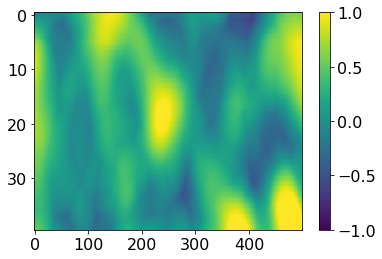

In [70]:
im = generate_real_samples(data_zn, 10)[0][0]
#plt.figure(figsize=(40,4))
plt.imshow(im[0,:,:,0], aspect='auto', vmin = -1, vmax = 1)
plt.colorbar()

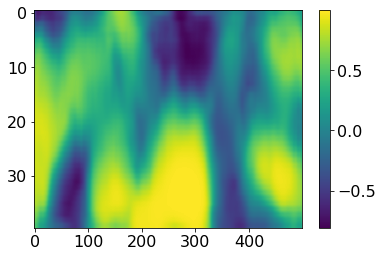

In [72]:
im = generate_fake_samples(g_model, 50, 10)[0][0]
#im = ((im / 2) + 0.5) * (max_ - min_) + min_
#plt.figure(figsize=(50,5))
plt.imshow(im[0,:,:,0], aspect='auto')
plt.colorbar()

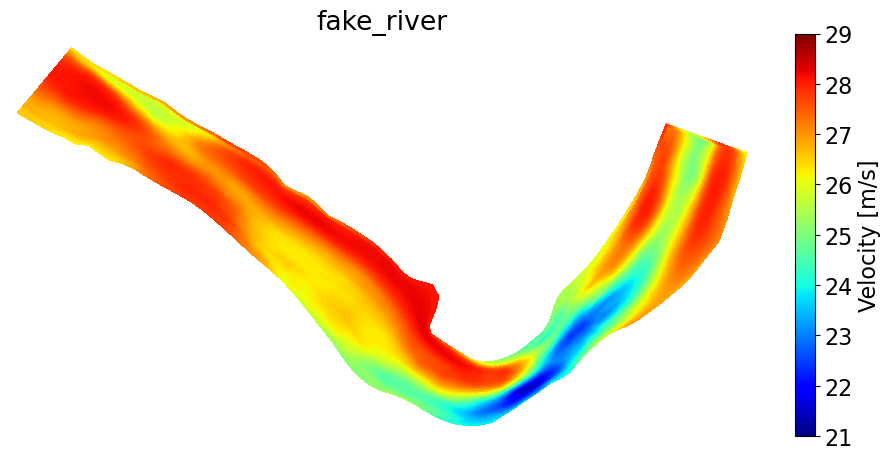

In [92]:
im = generate_fake_samples(g_model, 50, 10)[0][0]
im = ((im / 2) + 0.5) * (max_ - min_) + min_
fake_river = np.reshape(Z.T, (4500, 41, 501, 1))[0, :, :, 0]
fake_river[:40, :500] = im[0,:,:,0]
dp.plt_im_tri(depth=fake_river.ravel(), fig_title = 'fake_river', fig_name = 'fake_river_3.png')

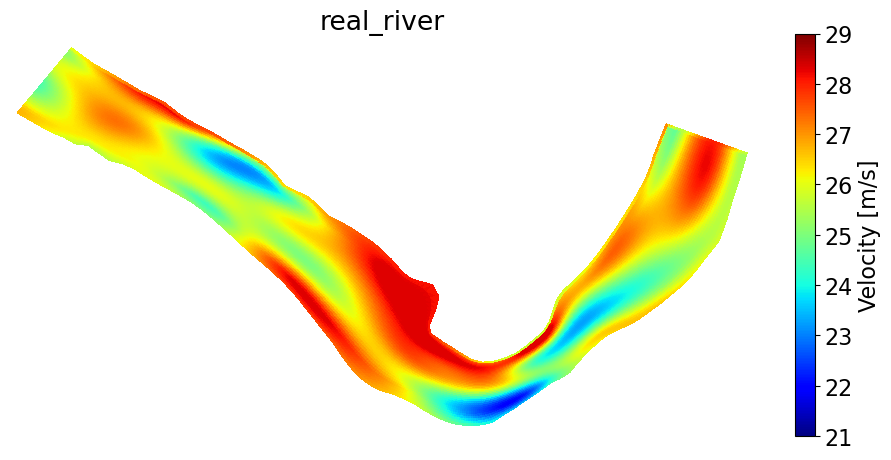

In [86]:
im = generate_real_samples(data_zn, 10)[0][0]
im = ((im / 2) + 0.5) * (max_ - min_) + min_
fake_river = np.reshape(Z.T, (4500, 41, 501, 1))[0, :, :, 0]
fake_river[:40, :500] = im[0,:,:,0]
dp.plt_im_tri(depth=fake_river.ravel(), fig_title = 'real_river', fig_name = 'real_river_3.png')

In [93]:
g_model.save_weights('Bathy_Generator_2.h5')

In [94]:
c_model.save_weights('Bathy_Critic_2.h5')